# NBEATSx development and assessment 

In [1]:
#!pip install neuralforecast

import tqdm as tqdm
from tqdm import tqdm
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx

from random import randrange
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, MAE, MSE, RMSE
from neuralforecast.tsdataset import TimeSeriesDataset
#from neuralforecast.losses.numpy import rmse, mape
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

/Users/charles/anaconda3/envs/columbia/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/charles/anaconda3/envs/columbia/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN3c106detail19maybe_wrap_dim_slowExxb)
  Referenced from: '/Users/charles/anaconda3/envs/columbia/lib/python3.10/site-packages/torchvision/image.so'
  Expected in: '/Users/charles/anaconda3/envs/columbia/lib/python3.10/site-packages/torch/lib/libc10.dylib'
  warn(f"Failed to load image Python extension: {e}")


In [2]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')


In [3]:
print(pd. __version__)

1.4.4


In [4]:
Tickers_ = ['^GSPC']#  '^GSPC' ie SP500
list_exo =  ['^VIX', '^TNX']

def loading_data(Tickers_, list_exo):
    Tickers = Tickers_+list_exo
    print(f'Loading the yf data for {Tickers} ...')
    Names = {}
    for ticker in Tickers:
        Names[ticker] = yf.Ticker(ticker)

    DATA = {}
    DATA_2 = {}
    DATA_3 = {}
    for ticker in Tickers:
        closePrices = yf.Ticker(ticker).history(start='2021-11-01', end='2023-10-20', interval='1d')['Close']
        #closePrices = yf.Ticker(ticker).history(start='2021-11-01', end='2023-10-20', interval='1d')['Close']
        DATA[ticker] = pd.DataFrame({'value': closePrices.values, 'date': closePrices.index})
        DATA[ticker]['time_idx'] = range(len(DATA[ticker]['date']))

    for ticker in Tickers:
        closePrices = yf.Ticker(ticker).history(start='2019-11-01', end='2021-10-31', interval='1d')['Close']
        #closePrices = yf.Ticker(ticker).history(start='2021-11-01', end='2023-10-20', interval='1d')['Close']
        DATA_2[ticker] = pd.DataFrame({'value': closePrices.values, 'date': closePrices.index})
        DATA_2[ticker]['time_idx'] = range(len(DATA_2[ticker]['date']))

    for ticker in Tickers:
        closePrices = yf.Ticker(ticker).history(start='2017-11-01', end='2019-10-31', interval='1d')['Close']
        #closePrices = yf.Ticker(ticker).history(start='2021-11-01', end='2023-10-20', interval='1d')['Close']
        DATA_3[ticker] = pd.DataFrame({'value': closePrices.values, 'date': closePrices.index})
        DATA_3[ticker]['time_idx'] = range(len(DATA_3[ticker]['date']))

    #df = pd.DataFrame(DATA['^GSPC'])
    #df_2 = pd.DataFrame(DATA_2['^GSPC'])
    #df_3 = pd.DataFrame(DATA_3['^GSPC'])
    df = pd.DataFrame(DATA[Tickers_[0]])
    df_2 = pd.DataFrame(DATA_2[Tickers_[0]])
    df_3 = pd.DataFrame(DATA_3[Tickers_[0]])

    df = df_2.append(df)
    df = df_3.append(df)
    df['date'] = df['date'].astype('datetime64[ns]')
    df['date']= df['date'].apply(lambda ts: ts.replace(hour=0, minute=0, second=0))
    print('df', df)
    print('DATA', DATA_3.keys())
    #print(DATA_3['^VIX'])
    #add exogenous variables
    for exo_ticket in list_exo:

        df_exo = pd.DataFrame(DATA[exo_ticket])
        df_2_exo = pd.DataFrame(DATA_2[exo_ticket])
        df_3_exo = pd.DataFrame(DATA_3[exo_ticket])
        df_exo = df_2_exo.append(df_exo)
        df_exo = df_3_exo.append(df_exo)
        df_exo.rename(columns={'value':exo_ticket}, inplace=True)
        df_exo['date'] = df_exo['date'].astype('datetime64[ns]')
        df_exo['date']= df_exo['date'].apply(lambda ts: ts.replace(hour=0, minute=0, second=0))
        print('df_exo', df_exo)
        df = pd.merge(df, df_exo[['date', exo_ticket]], on="date")
        print('df merge: ', df)
        print(df.columns)


    df.reset_index(inplace=True)
    df['unique_id'] = 'NP' #df.index
    df.rename(columns={'date':'ds'}, inplace=True)
    #df['ds'] = df['ds'].astype('datetime64[ns]')#pd.to_datetime(df['ds'])
    df.rename(columns={'value':'y'}, inplace=True)
    train = df.iloc[:int(len(df['y'])*0.9)]
    test = df.iloc[int(len(df['y'])*0.9):]
    print(df)
    print(df.dtypes)

    dataset, *_ = TimeSeriesDataset.from_df(df = train)
    dataset2, *_ = TimeSeriesDataset.from_df(df = test)

    return df, test, train, dataset, dataset2



In [5]:
df, test, train, dataset, dataset2 = loading_data(Tickers_, list_exo)

Loading the yf data for ['^GSPC', '^VIX', '^TNX'] ...
df            value       date  time_idx
0    2579.360107 2017-11-01         0
1    2579.850098 2017-11-02         1
2    2587.840088 2017-11-03         2
3    2591.129883 2017-11-06         3
4    2590.639893 2017-11-07         4
..           ...        ...       ...
490  4327.779785 2023-10-13       490
491  4373.629883 2023-10-16       491
492  4373.200195 2023-10-17       492
493  4314.600098 2023-10-18       493
494  4278.000000 2023-10-19       494

[1500 rows x 3 columns]
DATA dict_keys(['^GSPC', '^VIX', '^TNX'])
df_exo           ^VIX       date  time_idx
0    10.200000 2017-11-01         0
1     9.930000 2017-11-02         1
2     9.140000 2017-11-03         2
3     9.400000 2017-11-06         3
4     9.890000 2017-11-07         4
..         ...        ...       ...
490  19.320000 2023-10-13       490
491  17.209999 2023-10-16       491
492  17.879999 2023-10-17       492
493  19.219999 2023-10-18       493
494  21.400000 20

In [6]:
df_backup = df.copy()

## Work on the src Folder

In [7]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [8]:
def create_dictionary(keys, values):
    # Check if the length of the two lists is the same
    if len(keys) != len(values):
        raise ValueError("Lists must have the same length")

    # Use zip to combine the two lists into pairs, then convert to a dictionary
    my_dict = dict(zip(keys, values))
    return my_dict

In [9]:
# Example lists
print('list_exo = ', list_exo)
keys_list_exo = list_exo
values_list_exo = [f'Exogenous{i}' for i in range(1, len(list_exo)+1)]
print(values_list_exo)
# Create the dictionary
result_dict = create_dictionary(keys_list_exo, values_list_exo)
print(result_dict)
df.rename(columns=result_dict, inplace=True)

list_exo =  ['^VIX', '^TNX']
['Exogenous1', 'Exogenous2']
{'^VIX': 'Exogenous1', '^TNX': 'Exogenous2'}


In [10]:
df['week_day'] = df['ds'].dt.dayofweek
len_train = int(0.8*len(df))
"""
        Y_df: DataFrame
            DataFrame with target variable. Must contain columns ['unique_id', 'ds', 'y']
        X_df: DataFrame
            DataFrame with temporal exogenous variables. Must contain columns ['unique_id', 'ds']

"""
Y_df = df[['ds', 'unique_id', 'y']]
print('Y_df:', Y_df)
X_df = df[['ds', 'unique_id']+['week_day']+values_list_exo]
print('X_df:', X_df)

Y_df:              ds unique_id            y
0    2017-11-01        NP  2579.360107
1    2017-11-02        NP  2579.850098
2    2017-11-03        NP  2587.840088
3    2017-11-06        NP  2591.129883
4    2017-11-07        NP  2590.639893
...         ...       ...          ...
1495 2023-10-13        NP  4327.779785
1496 2023-10-16        NP  4373.629883
1497 2023-10-17        NP  4373.200195
1498 2023-10-18        NP  4314.600098
1499 2023-10-19        NP  4278.000000

[1500 rows x 3 columns]
X_df:              ds unique_id  week_day  Exogenous1  Exogenous2
0    2017-11-01        NP         2   10.200000       2.376
1    2017-11-02        NP         3    9.930000       2.347
2    2017-11-03        NP         4    9.140000       2.343
3    2017-11-06        NP         0    9.400000       2.320
4    2017-11-07        NP         1    9.890000       2.307
...         ...       ...       ...         ...         ...
1495 2023-10-13        NP         4   19.320000       4.629
1496 2023-10-16

In [11]:
from src_v2.utils.data.datasets.epf import EPF, EPFInfo
from src_v2.utils.pytorch.ts_dataset import TimeSeriesDataset
from src_v2.utils.pytorch.ts_loader import TimeSeriesLoader
from src_v2.nbeats.nbeats import Nbeats

# train_mask: 1 to keep, 0 to mask
train_mask = np.ones(len(Y_df))
print(train_mask)
train_mask[-len_train:] = 0

# Dataset object. Pre-process the DataFrame into pytorch tensors and windows.
ts_dataset = TimeSeriesDataset(Y_df=Y_df, X_df=X_df, ts_train_mask=train_mask)


# Setting parameters: 
input_size_multiplier=52
output_size=1
# implied input_size
input_size=input_size_multiplier*output_size
print('input size:', input_size)
list_stacks = ['exogenous_tcn']+['trend']+['seasonality']#['identity']+

# For more information on each parameter, refer to comments on Loader object.
train_loader = TimeSeriesLoader(model='nbeats',
                                ts_dataset=ts_dataset,
                                window_sampling_limit=365*4*24,
                                offset=0,
                                input_size=input_size,
                                output_size=output_size,
                                idx_to_sample_freq=24,
                                batch_size=512,
                                is_train_loader=True,
                                shuffle=True)

# Validation loader (note: in this example we are also validating on the period to forecast)
val_loader = TimeSeriesLoader(model='nbeats',
                              ts_dataset=ts_dataset,
                              window_sampling_limit=365*4*24,
                              offset=0,
                              input_size=input_size,
                              output_size=output_size,
                              idx_to_sample_freq=24,
                              batch_size=512,
                              is_train_loader=False,
                              shuffle=False)

[1. 1. 1. ... 1. 1. 1.]
Processing dataframes ...
Creating ts tensor ...
input size: 52


In [11]:
ts_dataset.dates


array(['2017-11-01T00:00:00.000000000', '2017-11-02T00:00:00.000000000',
       '2017-11-03T00:00:00.000000000', ...,
       '2023-10-17T00:00:00.000000000', '2023-10-18T00:00:00.000000000',
       '2023-10-19T00:00:00.000000000'], dtype='datetime64[ns]')

In [12]:
# Assuming 'ts_loader' is your TimeSeriesLoader instance
for batch in train_loader:
    # Inspect the first batch
    print("In-sample Y:", batch['insample_y'])
    print("Out-sample Y:", batch['outsample_y'])
    # If you have added a 'dates' key
    print("Batch Dates:", batch.get('dates', 'No date key found'))
    break  # Break after the first batch for testing

In-sample Y: tensor([[2670.1399, 2670.2900, 2634.5601, 2639.3999, 2666.9399, 2669.9099,
         2648.0500, 2654.8000, 2635.6699, 2629.7300, 2663.4199, 2672.6299,
         2671.9199, 2697.7900, 2723.0701, 2727.7200, 2730.1299, 2711.4500,
         2722.4600, 2720.1299, 2712.9700, 2733.0100, 2724.4399, 2733.2900,
         2727.7600, 2721.3301, 2689.8601, 2724.0100, 2705.2700, 2734.6201,
         2746.8701, 2748.8000, 2772.3501, 2770.3701, 2779.0300, 2782.0000,
         2786.8501, 2775.6299, 2782.4900, 2779.6599, 2773.7500, 2762.5901,
         2767.3201, 2749.7600, 2754.8799, 2717.0701, 2723.0601, 2699.6299,
         2716.3101, 2718.3701, 2726.7100, 2713.2200],
        [2743.1499, 2747.7100, 2751.2900, 2748.2300, 2767.5601, 2786.2400,
         2776.4199, 2802.5601, 2798.0300, 2810.3000, 2832.9700, 2839.1299,
         2837.5400, 2839.2500, 2872.8701, 2853.5300, 2822.4299, 2823.8101,
         2821.9800, 2762.1299, 2648.9399, 2695.1399, 2681.6599, 2581.0000,
         2619.5500, 2656.0000, 26

In [13]:
ts_dataset.t_cols

['y',
 'week_day',
 'Exogenous1',
 'Exogenous2',
 'insample_mask',
 'outsample_mask']

In [14]:
# Dictionary with lags to include for y and each exogenous variable.
# Eg: -1 corresonds to future (available for exogenous), -2 correponds to last available day, and so on.
include_var_dict = {'y': [-8,-4,-3,-2],
                    'Exogenous1': [-8,-4,-3,-2],#[-8,-2,-1],
                    'Exogenous2': [-8,-4,-3,-2],#[-8,-2,-1],
                    'week_day': [-1]}

model = Nbeats(input_size_multiplier=input_size_multiplier,
                output_size=output_size,
                shared_weights=False,
                initialization='he_uniform',
                activation='sigmoid', #selu',
                stack_types=list_stacks,#
                n_blocks=len(list_stacks)*[1],#[1, 1],
                n_layers=len(list_stacks)*[2],#[2, 2],
                n_hidden=len(list_stacks)*[[512,512]],#[[512,512], [512,512]],
                n_harmonics=0, # not used with exogenous_tcn
                n_polynomials=0, # not used with exogenous_tcn
                x_s_n_hidden = 0,
                exogenous_n_channels=9,
                include_var_dict=include_var_dict,
                t_cols=ts_dataset.t_cols,
                batch_normalization = True,
                dropout_prob_theta=0.1,
                dropout_prob_exogenous=0,
                learning_rate=0.001,
                lr_decay=0.5,
                n_lr_decay_steps=3,
                early_stopping=50,
                weight_decay=0,
                l1_theta=0,
                n_iterations=5_000,
                loss='MSE',
                loss_hypar=0.5,
                val_loss='MSE',
                seasonality=24, # not used: only used with MASE loss
                random_seed=1)

#model.fit(train_ts_loader=train_loader, val_ts_loader=val_loader, eval_steps=50)
model.fit(train_ts_loader=train_loader, val_ts_loader=val_loader, eval_steps=50)



============================== Start fitting ==============================
Step: 50, Time: 1.722, Insample MSE: 1140.40369, Outsample MSE: 3121.37061
Step: 100, Time: 3.498, Insample MSE: 768.53247, Outsample MSE: 4934.11523


KeyboardInterrupt: 

In [ ]:
y_true, y_hat, block_forecast, outsample_masks_ = model.predict(ts_loader=val_loader, return_decomposition=True)

## Plotting results

Text(0, 0.5, 'Stock value')

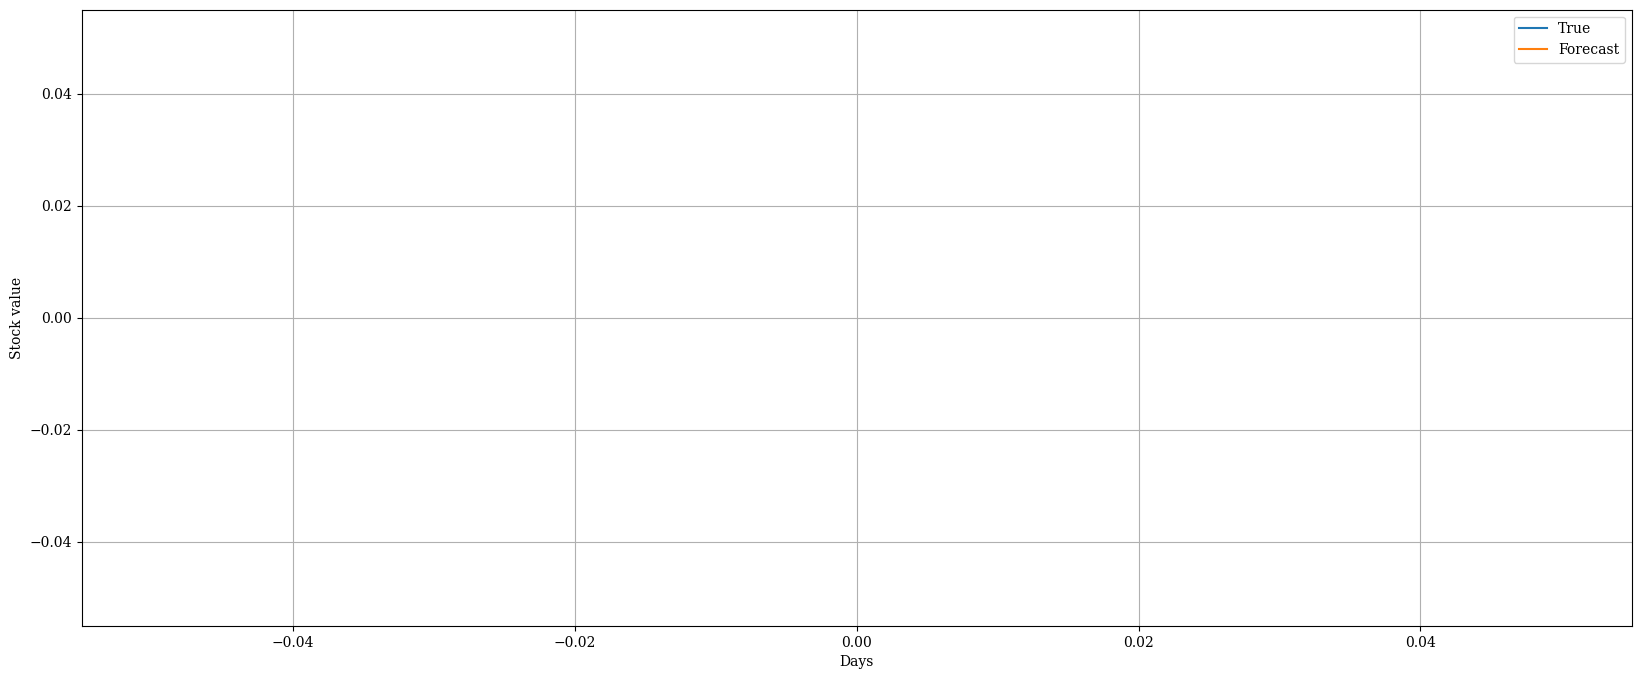

In [17]:
st = 100
plt.figure(figsize=(20, 8))

#plt.plot(range(len(y_hat.flatten()), Y_df['y'].values, label='True price')
plt.plot(range(len(y_hat.flatten()[st:-20])), y_true.flatten()[st:-20], label='True')

plt.plot(range(len(y_hat.flatten()[st:-20])), y_hat.flatten()[st:-20], label='Forecast')
#plt.axvline(168, color='black')
plt.legend()
plt.grid()
plt.xlabel('Days')
plt.ylabel('Stock value')

Text(0, 0.5, 'Stock value')

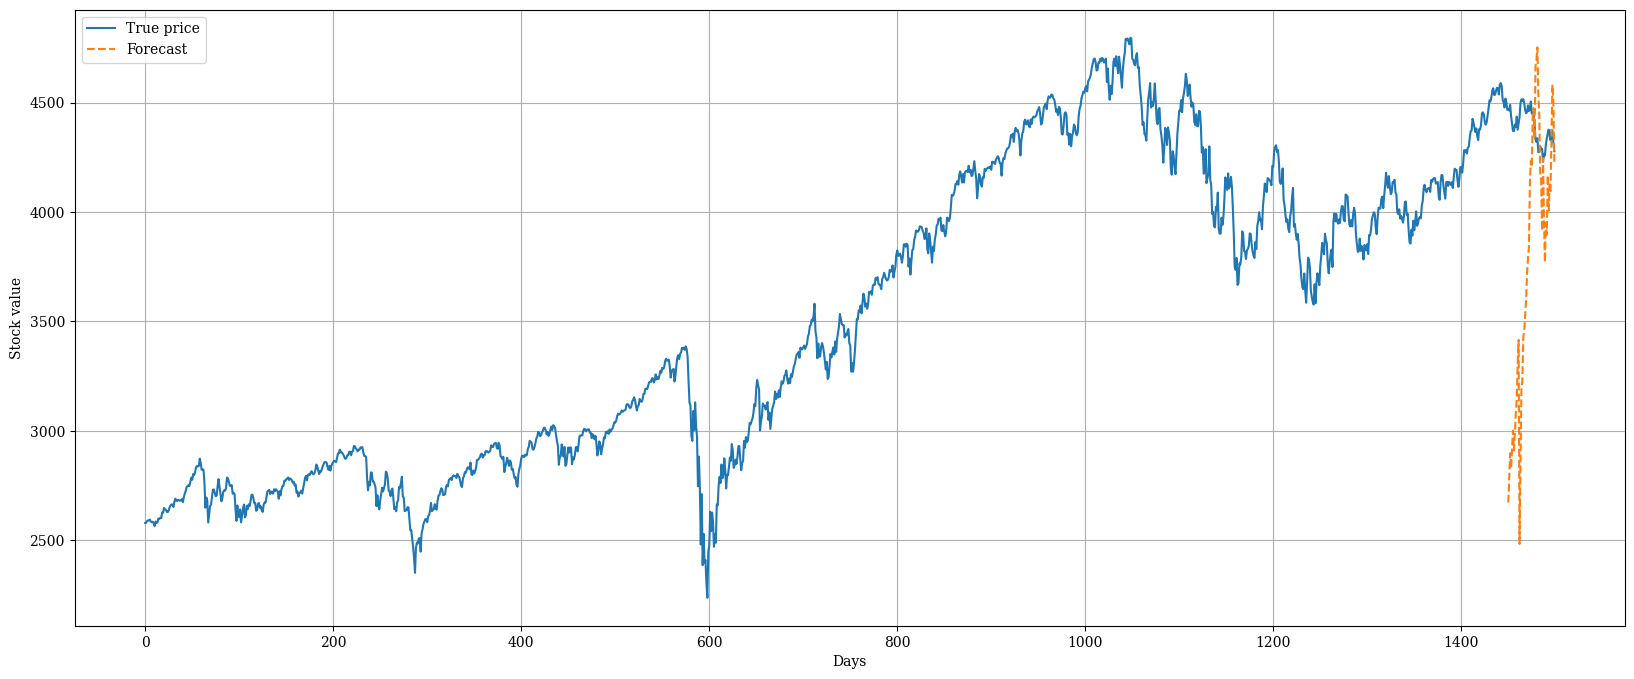

In [18]:
plt.figure(figsize=(20, 8))

plt.plot(range(len(Y_df)), Y_df['y'].values, label='True price')
plt.plot(range(len(Y_df)-len(y_hat.flatten()[-400:]),len(Y_df)), y_hat.flatten()[-400:], linestyle='dashed', label='Forecast')
#plt.axvline(168, color='black')
plt.legend()
plt.grid()
plt.xlabel('Days')
plt.ylabel('Stock value')

## Decomposition according to the stacks

(50,)
(50,)
(50,)


Text(0, 0.5, 'Stock value')

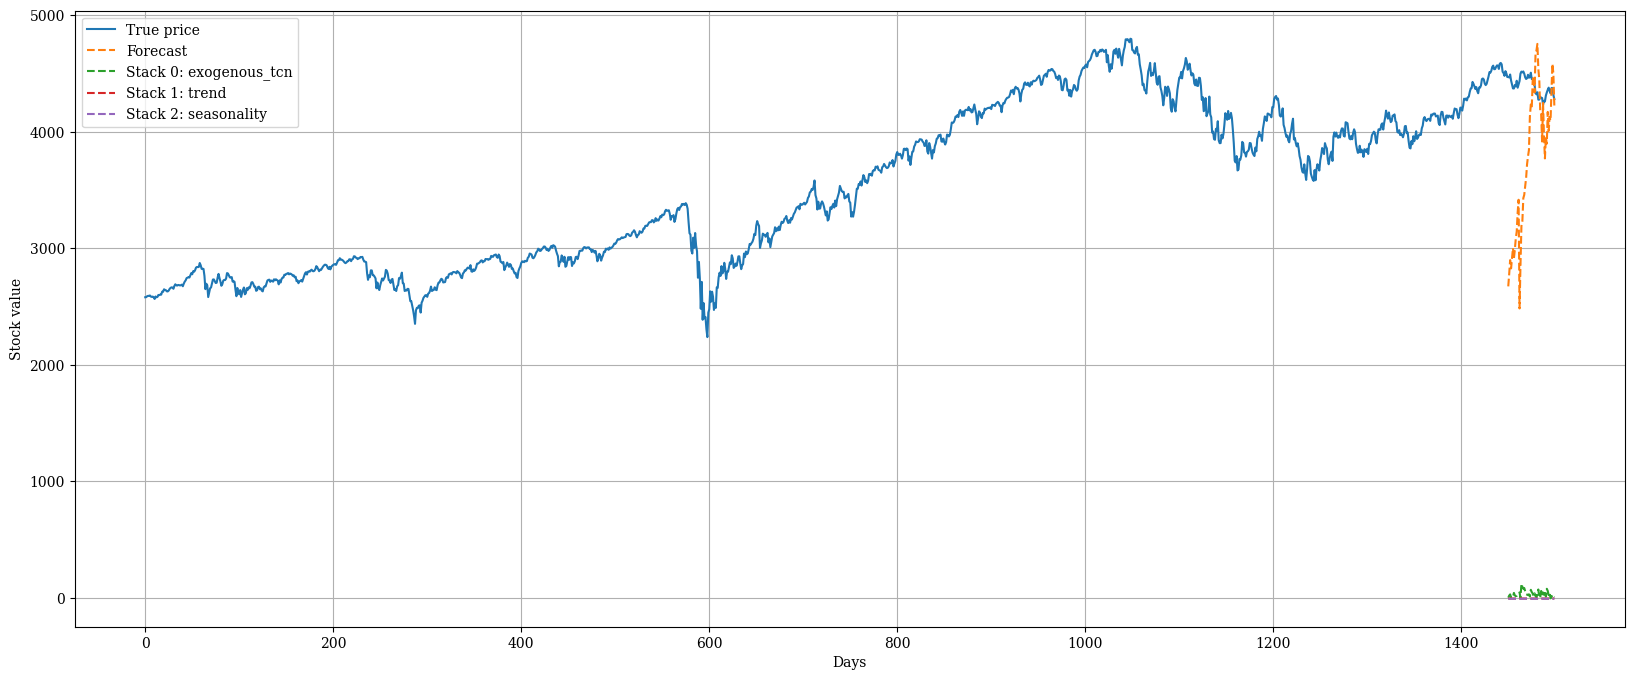

In [19]:
plt.figure(figsize=(20, 8))

plt.plot(range(len(Y_df)), Y_df['y'].values, label='True price')
plt.plot(range(len(Y_df)-len(y_hat.flatten()[-1000:]),len(Y_df)), y_hat.flatten()[-1000:], linestyle='dashed', label='Forecast')
for i in range(np.shape(block_forecast)[1]):
    y_block = block_forecast[:,i,:].flatten()
    print(np.shape(y_block))
    plt.plot(range(len(Y_df)-len(y_hat.flatten()[-1000:]),len(Y_df)), y_block[-1000:], linestyle='dashed', label=f'Stack {i}: {list_stacks[i]}')

plt.legend()
plt.grid()
plt.xlabel('Days')
plt.ylabel('Stock value')

(50,)
(50,)
(50,)


Text(0, 0.5, 'Stock value')

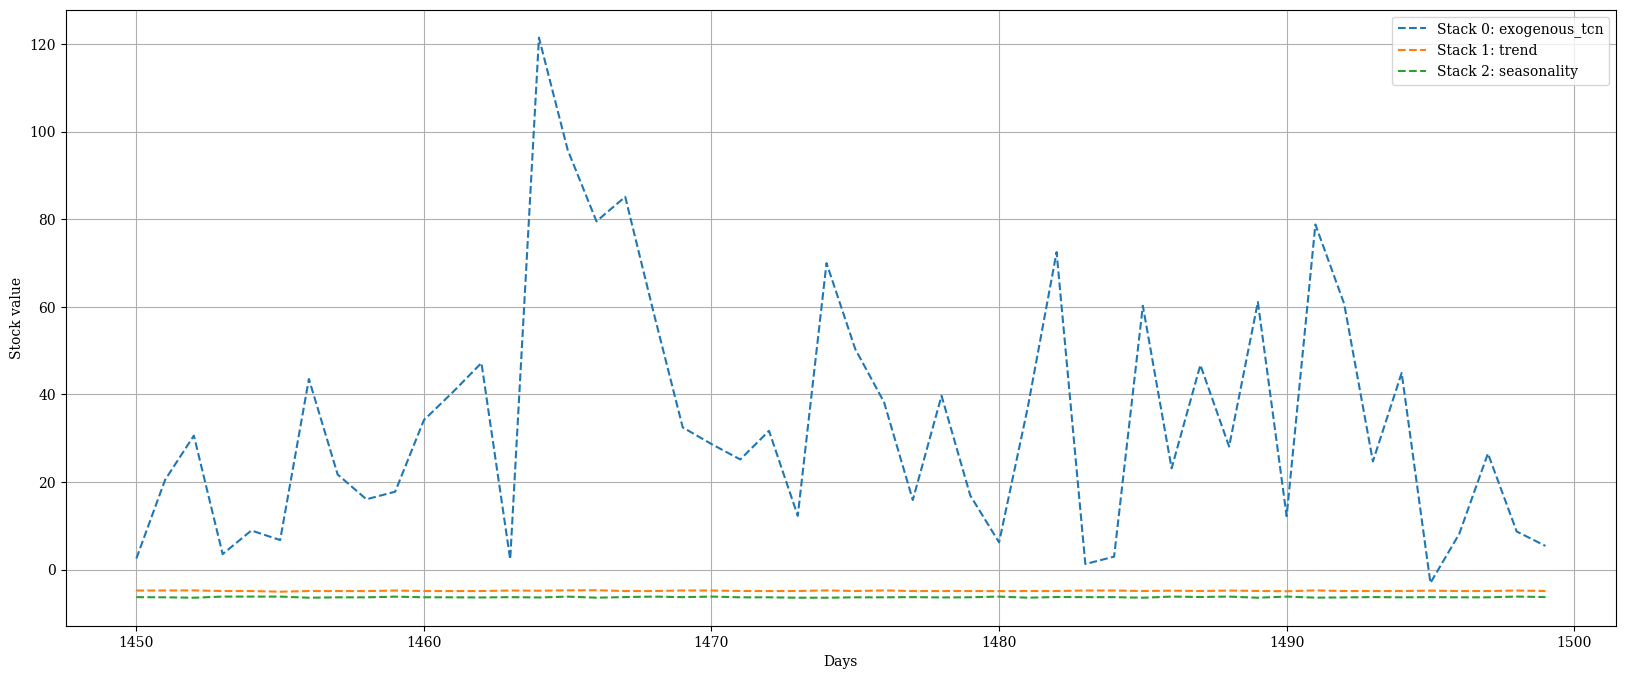

In [20]:
plt.figure(figsize=(20, 8))
for i in range(np.shape(block_forecast)[1]):
    y_block = block_forecast[:,i,:].flatten()
    print(np.shape(y_block))
    plt.plot(range(len(Y_df)-len(y_hat.flatten()[-1000:]),len(Y_df)), y_block[-1000:], linestyle='dashed', label=f'Stack {i}: {list_stacks[i]}')

plt.legend()
plt.grid()
plt.xlabel('Days')
plt.ylabel('Stock value')

(50,)


Text(0, 0.5, 'Stock value')

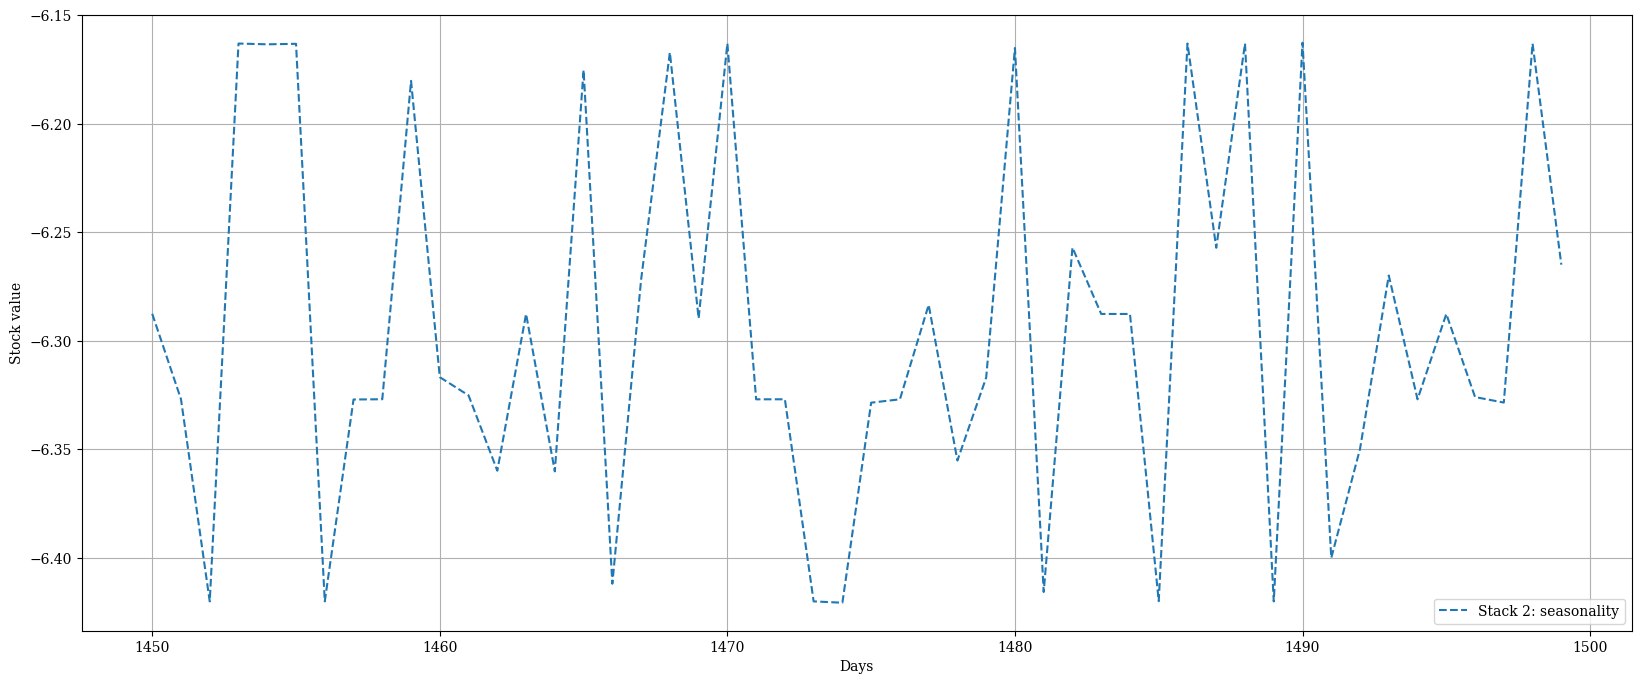

In [21]:
plt.figure(figsize=(20, 8))
for i in range(2,np.shape(block_forecast)[1]):
    y_block = block_forecast[:,i,:].flatten()
    print(np.shape(y_block))
    plt.plot(range(len(Y_df)-len(y_hat.flatten()[-1000:]),len(Y_df)), y_block[-1000:], linestyle='dashed', label=f'Stack {i}: {list_stacks[i]}')

plt.legend()
plt.grid()
plt.xlabel('Days')
plt.ylabel('Stock value')

# MERGE

In [12]:
def training(df, list_exo, loss='MSE', val_loss='MSE', input_size_multiplier=7, output_size=24,list_stacks = ['exogenous_tcn']+['trend']+['seasonality']+['identity'], cross_val = False):
    
    # Example lists
    print('list_exo = ', list_exo)
    keys_list_exo = list_exo
    values_list_exo = [f'Exogenous{i}' for i in range(1, len(list_exo)+1)]
    #print(values_list_exo)
    # Create the dictionary
    result_dict = create_dictionary(keys_list_exo, values_list_exo)
    #print(result_dict)
    df.rename(columns=result_dict, inplace=True)
    
    df['week_day'] = df['ds'].dt.dayofweek
    len_train = int(0.8*len(df))
    """
            Y_df: DataFrame
                DataFrame with target variable. Must contain columns ['unique_id', 'ds', 'y']
            X_df: DataFrame
                DataFrame with temporal exogenous variables. Must contain columns ['unique_id', 'ds']

    """
    Y_df = df[['ds', 'unique_id', 'y']]
    #print('Y_df:', Y_df)
    X_df = df[['ds', 'unique_id']+['week_day']+values_list_exo]
    #print('X_df:', X_df)
    ####################################################################################################


    # train_mask: 1 to keep, 0 to mask
    train_mask = np.ones(len(Y_df))
    #print(train_mask)
    train_mask[-len_train:] = 0

    # Dataset object. Pre-process the DataFrame into pytorch tensors and windows.
    ts_dataset = TimeSeriesDataset(Y_df=Y_df, X_df=X_df, ts_train_mask=train_mask)


    # Setting parameters: 
    # implied input_size
    input_size=input_size_multiplier*output_size
    #print('input size:', input_size)
    #list_stacks = ['exogenous_tcn']+['trend']+['seasonality']#['identity']+

    # For more information on each parameter, refer to comments on Loader object.
    train_loader = TimeSeriesLoader(model='nbeats',
                                    ts_dataset=ts_dataset,
                                    window_sampling_limit=365*4*24,
                                    offset=0,
                                    input_size=input_size,
                                    output_size=output_size,
                                    idx_to_sample_freq=24,
                                    batch_size=512,
                                    is_train_loader=True,
                                    shuffle=True)

    # Validation loader (note: in this example we are also validating on the period to forecast)
    val_loader = TimeSeriesLoader(model='nbeats',
                                  ts_dataset=ts_dataset,
                                  window_sampling_limit=365*4*24,
                                  offset=0,
                                  input_size=input_size,
                                  output_size=output_size,
                                  idx_to_sample_freq=24,
                                  batch_size=512,
                                  is_train_loader=False,
                                  shuffle=False)
    
    ####################################################################################################

    # Dictionary with lags to include for y and each exogenous variable.
    # Eg: -1 corresonds to future (available for exogenous), -2 correponds to last available day, and so on.
    include_var_dict = {'y': [-8,-4,-3,-2],
                        'Exogenous1': [-8,-4,-3,-2],#[-8,-2,-1],
                        'Exogenous2': [-8,-4,-3,-2],#[-8,-2,-1],
                        'week_day': [-1]}

    model = Nbeats(input_size_multiplier=input_size_multiplier,
                    output_size=output_size,
                    shared_weights=False,
                    initialization='he_uniform',
                    activation='sigmoid', #selu',
                    stack_types=list_stacks,#
                    n_blocks=len(list_stacks)*[1],#[1, 1],
                    n_layers=len(list_stacks)*[2],#[2, 2],
                    n_hidden=len(list_stacks)*[[512,512]],#[[512,512], [512,512]],
                    n_harmonics=0, # not used with exogenous_tcn
                    n_polynomials=0, # not used with exogenous_tcn
                    x_s_n_hidden = 0,
                    exogenous_n_channels=9,
                    include_var_dict=include_var_dict,
                    t_cols=ts_dataset.t_cols,
                    batch_normalization = True,
                    dropout_prob_theta=0.1,
                    dropout_prob_exogenous=0,
                    learning_rate=0.001,
                    lr_decay=0.5,
                    n_lr_decay_steps=3,
                    early_stopping=50,
                    weight_decay=0,
                    l1_theta=0,
                    n_iterations=5_000,
                    loss=loss,
                    loss_hypar=0.5,
                    val_loss=val_loss,
                    seasonality=24, # not used: only used with MASE loss
                    random_seed=1)

    #model.fit(train_ts_loader=train_loader, val_ts_loader=val_loader, eval_steps=50)
    if cross_val == False:
        model.fit(train_ts_loader=train_loader, val_ts_loader=val_loader, eval_steps=50)
    else:
        model.fit_cross_validation(X_df, Y_df, n_validations=5, n_iterations=None, input_size_multiplier=input_size, output_size=output_size, 
                             verbose=True, eval_steps=1)
    
    
    return model, train_loader, val_loader

In [13]:
def predict_nbeats(model, val_loader, decomposition = True):
    y_true, y_hat, block_forecast, outsample_masks_ = model.predict(ts_loader=val_loader, return_decomposition=True)
    
    # getting back the dates
    
    
    # Plotting prediction
    st =0# 100
    plt.figure(figsize=(20, 8))

    #plt.plot(range(len(y_hat.flatten()), Y_df['y'].values, label='True price')
    plt.plot(range(len(y_hat.flatten()[st:-20])), y_true.flatten()[st:-20], label='True')

    plt.plot(range(len(y_hat.flatten()[st:-20])), y_hat.flatten()[st:-20], label='Forecast')
    #plt.axvline(168, color='black')
    plt.legend()
    plt.grid()
    plt.xlabel('Days')
    plt.ylabel('Stock value')
    
    # Plotting decomposition
    plt.figure(figsize=(20, 8))
    for i in range(np.shape(block_forecast)[1]):
        y_block = block_forecast[:,i,:].flatten()
        print(np.shape(y_block))
        plt.plot(range(len(Y_df)-len(y_hat.flatten()[-1000:]),len(Y_df)), y_block[-1000:], linestyle='dashed', label=f'Stack {i}: {list_stacks[i]}')

    plt.legend()
    plt.grid()
    plt.xlabel('Days')
    plt.ylabel('Stock value')
    
    plt.show()
    
    return  y_true, y_hat, block_forecast, outsample_masks_


In [17]:
list_stacks = ['trend']+['seasonality']+['identity']+['exogenous_tcn']
val_loss='MAE'
loss='MSE'
input_size_multiplier=52
output_size=4
model, train_loader, val_loader = training(df, list_exo, loss='MSE', val_loss='MSE', input_size_multiplier=input_size_multiplier, output_size=output_size, list_stacks =list_stacks )

list_exo =  ['^VIX', '^TNX']
Processing dataframes ...
Creating ts tensor ...


============================== Start fitting ==============================
Step: 50, Time: 2.465, Insample MSE: 875.46436, Outsample MSE: 8931.84375


KeyboardInterrupt: 

(200,)
(200,)
(200,)
(200,)


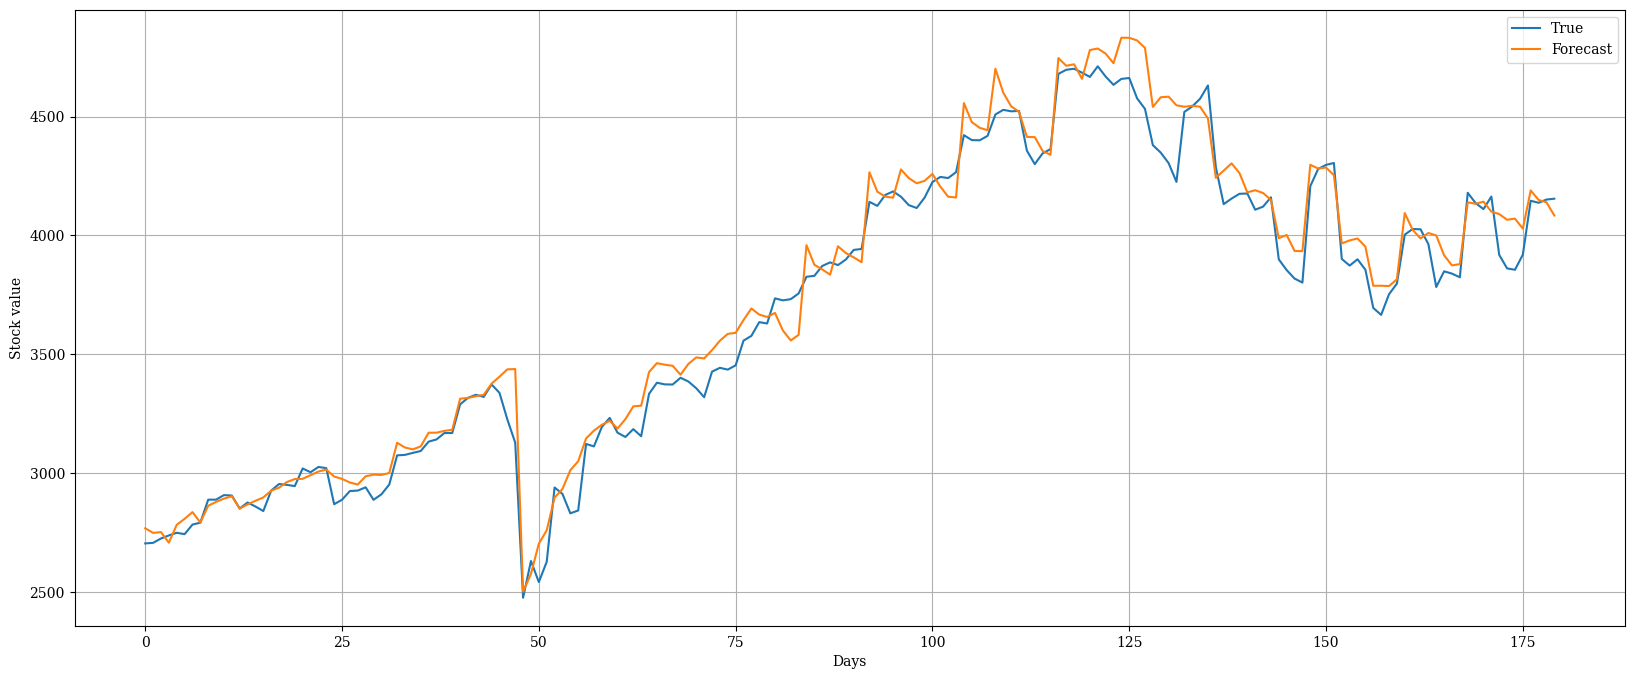

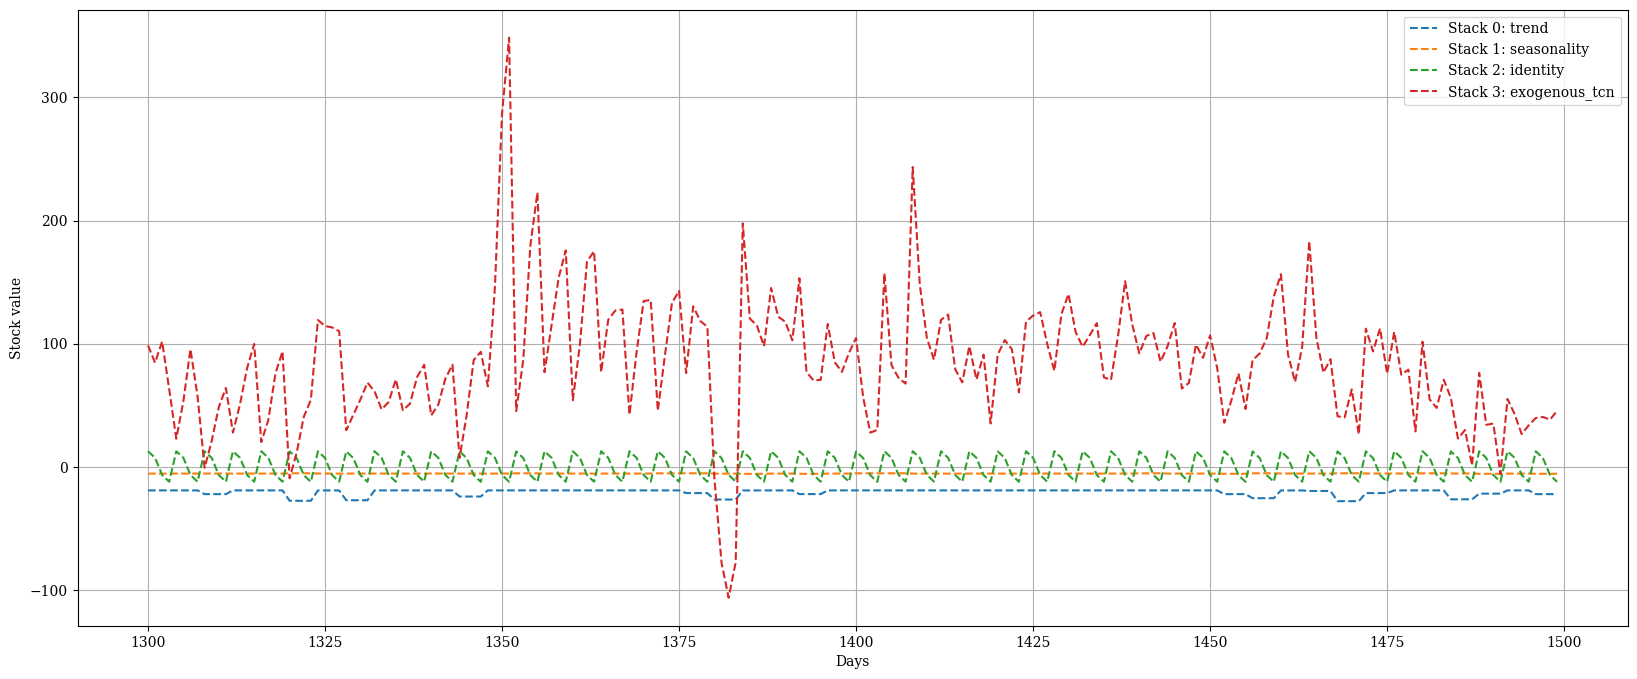

In [25]:
y_true, y_hat, block_forecast, outsample_masks_ = predict_nbeats(model, val_loader, decomposition = True)

(200,)
(200,)
(200,)


Text(0, 0.5, 'Stock value')

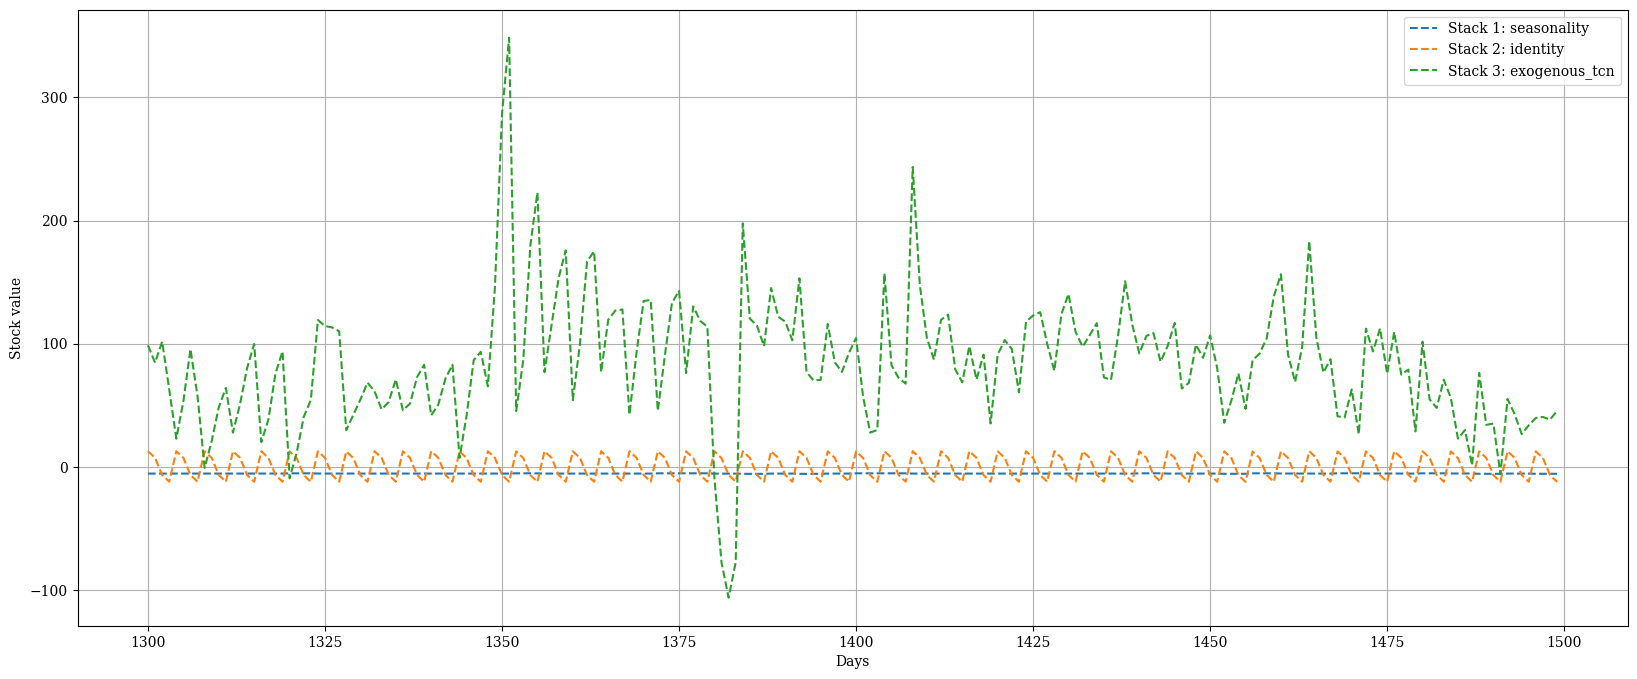

In [26]:
plt.figure(figsize=(20, 8))
for i in range(1,np.shape(block_forecast)[1]):
    y_block = block_forecast[:,i,:].flatten()
    print(np.shape(y_block))
    plt.plot(range(len(Y_df)-len(y_hat.flatten()[-1000:]),len(Y_df)), y_block[-1000:], linestyle='dashed', label=f'Stack {i}: {list_stacks[i]}')

plt.legend()
plt.grid()
plt.xlabel('Days')
plt.ylabel('Stock value')

# Sensitivity assessment of the different parameters

In [27]:
from itertools import combinations

def generate_subsets(lst):
    subsets = []
    n = len(lst)
    for r in range(1, n + 1):
        subsets.extend(combinations(lst, r))
    # Convert tuples to lists
    subsets = [list(subset) for subset in subsets]
    # Sort subsets by length
    subsets.sort(key=len)    
    return subsets


### Impact of the horizon of the prediction and the number of past days used for predictions

Case:  0
output_size = 1  and input_size = 252
list_exo =  ['^VIX', '^TNX']
Processing dataframes ...
Creating ts tensor ...


============================== Start fitting ==============================
Step: 50, Time: 1.397, Insample MSE: 513.83624, Outsample MSE: 109906.63281
Step: 100, Time: 2.711, Insample MSE: 480.42734, Outsample MSE: 108994.02344
Step: 150, Time: 3.982, Insample MSE: 437.00729, Outsample MSE: 110843.82031
Step: 200, Time: 5.267, Insample MSE: 425.86520, Outsample MSE: 105005.79688
Step: 250, Time: 6.560, Insample MSE: 373.10217, Outsample MSE: 100490.14844
Step: 300, Time: 7.862, Insample MSE: 364.03934, Outsample MSE: 71127.82031
Step: 350, Time: 9.158, Insample MSE: 315.81656, Outsample MSE: 70737.90625
Step: 400, Time: 10.512, Insample MSE: 313.00430, Outsample MSE: 60823.08594
Step: 450, Time: 11.838, Insample MSE: 248.22327, Outsample MSE: 52811.35938
Step: 500, Time: 13.134, Insample MSE: 185.40123, Outsample MSE: 46646.13672
Step: 550, Time: 14.448, Insam

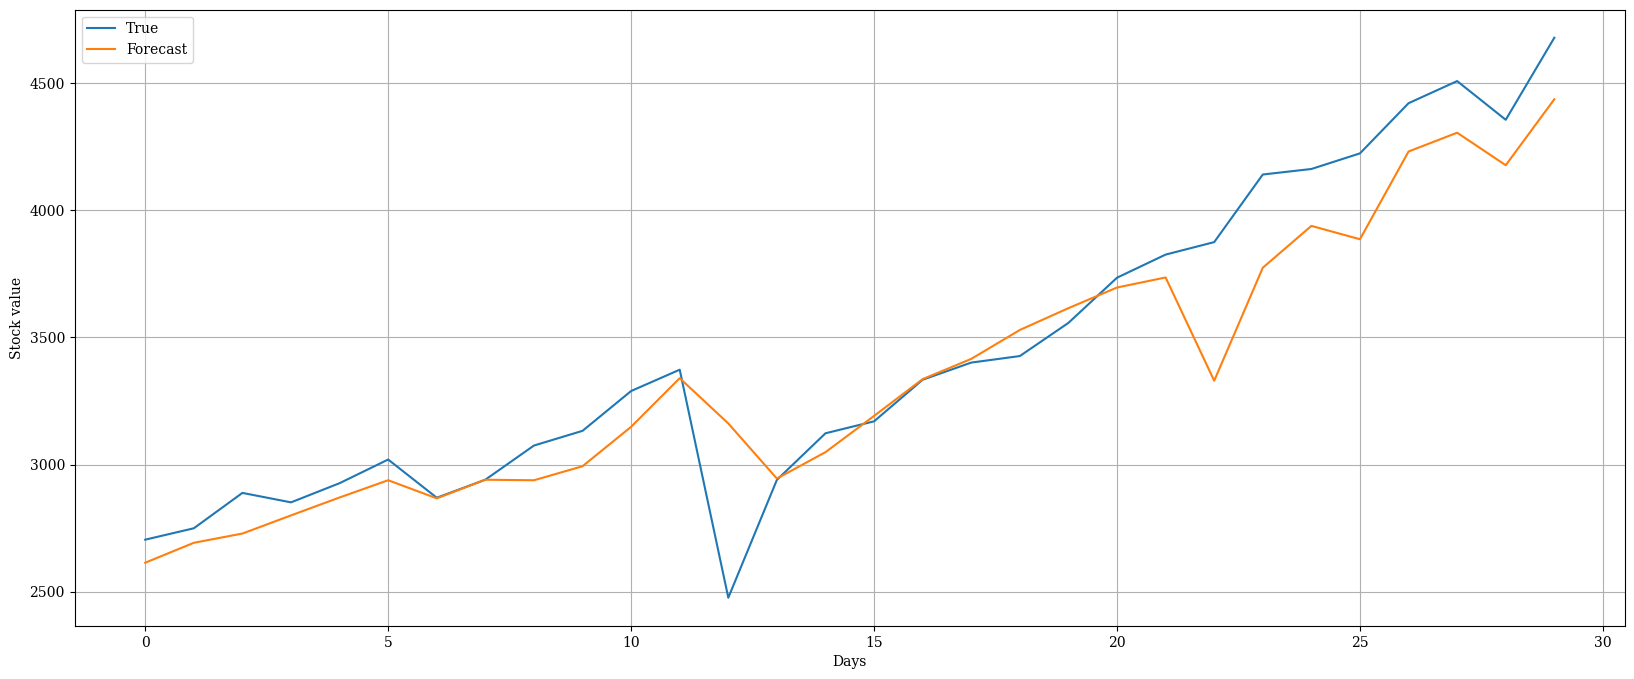

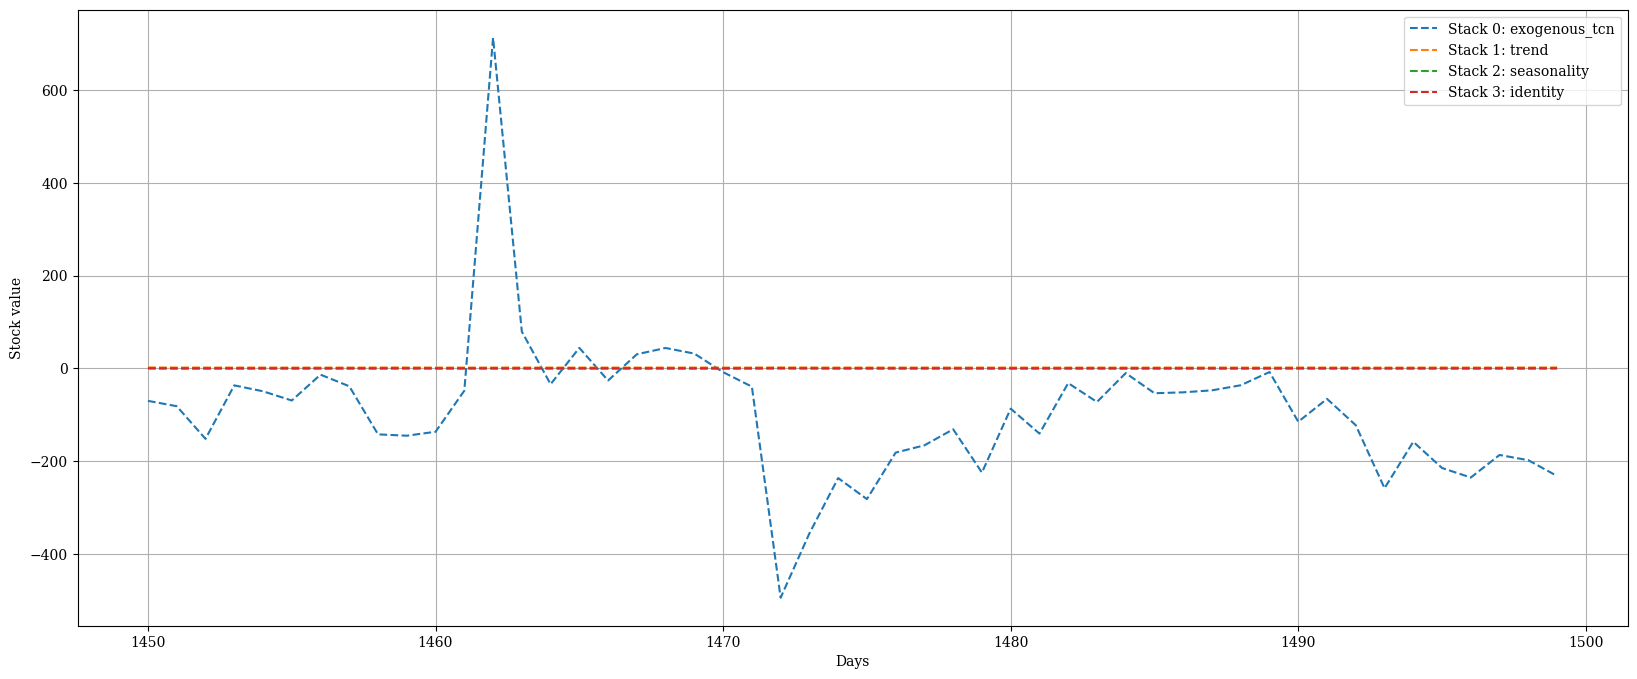

Case:  1
output_size = 2  and input_size = 252
list_exo =  ['^VIX', '^TNX']
Processing dataframes ...
Creating ts tensor ...


============================== Start fitting ==============================
Step: 50, Time: 1.303, Insample MSE: 1495.77246, Outsample MSE: 14273.00684
Step: 100, Time: 2.614, Insample MSE: 877.24493, Outsample MSE: 156071.87500
Step: 150, Time: 3.933, Insample MSE: 542.01404, Outsample MSE: 179551.79688
Step: 200, Time: 5.239, Insample MSE: 821.28949, Outsample MSE: 148347.32812
Step: 250, Time: 6.568, Insample MSE: 522.14758, Outsample MSE: 160775.21875
Step: 300, Time: 7.897, Insample MSE: 484.70914, Outsample MSE: 156463.75000
Step: 350, Time: 9.261, Insample MSE: 417.33603, Outsample MSE: 127829.12500
Step: 400, Time: 10.561, Insample MSE: 350.05045, Outsample MSE: 131280.68750
Step: 450, Time: 11.878, Insample MSE: 351.99329, Outsample MSE: 116042.34375
Step: 500, Time: 13.175, Insample MSE: 295.62711, Outsample MSE: 99988.50000
Step: 550, Time: 14.479, I

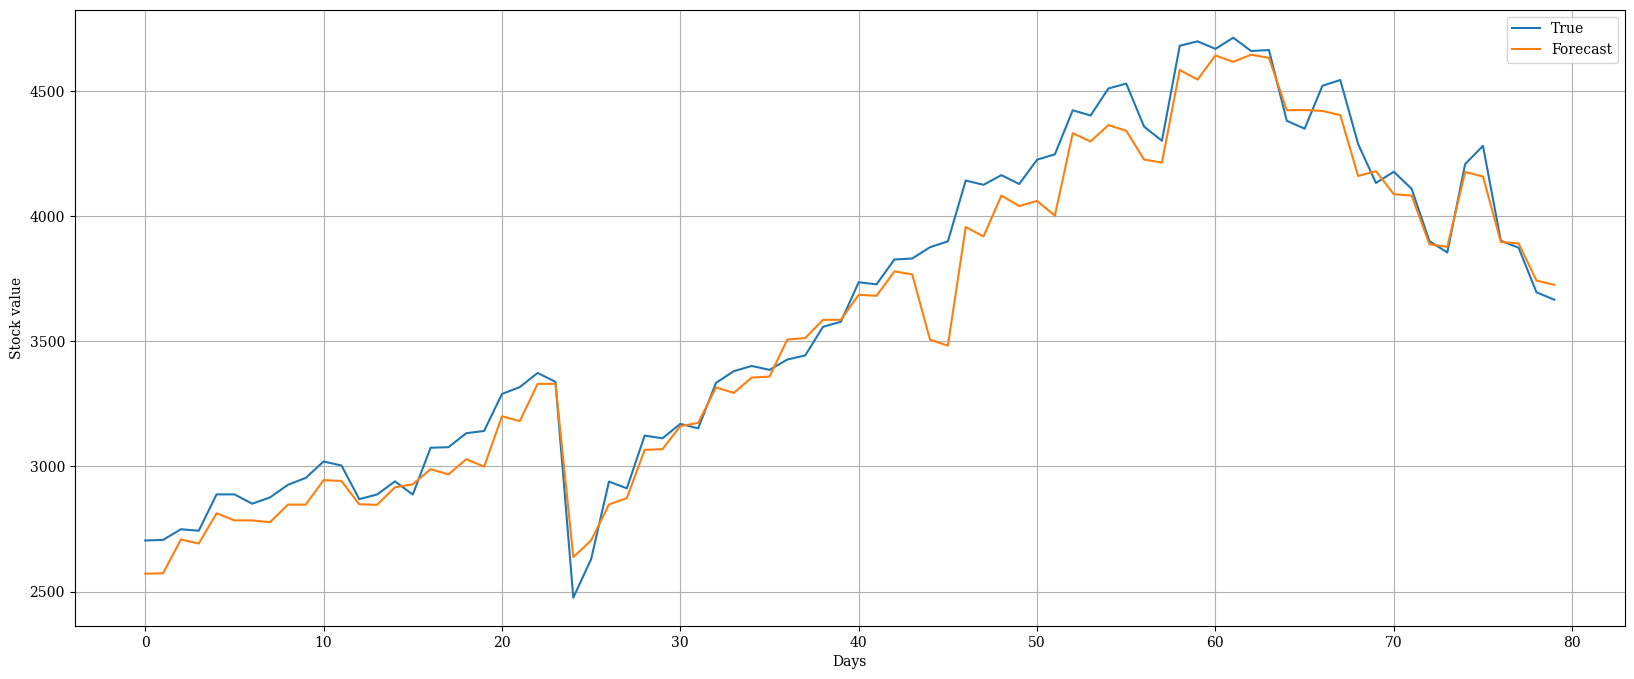

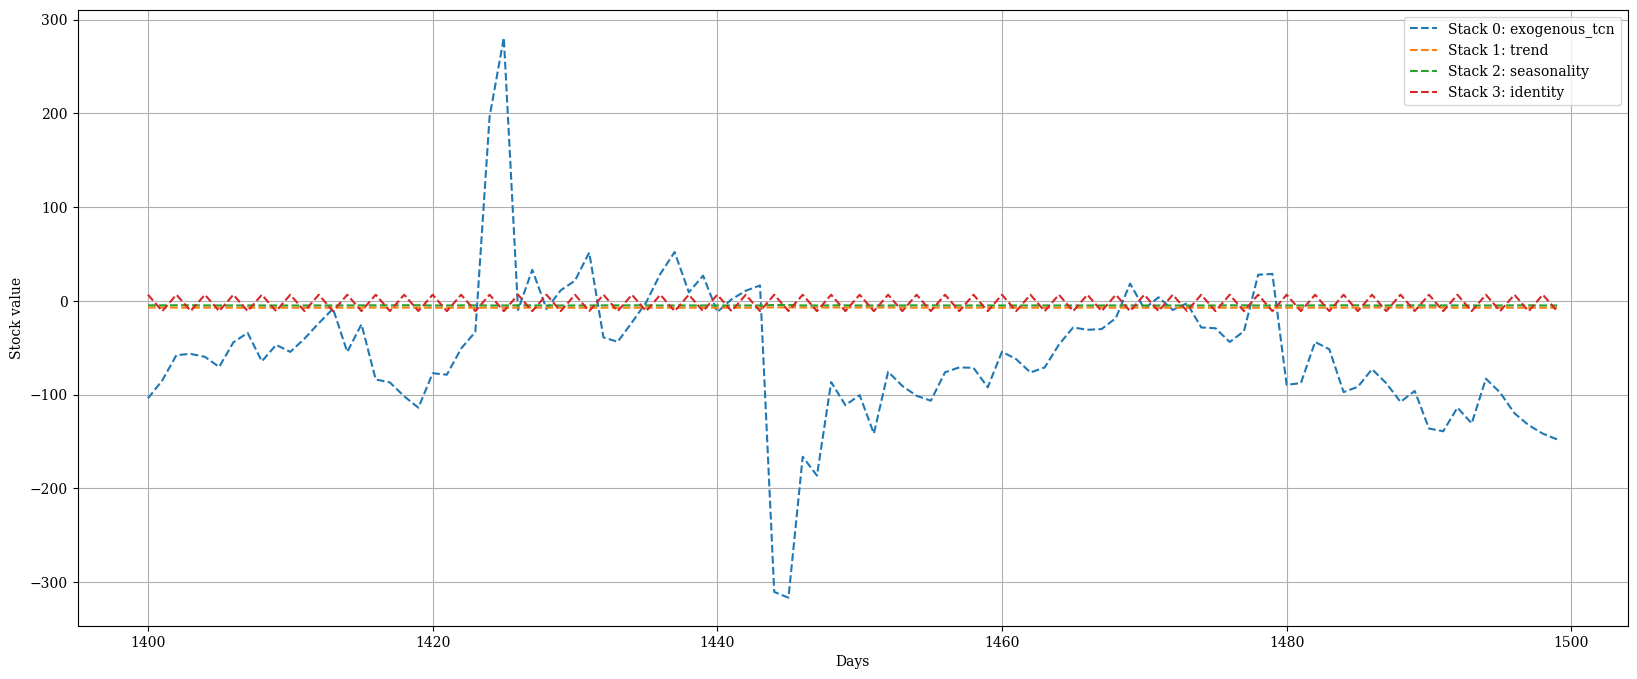

Case:  2
output_size = 3  and input_size = 252
list_exo =  ['^VIX', '^TNX']
Processing dataframes ...
Creating ts tensor ...


============================== Start fitting ==============================
Step: 50, Time: 1.477, Insample MSE: 1516.90320, Outsample MSE: 12542.18750
Step: 100, Time: 2.821, Insample MSE: 983.65234, Outsample MSE: 44135.79297
Step: 150, Time: 4.177, Insample MSE: 567.26825, Outsample MSE: 87268.64062
Step: 200, Time: 5.472, Insample MSE: 456.33273, Outsample MSE: 86780.81250
Step: 250, Time: 6.786, Insample MSE: 492.78064, Outsample MSE: 97840.72656
Step: 300, Time: 8.094, Insample MSE: 462.08768, Outsample MSE: 92074.10156
Step: 350, Time: 9.413, Insample MSE: 404.26764, Outsample MSE: 100018.34375
Step: 400, Time: 10.740, Insample MSE: 507.72412, Outsample MSE: 84111.80469
Step: 450, Time: 12.125, Insample MSE: 282.20868, Outsample MSE: 86672.10156
Step: 500, Time: 13.428, Insample MSE: 289.02487, Outsample MSE: 89216.39844
Step: 550, Time: 14.738, Insample

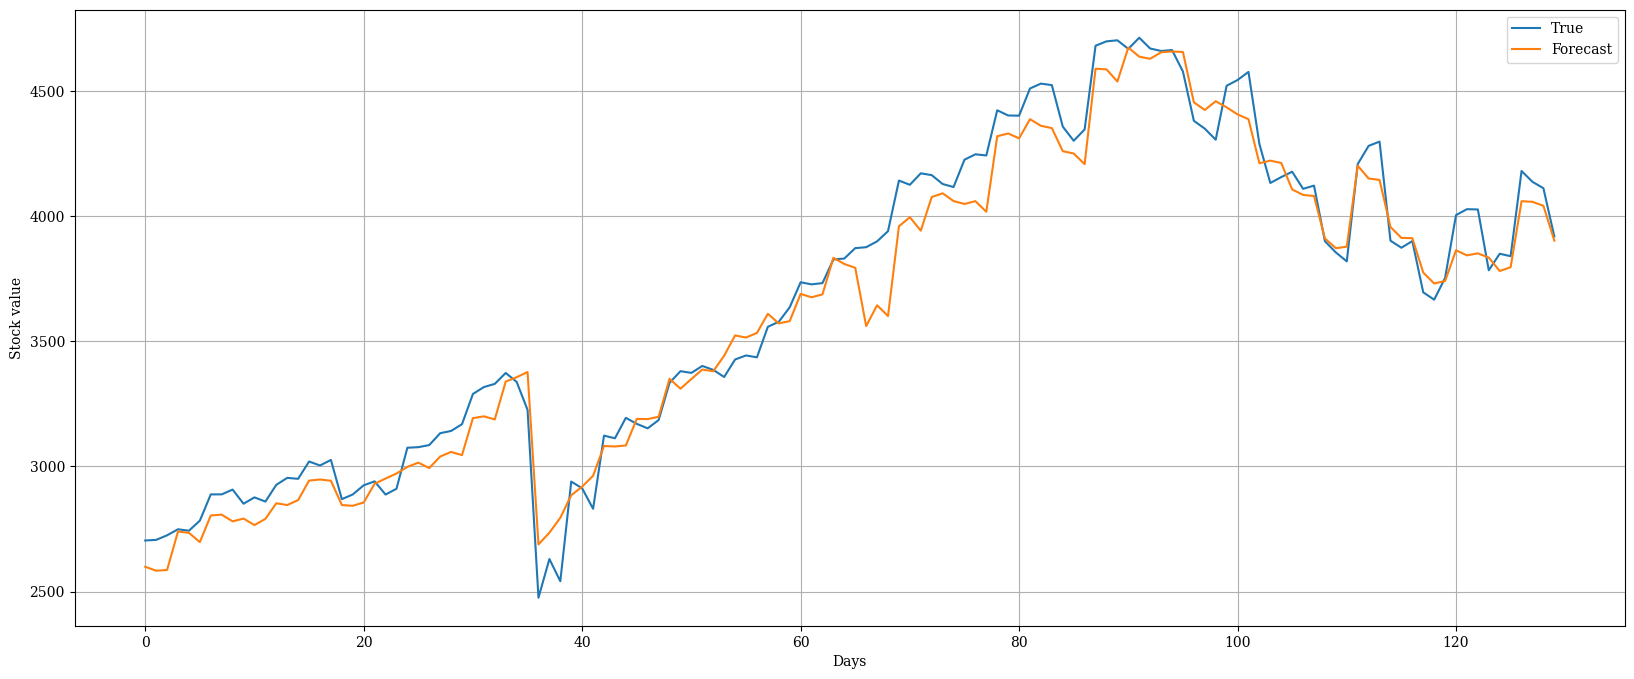

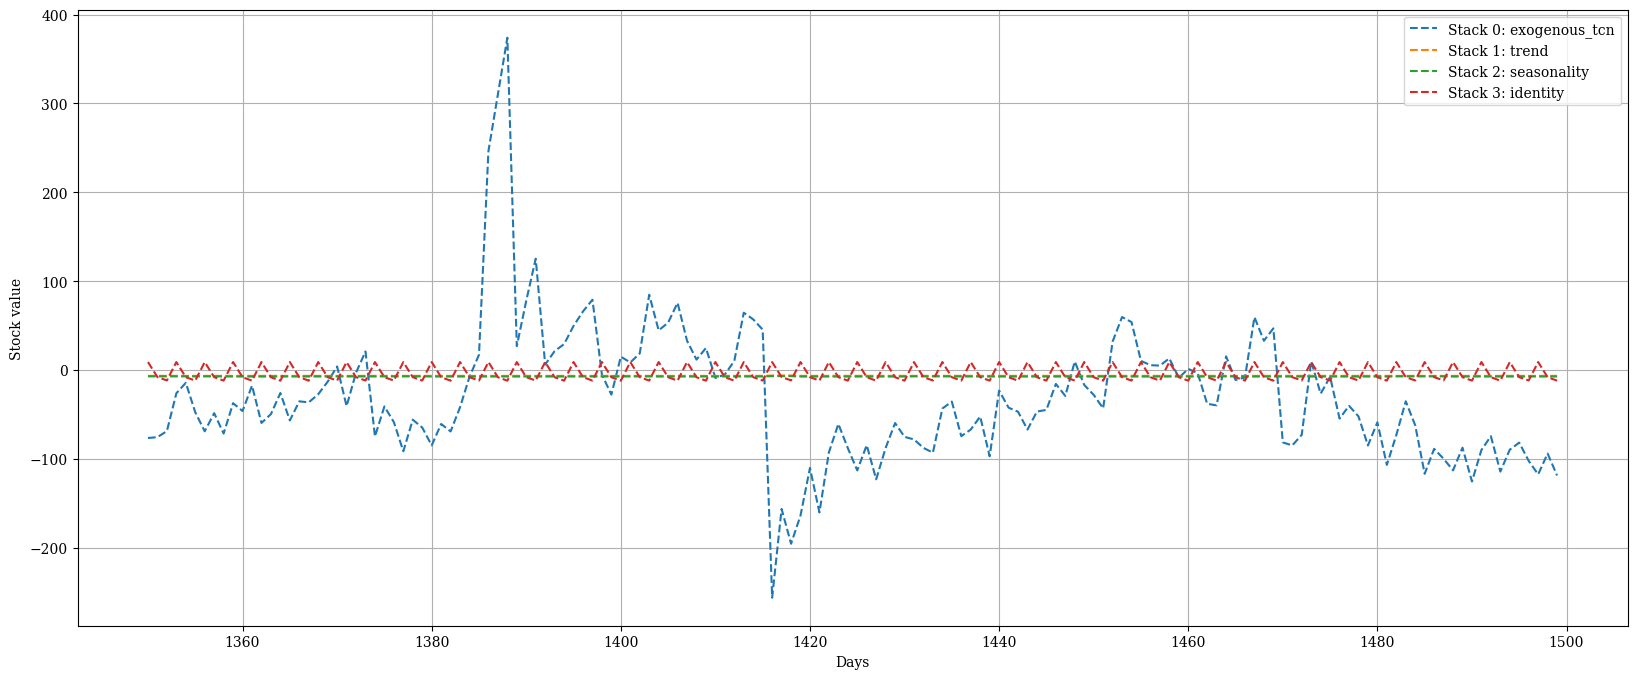

Case:  3
output_size = 4  and input_size = 252
list_exo =  ['^VIX', '^TNX']
Processing dataframes ...
Creating ts tensor ...


============================== Start fitting ==============================
Step: 50, Time: 1.759, Insample MSE: 1948.03320, Outsample MSE: 16631.86133
Step: 100, Time: 3.493, Insample MSE: 883.15656, Outsample MSE: 98885.24219
Step: 150, Time: 5.223, Insample MSE: 730.64624, Outsample MSE: 96943.13281
Step: 200, Time: 6.966, Insample MSE: 509.36157, Outsample MSE: 94430.96875
Step: 250, Time: 8.742, Insample MSE: 531.78900, Outsample MSE: 106115.35156
Step: 300, Time: 10.379, Insample MSE: 506.13425, Outsample MSE: 100373.14062
Step: 350, Time: 12.013, Insample MSE: 437.33176, Outsample MSE: 94720.68750
Step: 400, Time: 13.622, Insample MSE: 349.25949, Outsample MSE: 89966.17188
Step: 450, Time: 15.283, Insample MSE: 337.25211, Outsample MSE: 85126.90625
Step: 500, Time: 16.928, Insample MSE: 321.44183, Outsample MSE: 86509.23438
Step: 550, Time: 18.592, Insam

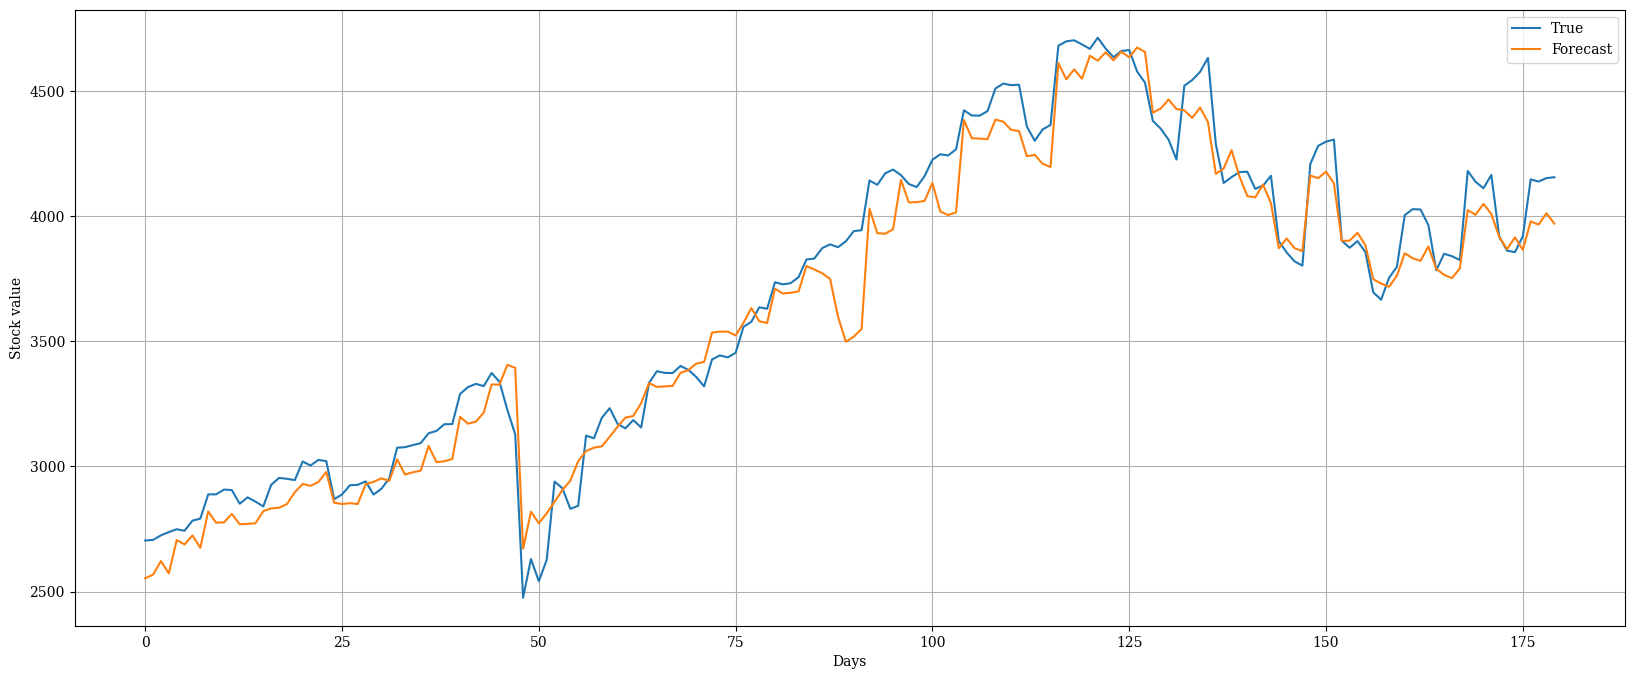

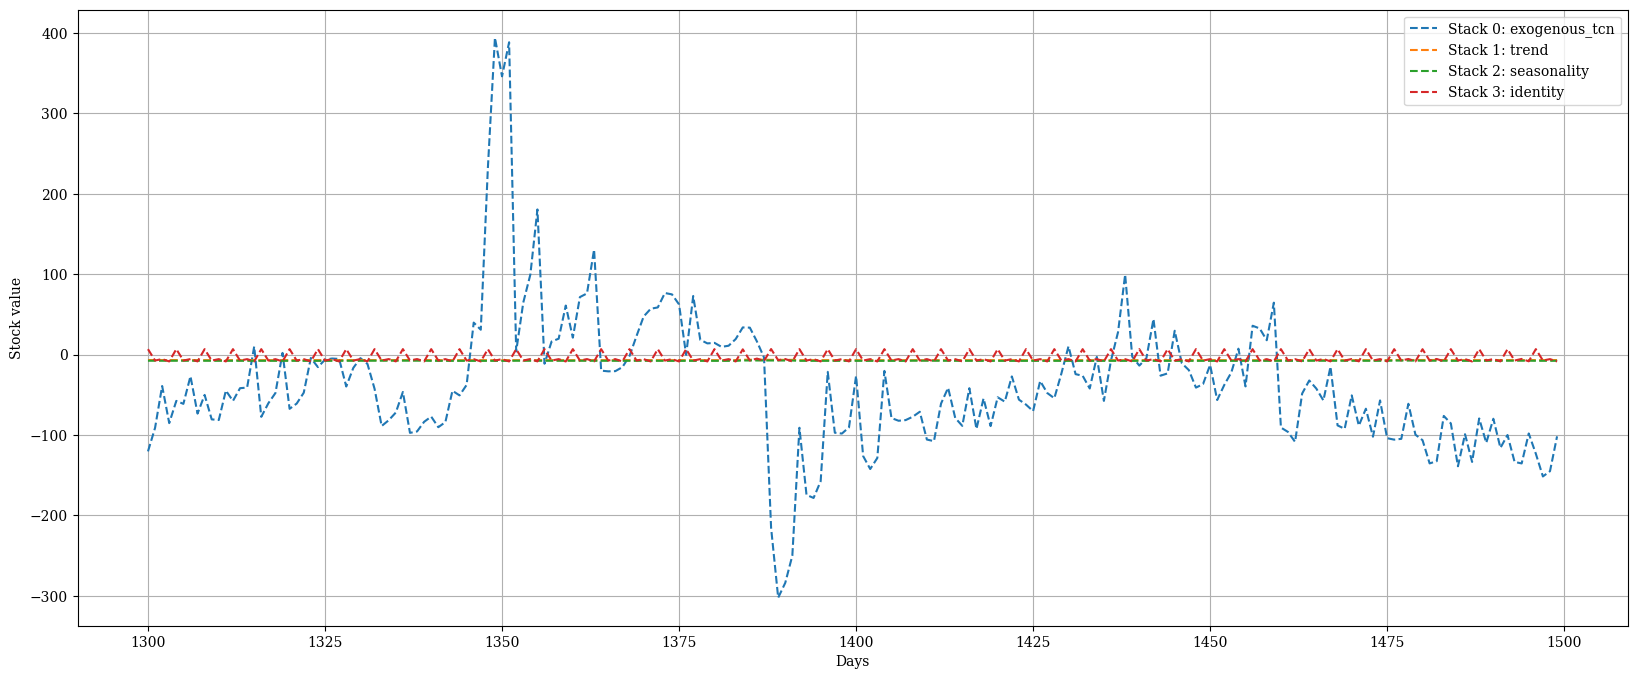

Case:  4
output_size = 5  and input_size = 250
list_exo =  ['^VIX', '^TNX']
Processing dataframes ...
Creating ts tensor ...


============================== Start fitting ==============================
Step: 50, Time: 2.076, Insample MSE: 1611.31494, Outsample MSE: 13167.84375
Step: 100, Time: 3.981, Insample MSE: 827.38489, Outsample MSE: 38614.83984
Step: 150, Time: 5.990, Insample MSE: 738.16473, Outsample MSE: 60148.00781
Step: 200, Time: 7.694, Insample MSE: 806.73767, Outsample MSE: 49578.23828
Step: 250, Time: 9.427, Insample MSE: 440.40652, Outsample MSE: 54513.73047
Step: 300, Time: 11.195, Insample MSE: 418.81589, Outsample MSE: 58510.23047
Step: 350, Time: 12.979, Insample MSE: 524.62860, Outsample MSE: 57589.35547
Step: 400, Time: 14.787, Insample MSE: 462.53162, Outsample MSE: 58890.60156
Step: 450, Time: 16.548, Insample MSE: 564.91632, Outsample MSE: 63140.76172
Step: 500, Time: 18.326, Insample MSE: 665.18542, Outsample MSE: 55054.89453
Step: 550, Time: 20.104, Insampl

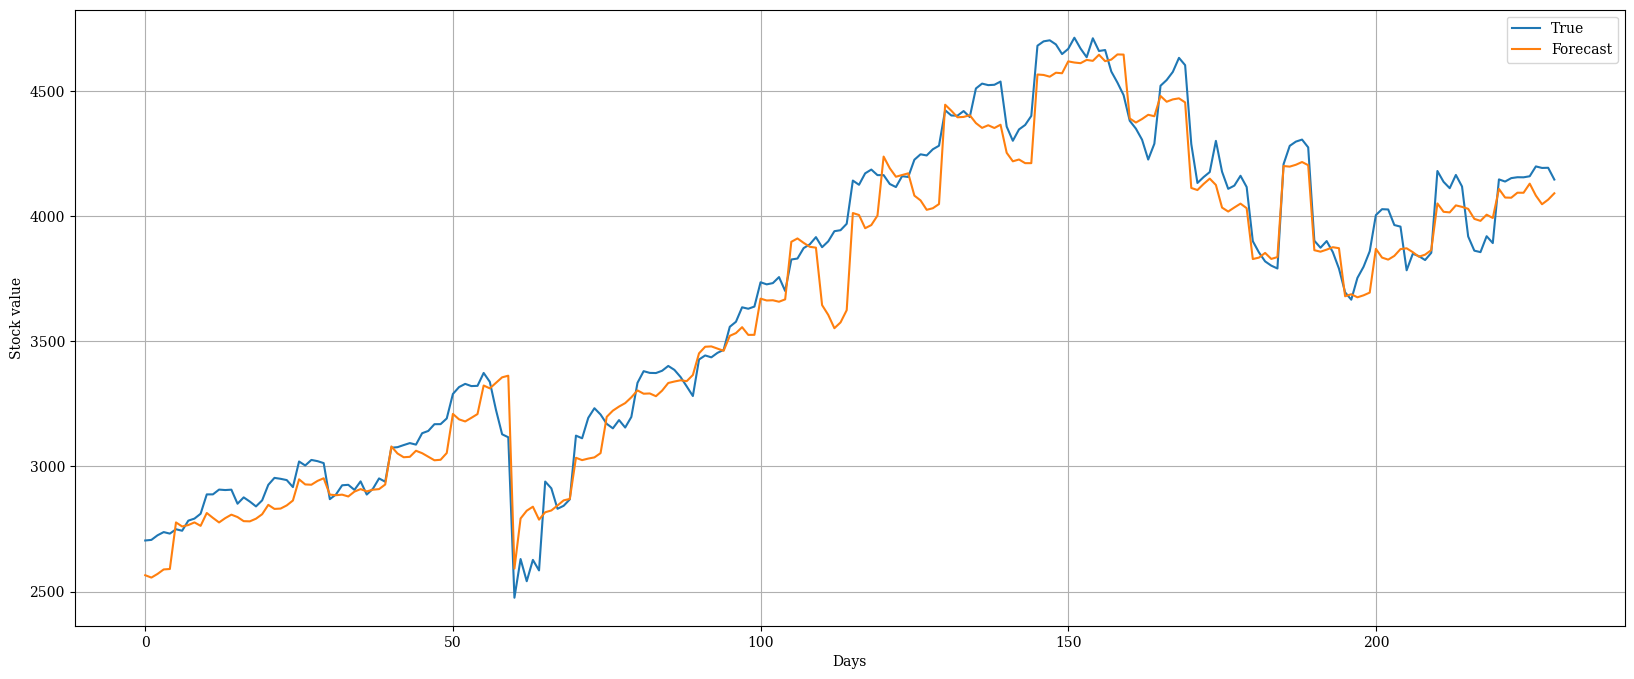

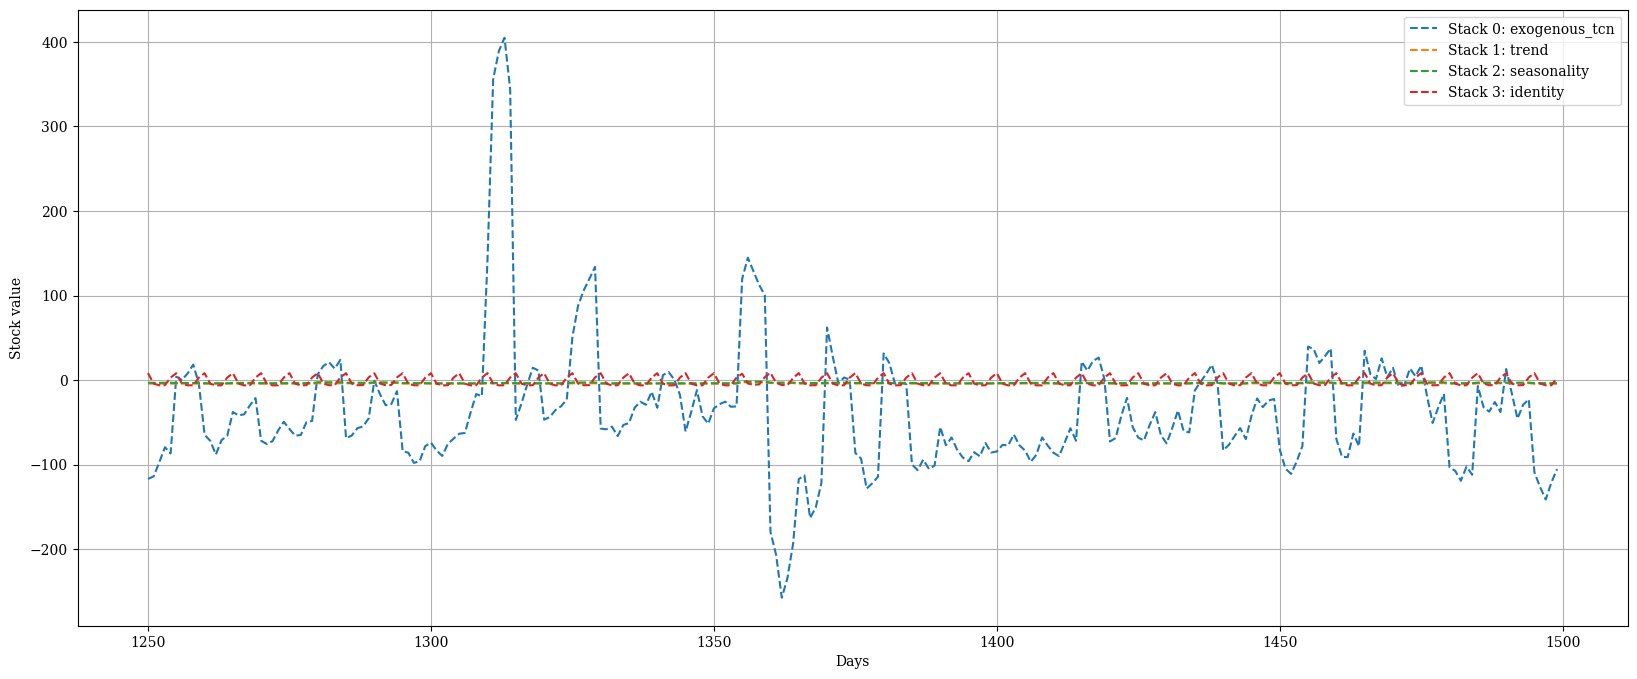

In [28]:
list_stacks = ['exogenous_tcn']+['trend']+['seasonality']+['identity']
val_loss='MSE'
loss='MSE'
#input_size_multiplier_values = [i for i in range()]
#output_size_values = [i for i in range(1,14)]

list_size = [(1,252), (2,126), (3,84), (4,63), (5,50)]
k = 0

for (output_size, input_size_multiplier)  in list_size:
            print(80*'=')
            print('Case: ', k)
            print(f'output_size = {output_size}  and input_size = {input_size_multiplier*output_size}')

            model, train_loader, val_loader = training(df, list_exo, loss=loss, val_loss=val_loss, input_size_multiplier=input_size_multiplier, output_size=output_size, list_stacks = list_stacks)

            y_true, y_hat, block_forecast, outsample_masks_ = predict_nbeats(model, val_loader, decomposition = True)
            k+=1
            print(80*'=')

### Impact of the stack types

Different stack combinaisons

Case:  0 Stack types considered: ['exogenous_tcn']
list_exo =  ['^VIX', '^TNX']
Processing dataframes ...
Creating ts tensor ...


============================== Start fitting ==============================
Step: 50, Time: 0.933, Insample MSE: 1791.64160, Outsample MSE: 5710.50293
Step: 100, Time: 1.881, Insample MSE: 1137.88367, Outsample MSE: 6556.61816
Step: 150, Time: 2.804, Insample MSE: 833.45441, Outsample MSE: 10139.25391
Step: 200, Time: 3.822, Insample MSE: 522.89618, Outsample MSE: 15941.54297
Step: 250, Time: 4.785, Insample MSE: 378.66052, Outsample MSE: 24954.42383
Step: 300, Time: 5.744, Insample MSE: 534.74774, Outsample MSE: 31069.10156
Step: 350, Time: 6.684, Insample MSE: 387.70322, Outsample MSE: 25703.62695
Step: 400, Time: 7.621, Insample MSE: 450.60989, Outsample MSE: 32649.03906
Step: 450, Time: 8.374, Insample MSE: 350.60132, Outsample MSE: 27373.10156
Step: 500, Time: 9.140, Insample MSE: 352.88760, Outsample MSE: 37516.58594
Step: 550, Time: 9.887, Insample M

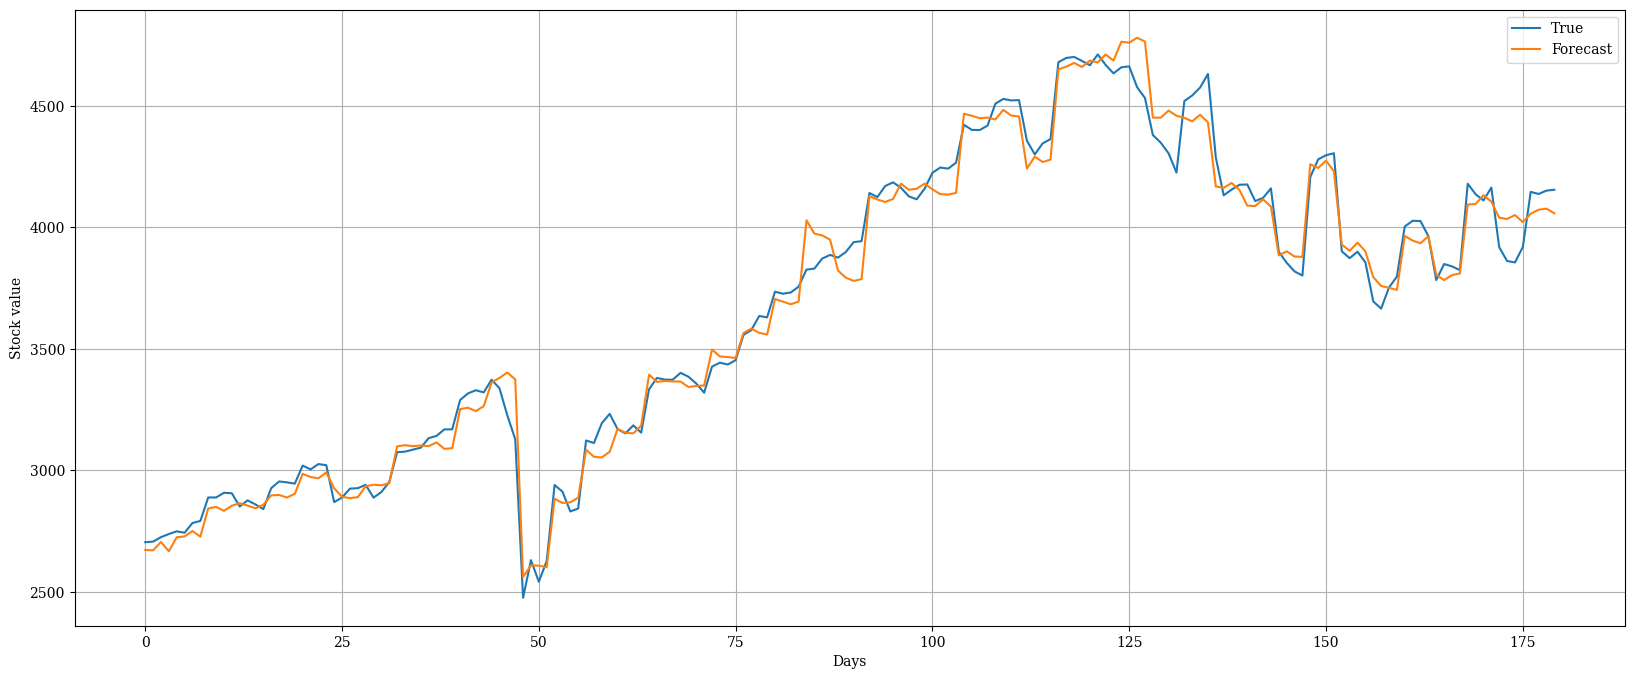

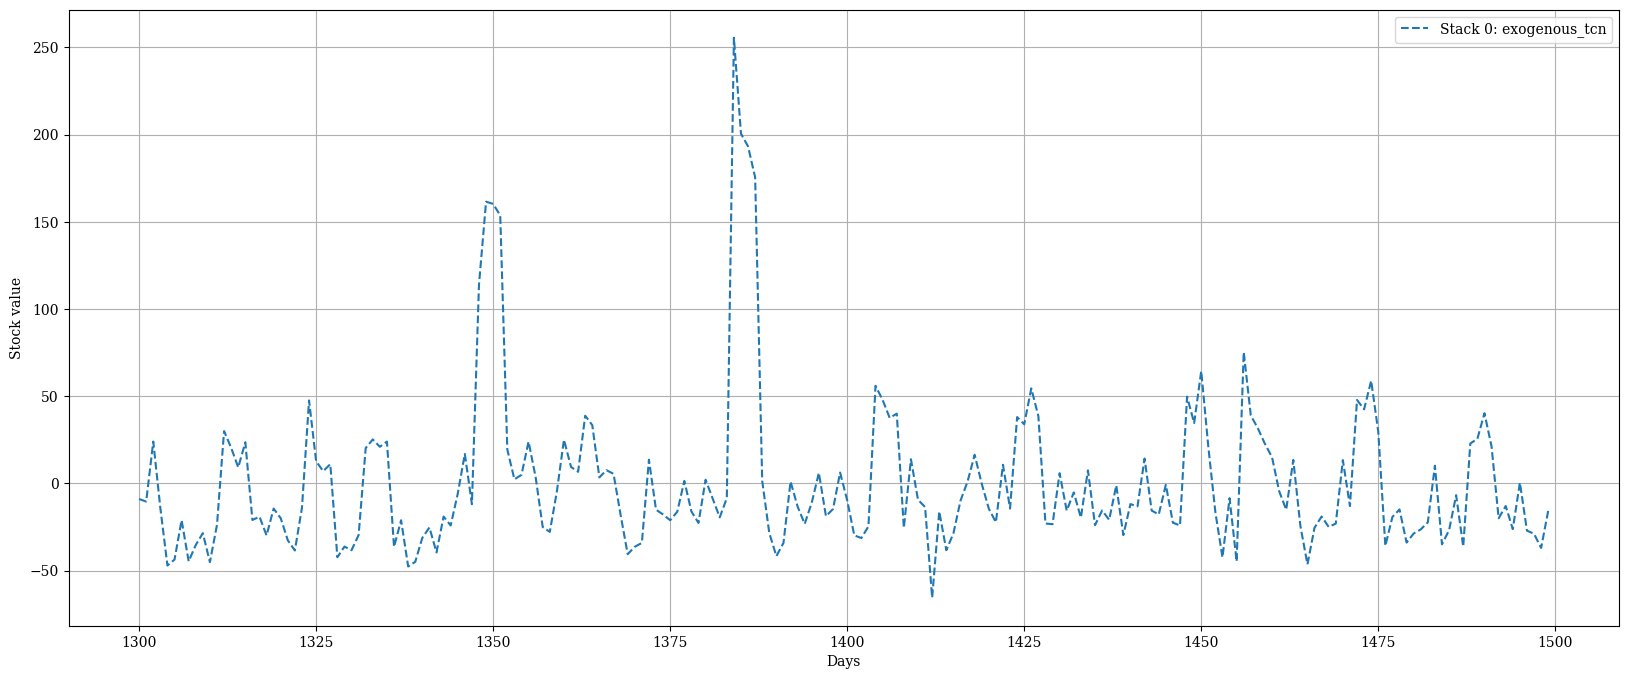

Case:  1 Stack types considered: ['trend']
list_exo =  ['^VIX', '^TNX']
Processing dataframes ...
Creating ts tensor ...


============================== Start fitting ==============================
Step: 50, Time: 0.228, Insample MSE: 3185.51196, Outsample MSE: 4268.80127
Step: 100, Time: 0.449, Insample MSE: 2566.32983, Outsample MSE: 4492.97363
Step: 150, Time: 0.671, Insample MSE: 2294.25366, Outsample MSE: 5371.66992
Step: 200, Time: 0.897, Insample MSE: 2007.97131, Outsample MSE: 6053.43799
Step: 250, Time: 1.120, Insample MSE: 2364.93604, Outsample MSE: 7504.16895
Step: 300, Time: 1.340, Insample MSE: 2057.89819, Outsample MSE: 6175.01562
Step: 350, Time: 1.561, Insample MSE: 2091.38281, Outsample MSE: 6154.93359
Step: 400, Time: 1.781, Insample MSE: 2000.59290, Outsample MSE: 6522.27832
Step: 450, Time: 2.010, Insample MSE: 1949.55554, Outsample MSE: 6315.20703
Step: 500, Time: 2.231, Insample MSE: 1846.79980, Outsample MSE: 6439.74512
Step: 550, Time: 2.504, Insample MSE: 1998

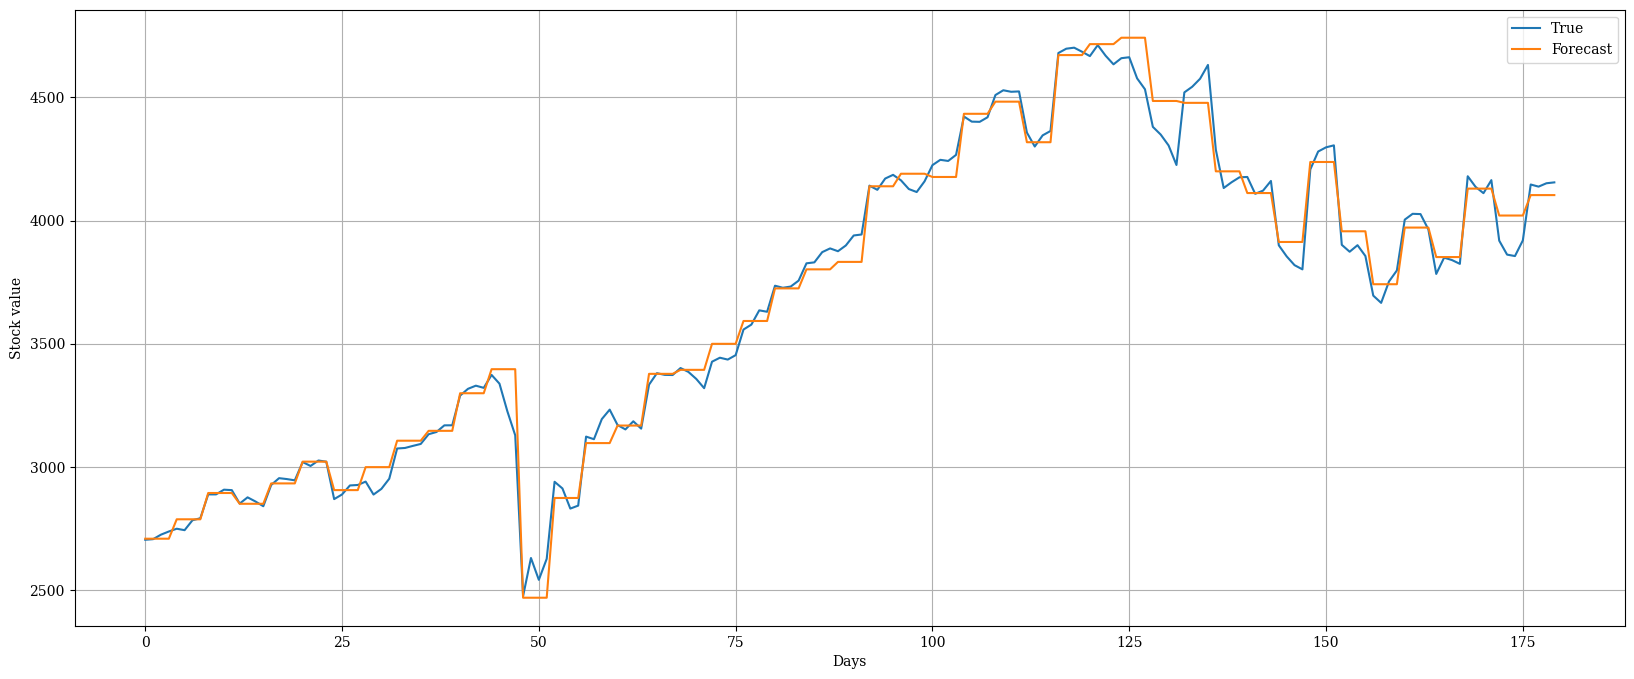

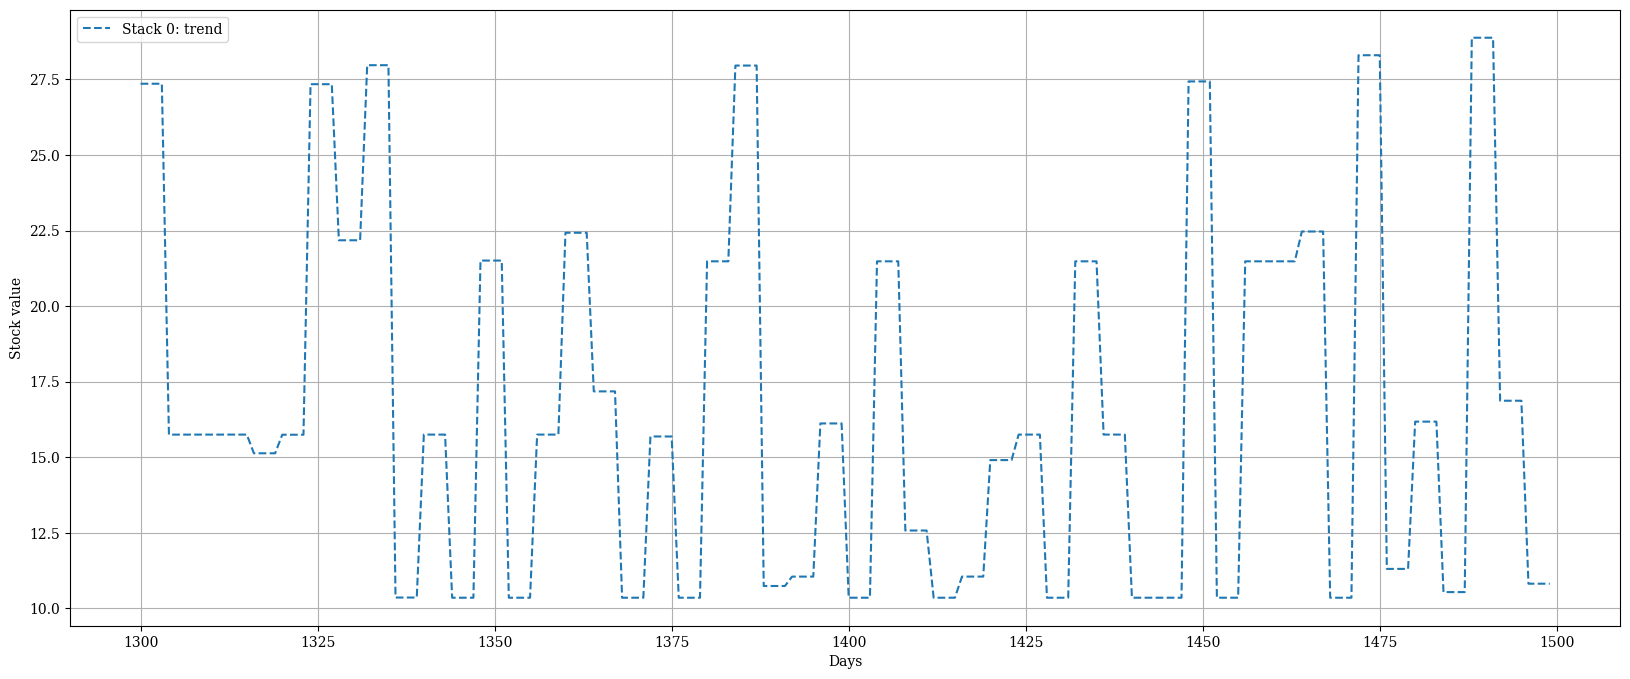

Case:  2 Stack types considered: ['seasonality']
list_exo =  ['^VIX', '^TNX']
Processing dataframes ...
Creating ts tensor ...


============================== Start fitting ==============================
Step: 50, Time: 0.239, Insample MSE: 3165.18164, Outsample MSE: 4276.85840
Step: 100, Time: 0.467, Insample MSE: 2797.66919, Outsample MSE: 4341.81445
Step: 150, Time: 0.692, Insample MSE: 2074.62622, Outsample MSE: 5087.60303
Step: 200, Time: 0.919, Insample MSE: 1709.59216, Outsample MSE: 7060.31348
Step: 250, Time: 1.145, Insample MSE: 1594.84338, Outsample MSE: 7510.72852
Step: 300, Time: 1.380, Insample MSE: 1373.45032, Outsample MSE: 9230.61914
Step: 350, Time: 1.605, Insample MSE: 1553.99084, Outsample MSE: 9351.48633
Step: 400, Time: 1.841, Insample MSE: 1599.19739, Outsample MSE: 8533.16895
Step: 450, Time: 2.065, Insample MSE: 1426.39294, Outsample MSE: 9199.39160
Step: 500, Time: 2.296, Insample MSE: 1455.48694, Outsample MSE: 9351.68066
Step: 550, Time: 2.521, Insample MSE

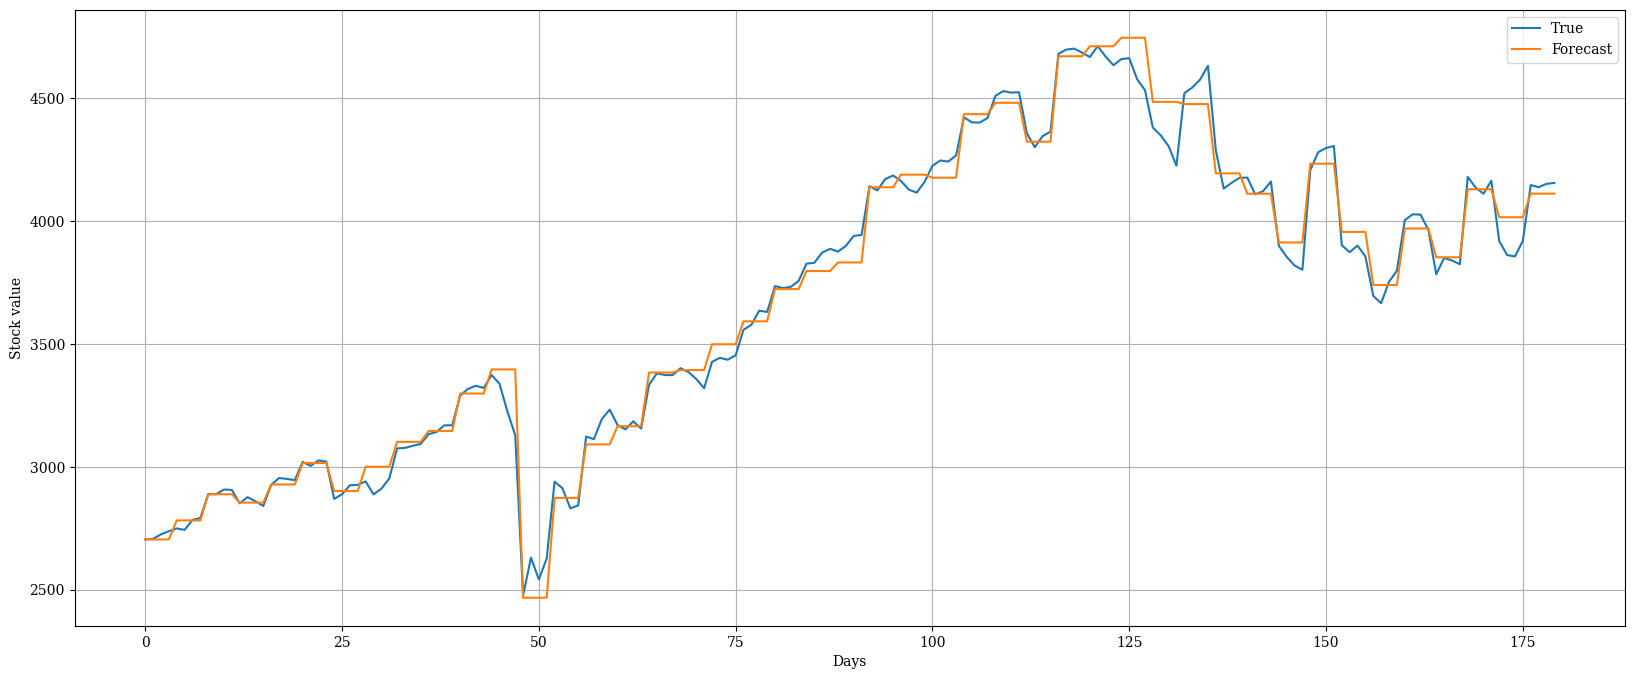

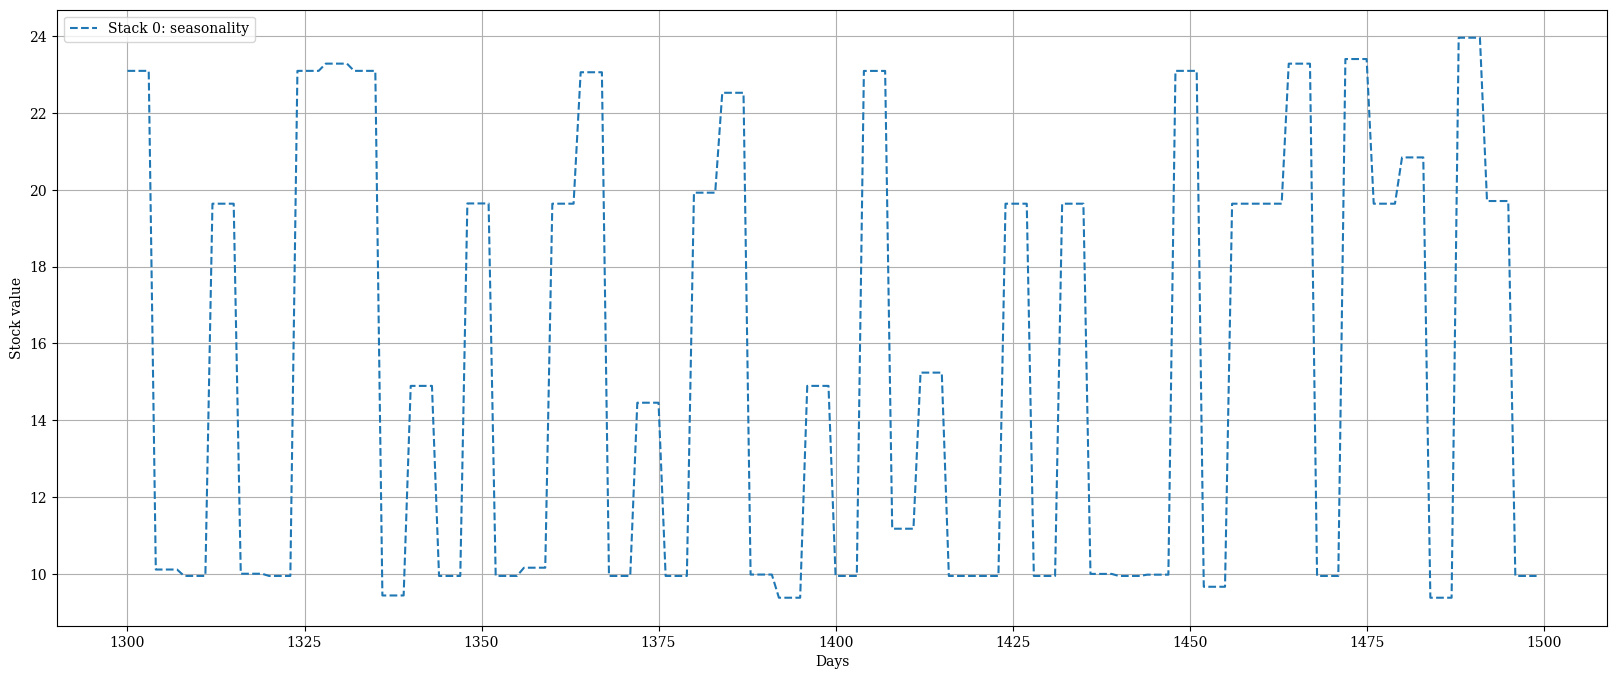

Case:  3 Stack types considered: ['identity']
list_exo =  ['^VIX', '^TNX']
Processing dataframes ...
Creating ts tensor ...


============================== Start fitting ==============================
Step: 50, Time: 0.229, Insample MSE: 3307.12427, Outsample MSE: 4345.59521
Step: 100, Time: 0.452, Insample MSE: 2856.22363, Outsample MSE: 4427.30322
Step: 150, Time: 0.677, Insample MSE: 2621.23511, Outsample MSE: 4676.67578
Step: 200, Time: 0.899, Insample MSE: 2196.23950, Outsample MSE: 4975.34668
Step: 250, Time: 1.122, Insample MSE: 1697.24084, Outsample MSE: 6371.56201
Step: 300, Time: 1.343, Insample MSE: 1675.77478, Outsample MSE: 7757.55664
Step: 350, Time: 1.566, Insample MSE: 1827.98792, Outsample MSE: 8088.58691
Step: 400, Time: 1.789, Insample MSE: 1326.73804, Outsample MSE: 8670.05957
Step: 450, Time: 2.010, Insample MSE: 1294.78931, Outsample MSE: 9167.53027
Step: 500, Time: 2.232, Insample MSE: 1227.99451, Outsample MSE: 8137.74316
Step: 550, Time: 2.454, Insample MSE: 1

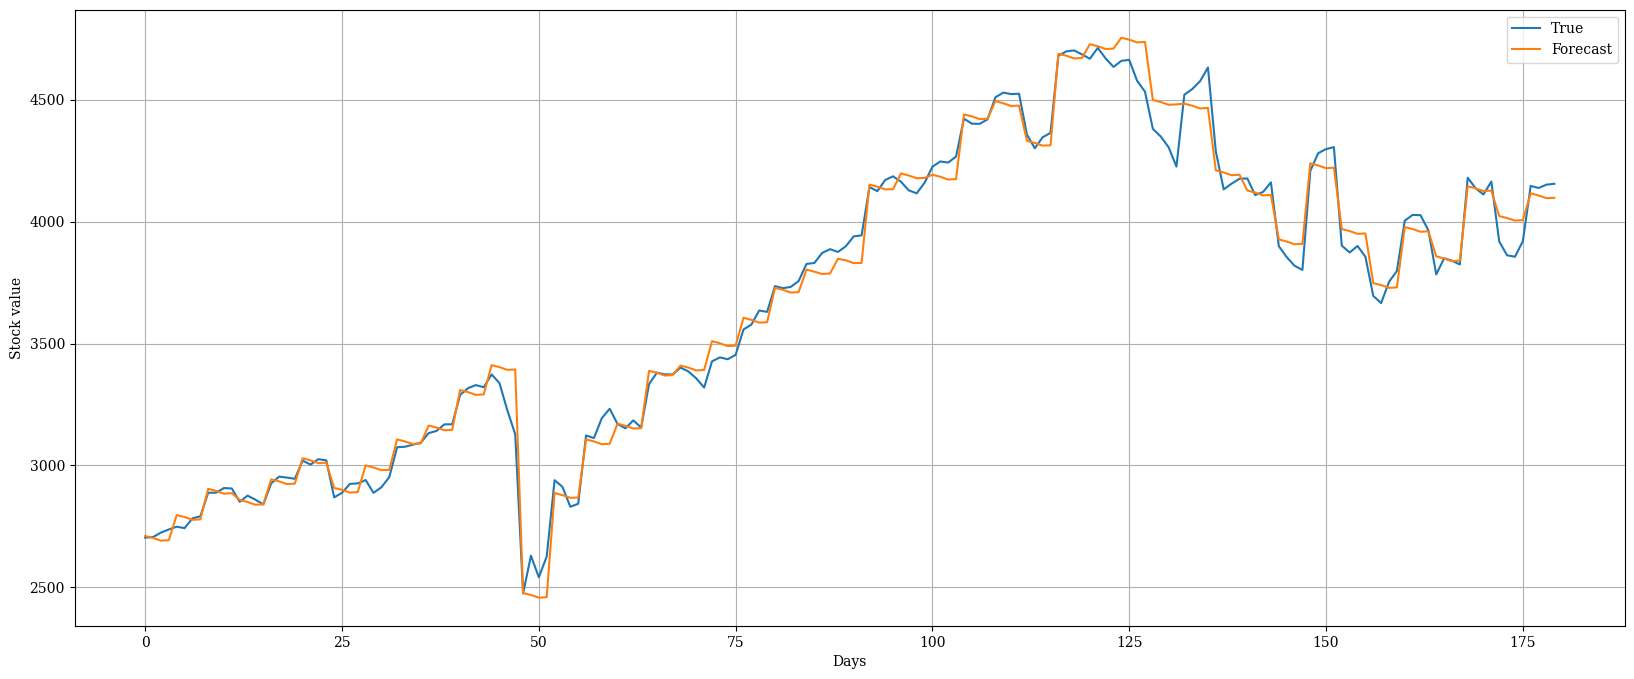

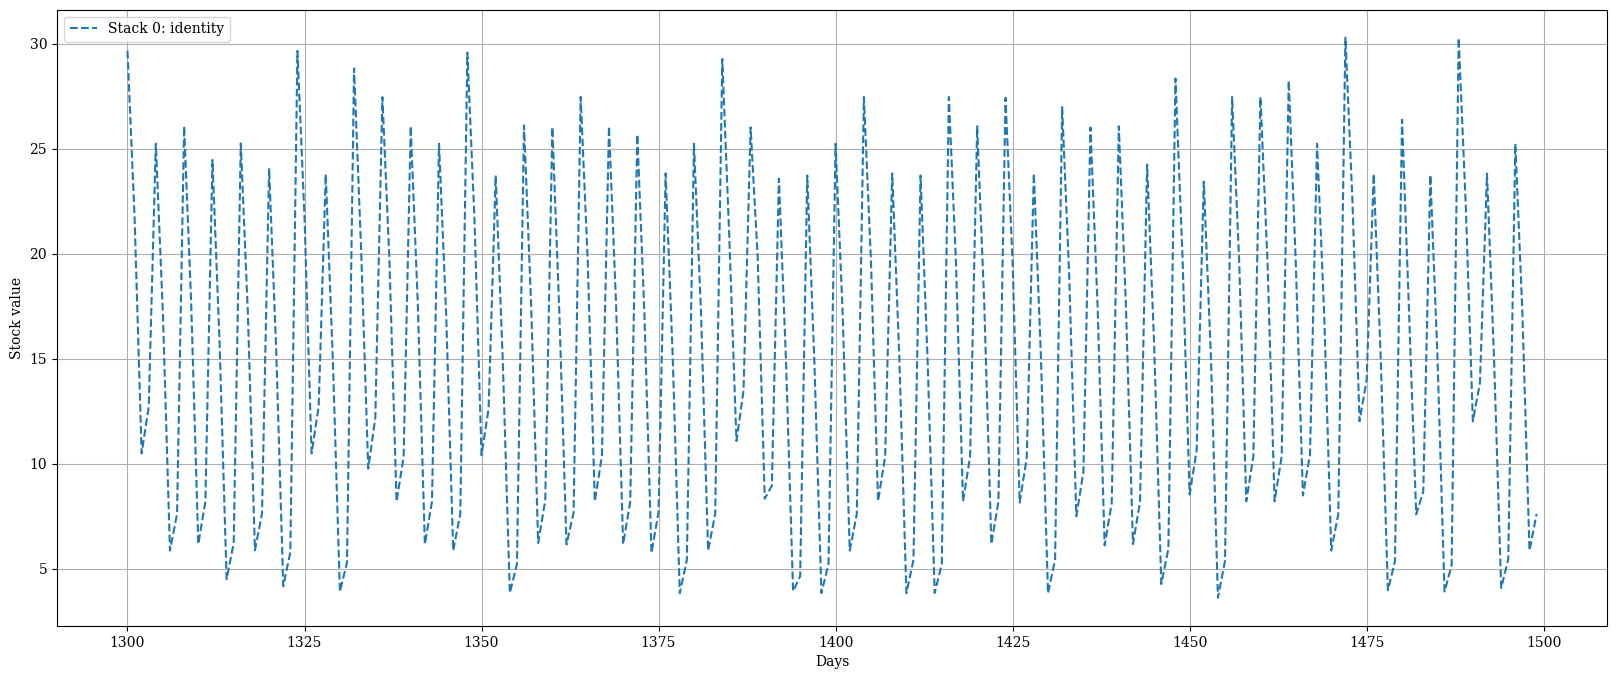

Case:  4 Stack types considered: ['exogenous_tcn', 'trend']
list_exo =  ['^VIX', '^TNX']
Processing dataframes ...
Creating ts tensor ...


============================== Start fitting ==============================
Step: 50, Time: 0.944, Insample MSE: 2189.23901, Outsample MSE: 5714.55469
Step: 100, Time: 1.869, Insample MSE: 1732.18213, Outsample MSE: 6053.90625
Step: 150, Time: 2.787, Insample MSE: 957.73022, Outsample MSE: 7644.13184
Step: 200, Time: 3.697, Insample MSE: 663.49323, Outsample MSE: 11754.28320
Step: 250, Time: 4.626, Insample MSE: 505.50952, Outsample MSE: 10479.13281
Step: 300, Time: 5.532, Insample MSE: 330.16187, Outsample MSE: 10981.15723
Step: 350, Time: 6.497, Insample MSE: 957.29126, Outsample MSE: 8918.75684
Step: 400, Time: 7.410, Insample MSE: 441.49451, Outsample MSE: 13526.93359
Step: 450, Time: 8.376, Insample MSE: 314.06549, Outsample MSE: 12580.47168
Step: 500, Time: 9.290, Insample MSE: 411.37048, Outsample MSE: 11133.00488
Step: 550, Time: 10.205, In

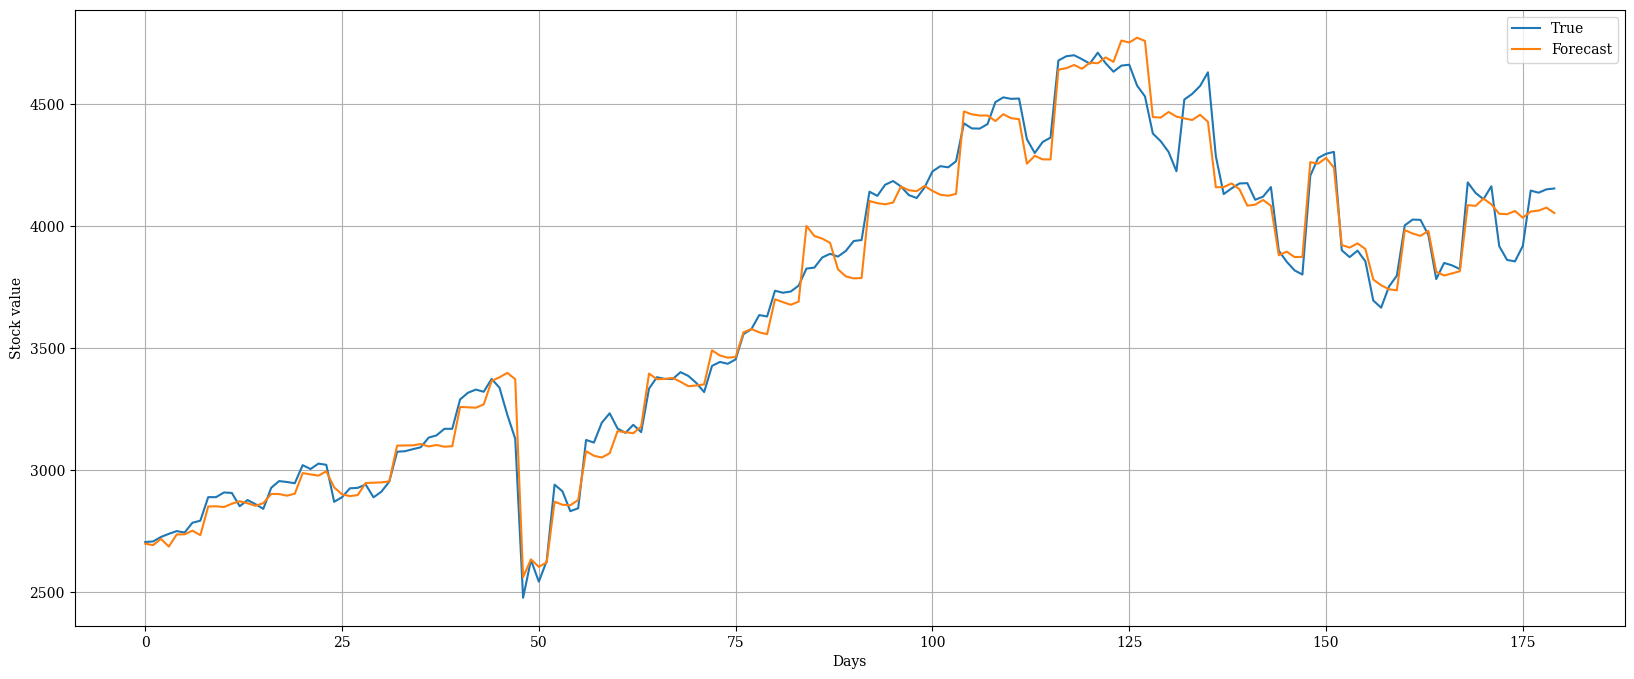

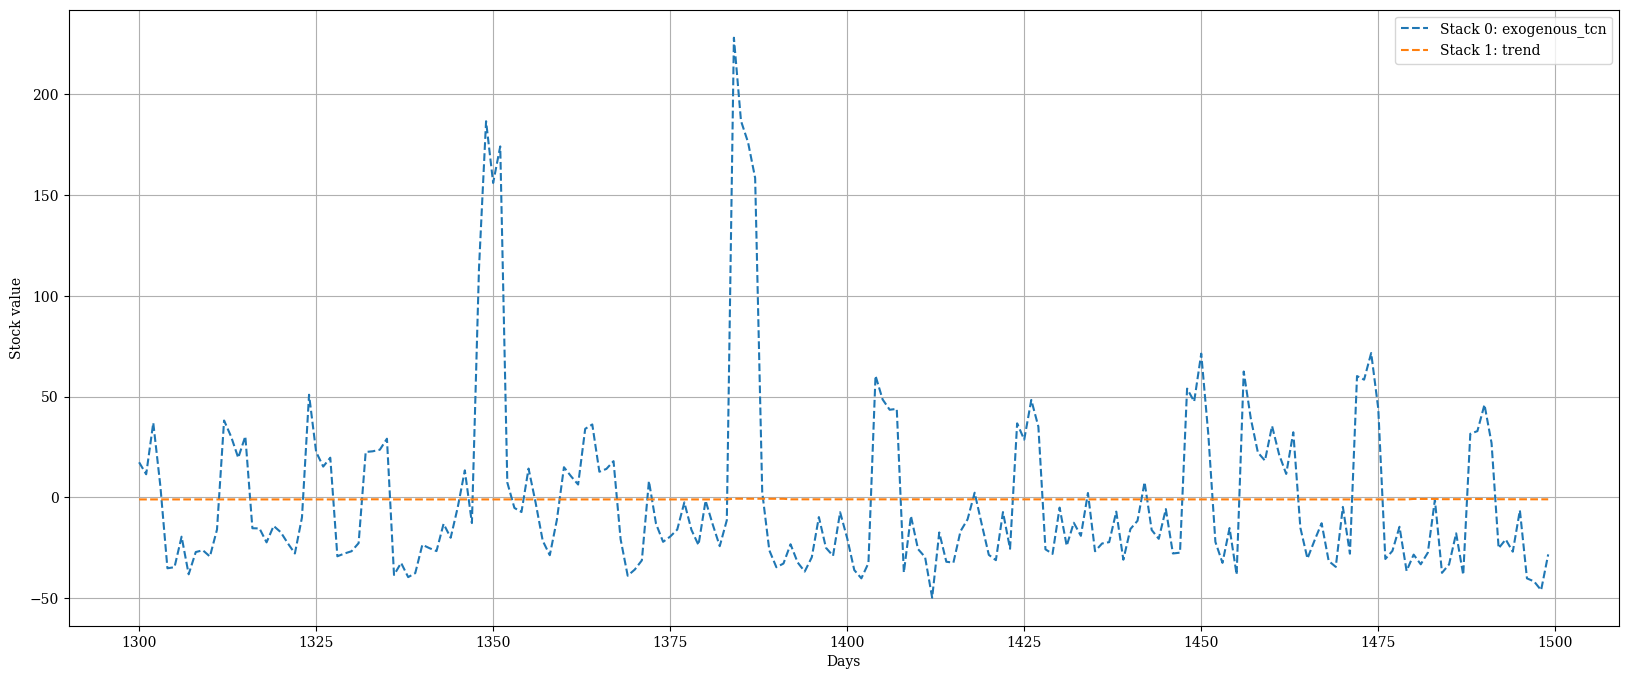

Case:  5 Stack types considered: ['exogenous_tcn', 'seasonality']
list_exo =  ['^VIX', '^TNX']
Processing dataframes ...
Creating ts tensor ...


============================== Start fitting ==============================
Step: 50, Time: 0.915, Insample MSE: 2212.34937, Outsample MSE: 6015.18262
Step: 100, Time: 1.844, Insample MSE: 1685.79700, Outsample MSE: 7545.90820
Step: 150, Time: 2.765, Insample MSE: 1180.83179, Outsample MSE: 6526.22754
Step: 200, Time: 3.708, Insample MSE: 664.86456, Outsample MSE: 7637.99609
Step: 250, Time: 4.733, Insample MSE: 633.00092, Outsample MSE: 8431.80078
Step: 300, Time: 5.695, Insample MSE: 560.89069, Outsample MSE: 9972.90625
Step: 350, Time: 6.684, Insample MSE: 542.30255, Outsample MSE: 15264.36621
Step: 400, Time: 7.633, Insample MSE: 431.84360, Outsample MSE: 15150.57324
Step: 450, Time: 8.575, Insample MSE: 389.42871, Outsample MSE: 17274.21484
Step: 500, Time: 9.568, Insample MSE: 398.47098, Outsample MSE: 13187.68555
Step: 550, Time: 10.48

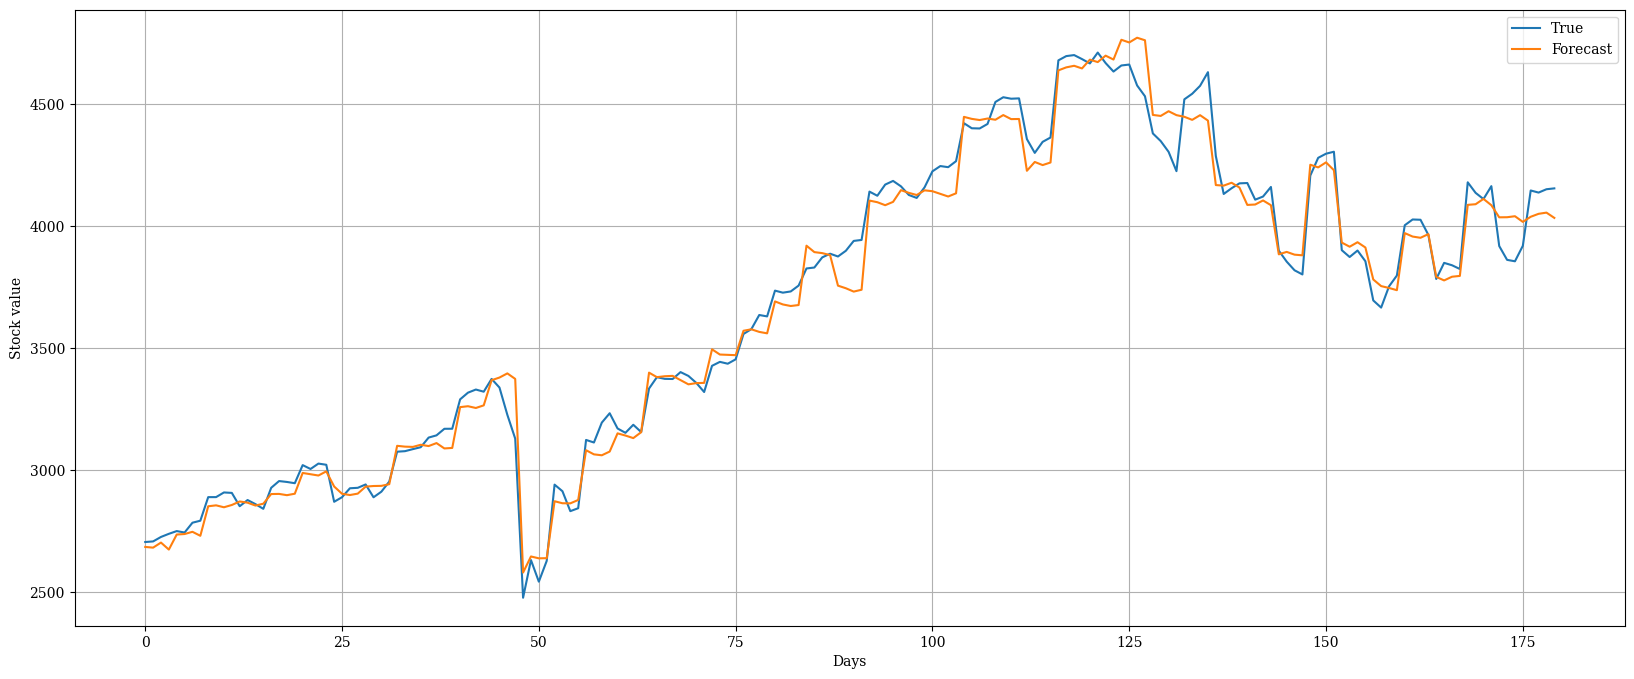

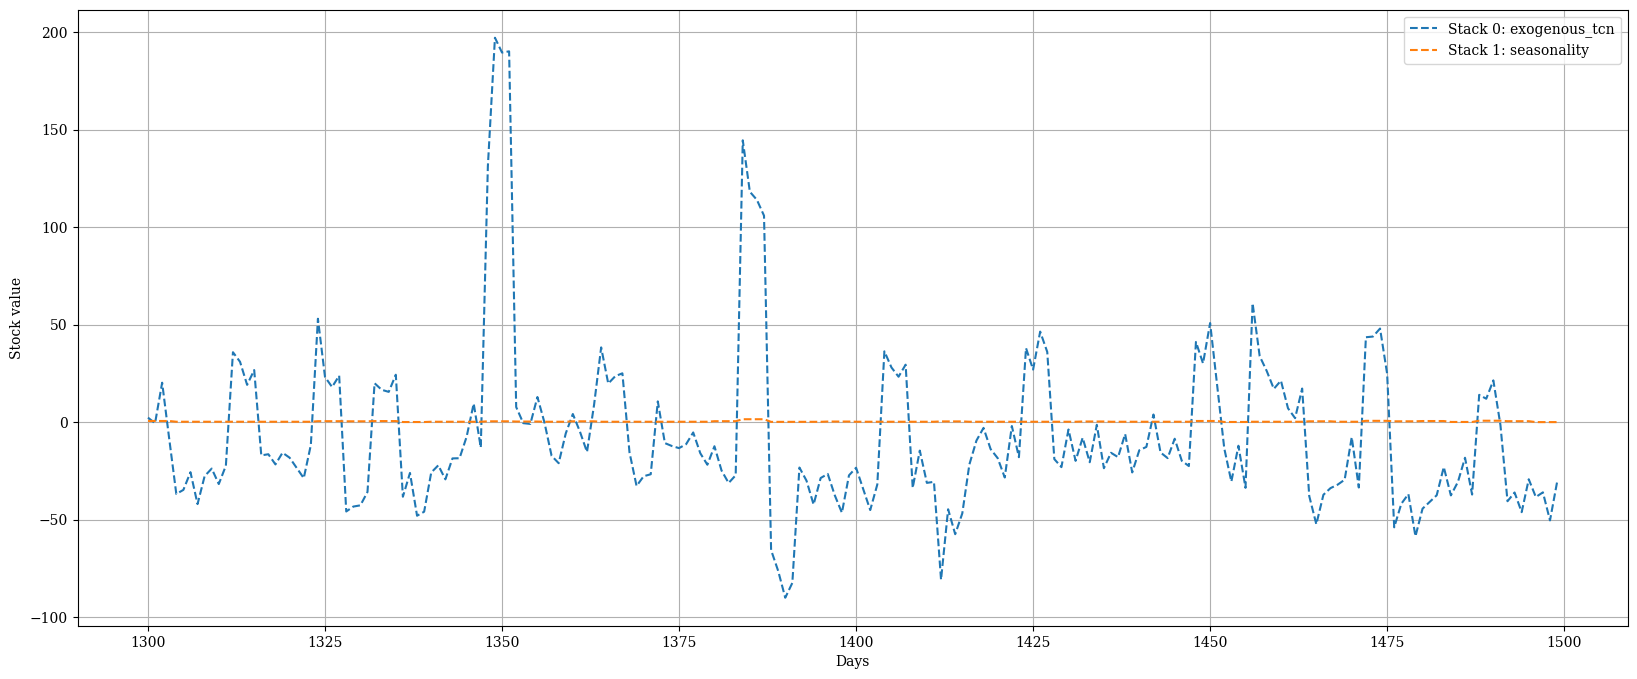

Case:  6 Stack types considered: ['exogenous_tcn', 'identity']
list_exo =  ['^VIX', '^TNX']
Processing dataframes ...
Creating ts tensor ...


============================== Start fitting ==============================
Step: 50, Time: 0.967, Insample MSE: 1755.48633, Outsample MSE: 6945.43848
Step: 100, Time: 1.980, Insample MSE: 1709.77185, Outsample MSE: 6864.32471
Step: 150, Time: 2.962, Insample MSE: 1057.76599, Outsample MSE: 7721.27148
Step: 200, Time: 3.928, Insample MSE: 560.82910, Outsample MSE: 15496.08887
Step: 250, Time: 4.911, Insample MSE: 534.30237, Outsample MSE: 29420.71289
Step: 300, Time: 5.903, Insample MSE: 392.43210, Outsample MSE: 35066.08594
Step: 350, Time: 6.894, Insample MSE: 331.96445, Outsample MSE: 35750.37500
Step: 400, Time: 7.883, Insample MSE: 303.96982, Outsample MSE: 49350.08594
Step: 450, Time: 8.896, Insample MSE: 352.62589, Outsample MSE: 54497.42969
Step: 500, Time: 9.893, Insample MSE: 258.43448, Outsample MSE: 64816.98438
Step: 550, Time: 10.88

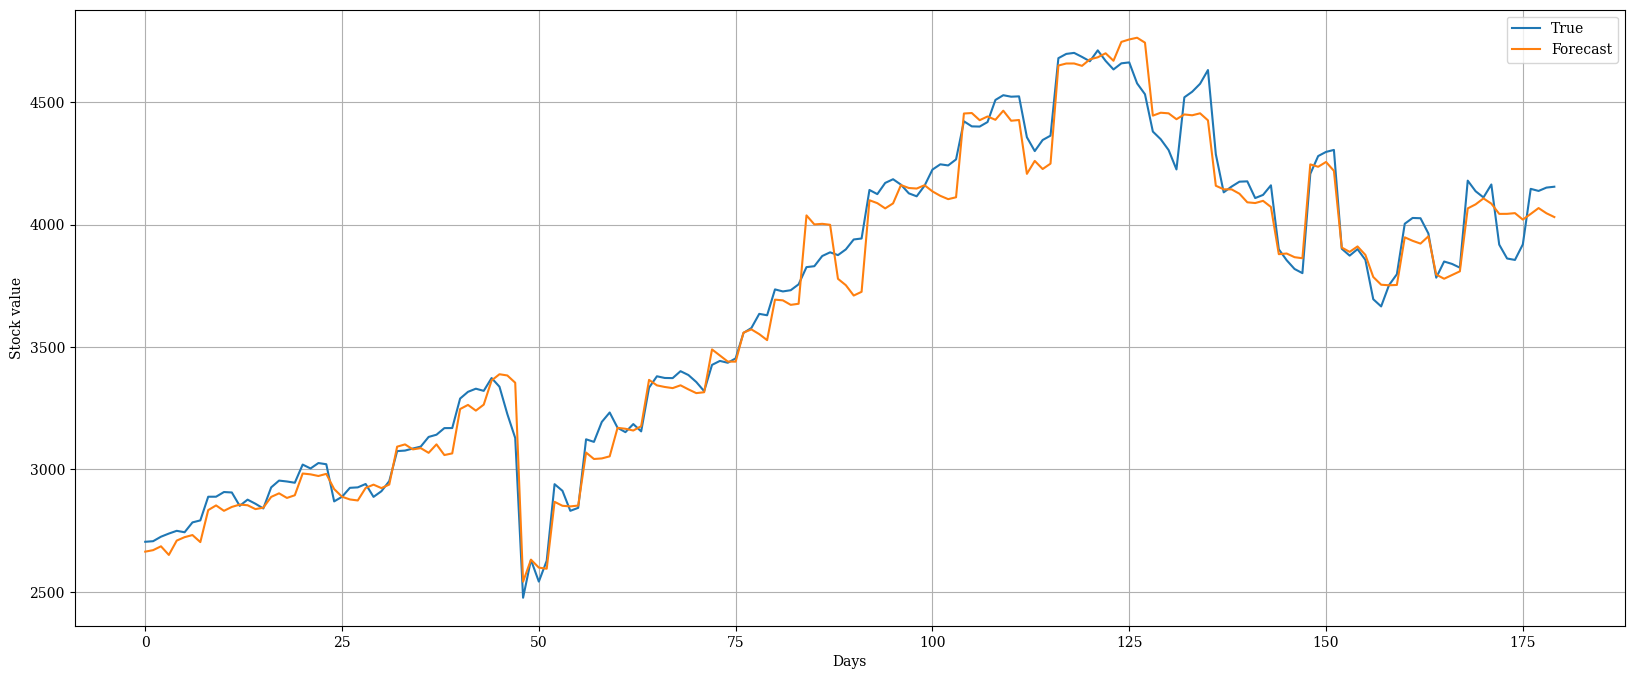

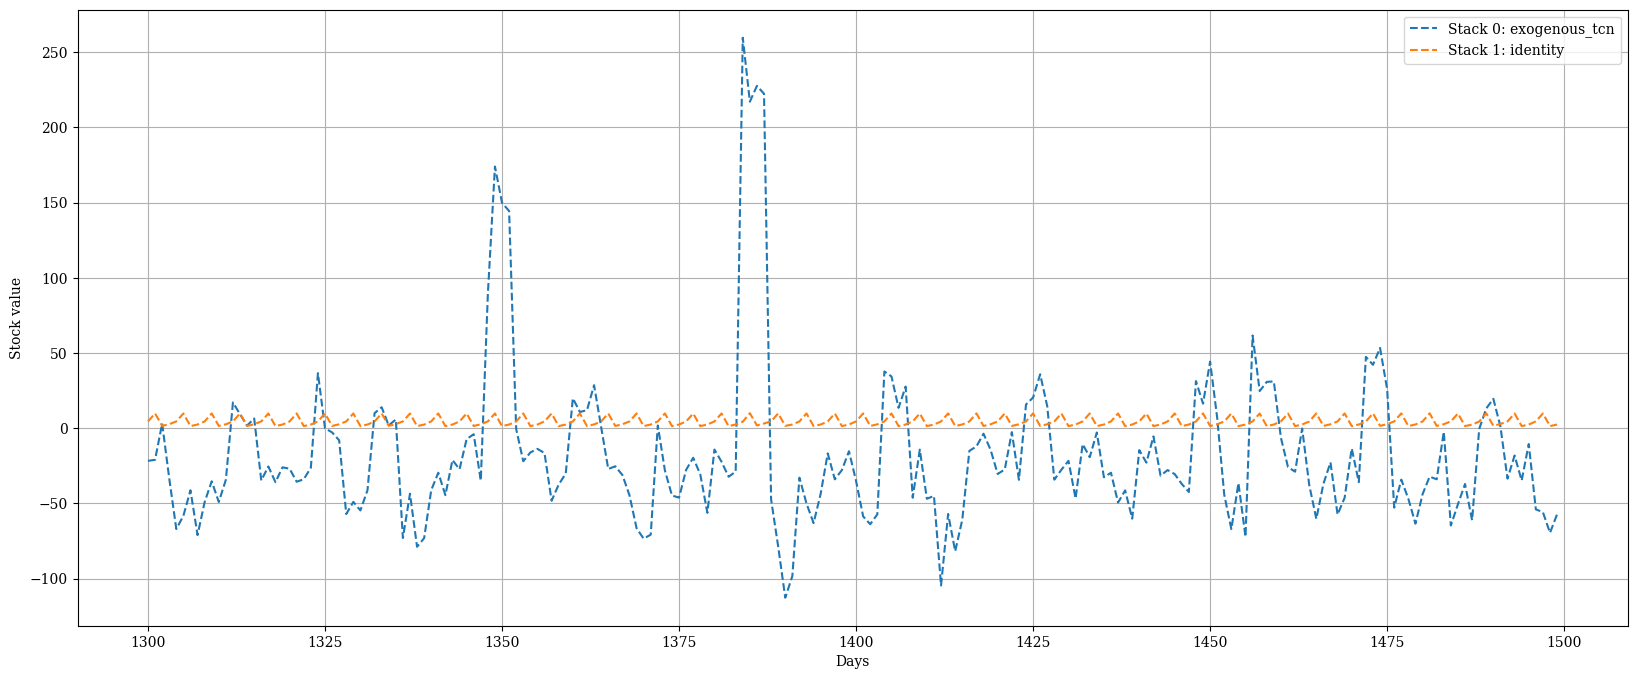

Case:  7 Stack types considered: ['trend', 'seasonality']
list_exo =  ['^VIX', '^TNX']
Processing dataframes ...
Creating ts tensor ...


============================== Start fitting ==============================
Step: 50, Time: 0.421, Insample MSE: 3042.23755, Outsample MSE: 4505.20801
Step: 100, Time: 0.796, Insample MSE: 2021.39734, Outsample MSE: 5146.80322
Step: 150, Time: 1.176, Insample MSE: 1773.53943, Outsample MSE: 6658.10449
Step: 200, Time: 1.549, Insample MSE: 1526.11877, Outsample MSE: 7557.78418
Step: 250, Time: 1.921, Insample MSE: 1484.06738, Outsample MSE: 8523.95996
Step: 300, Time: 2.302, Insample MSE: 1533.57507, Outsample MSE: 8655.26172
Step: 350, Time: 2.673, Insample MSE: 1834.21472, Outsample MSE: 5839.79980
Step: 400, Time: 3.044, Insample MSE: 2021.27734, Outsample MSE: 6170.79688
Step: 450, Time: 3.419, Insample MSE: 2138.09937, Outsample MSE: 6179.03760
Step: 500, Time: 3.792, Insample MSE: 1418.02734, Outsample MSE: 6229.38965
Step: 550, Time: 4.164, Ins

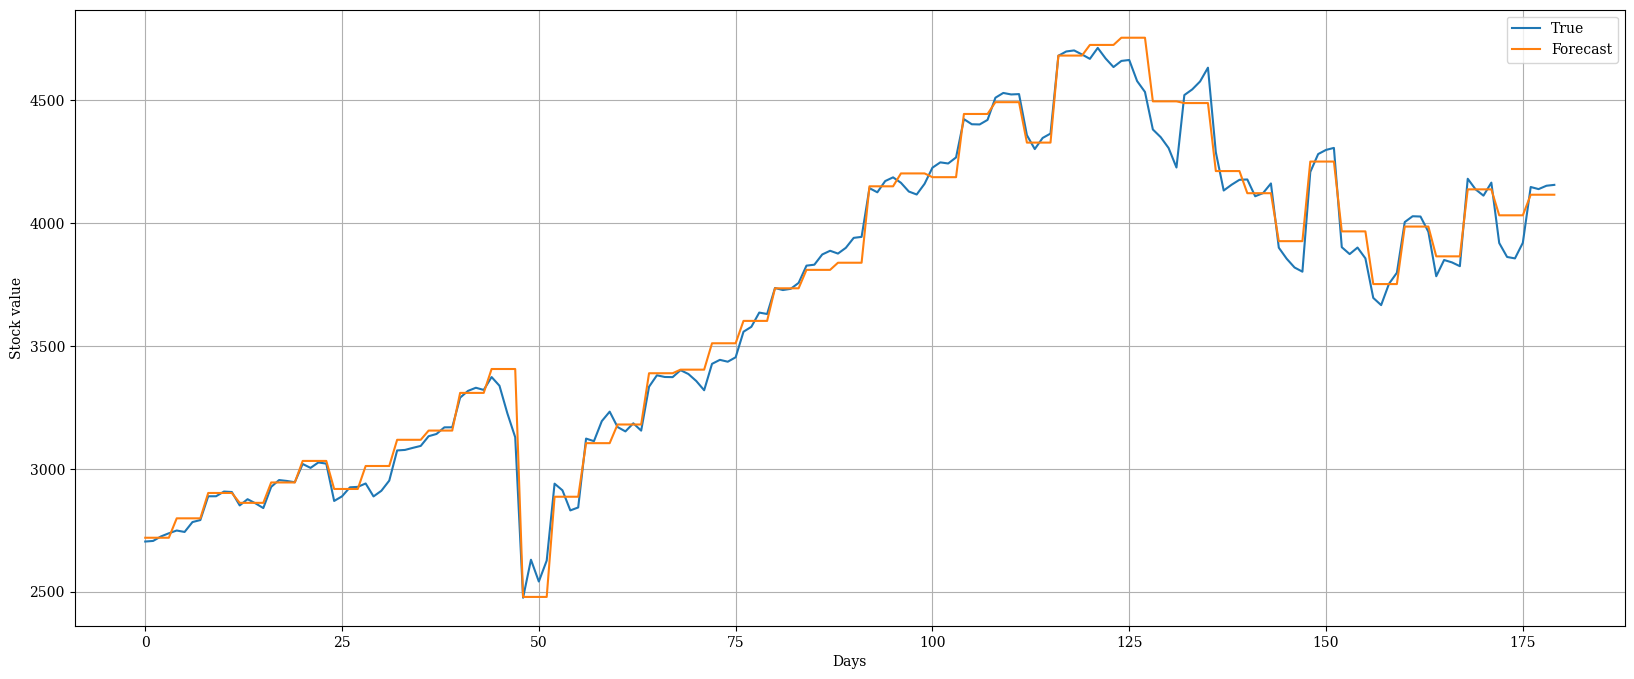

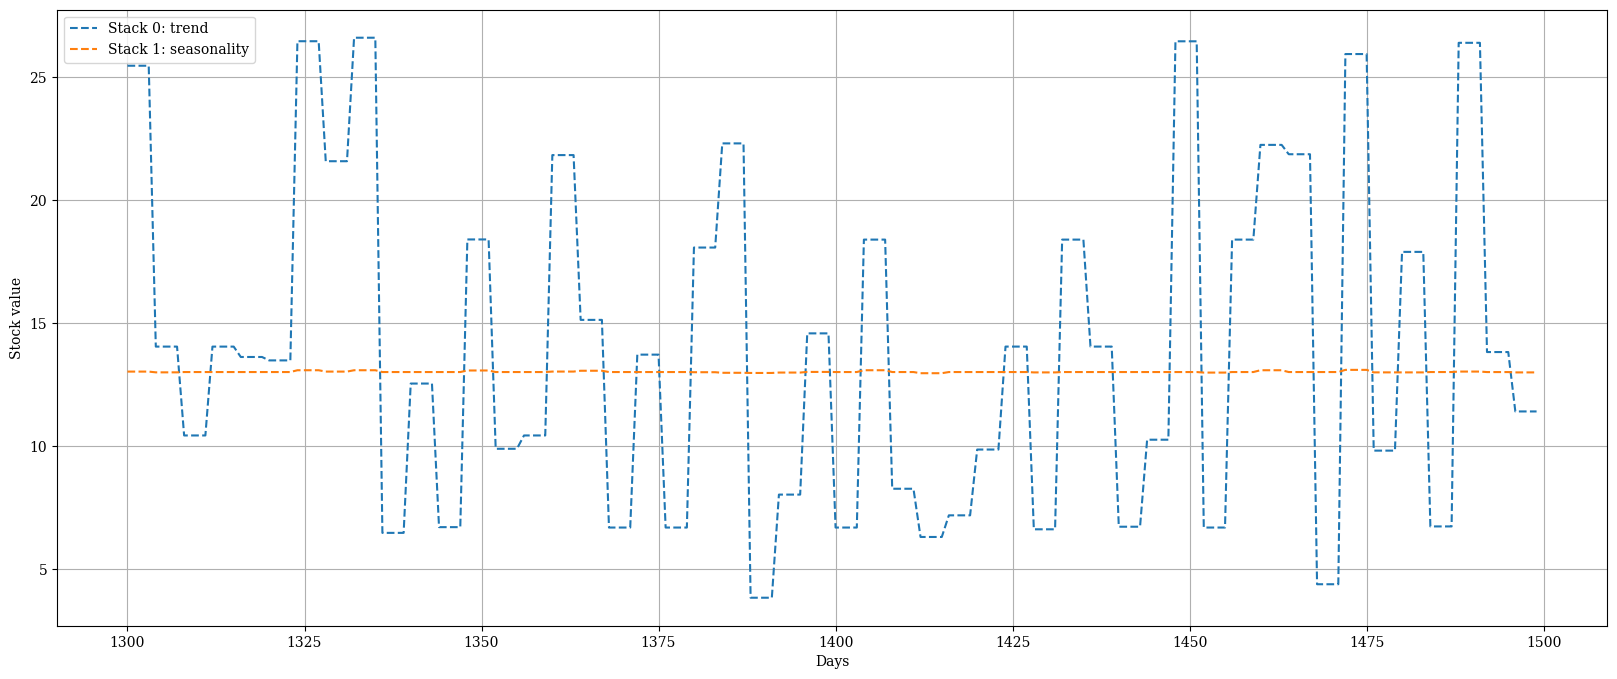

Case:  8 Stack types considered: ['trend', 'identity']
list_exo =  ['^VIX', '^TNX']
Processing dataframes ...
Creating ts tensor ...


============================== Start fitting ==============================
Step: 50, Time: 0.461, Insample MSE: 2866.03125, Outsample MSE: 4607.37598
Step: 100, Time: 0.858, Insample MSE: 2493.40918, Outsample MSE: 4832.25195
Step: 150, Time: 1.249, Insample MSE: 1938.50623, Outsample MSE: 5784.46729
Step: 200, Time: 1.650, Insample MSE: 1961.96875, Outsample MSE: 6100.01172
Step: 250, Time: 2.042, Insample MSE: 2025.29138, Outsample MSE: 6279.08984
Step: 300, Time: 2.436, Insample MSE: 2084.78882, Outsample MSE: 6443.61523
Step: 350, Time: 2.829, Insample MSE: 2019.90442, Outsample MSE: 6493.83740
Step: 400, Time: 3.223, Insample MSE: 1783.95642, Outsample MSE: 6600.77246
Step: 450, Time: 3.636, Insample MSE: 2266.52930, Outsample MSE: 6486.47852
Step: 500, Time: 4.030, Insample MSE: 1983.80554, Outsample MSE: 6660.41064
Step: 550, Time: 4.477, Insamp

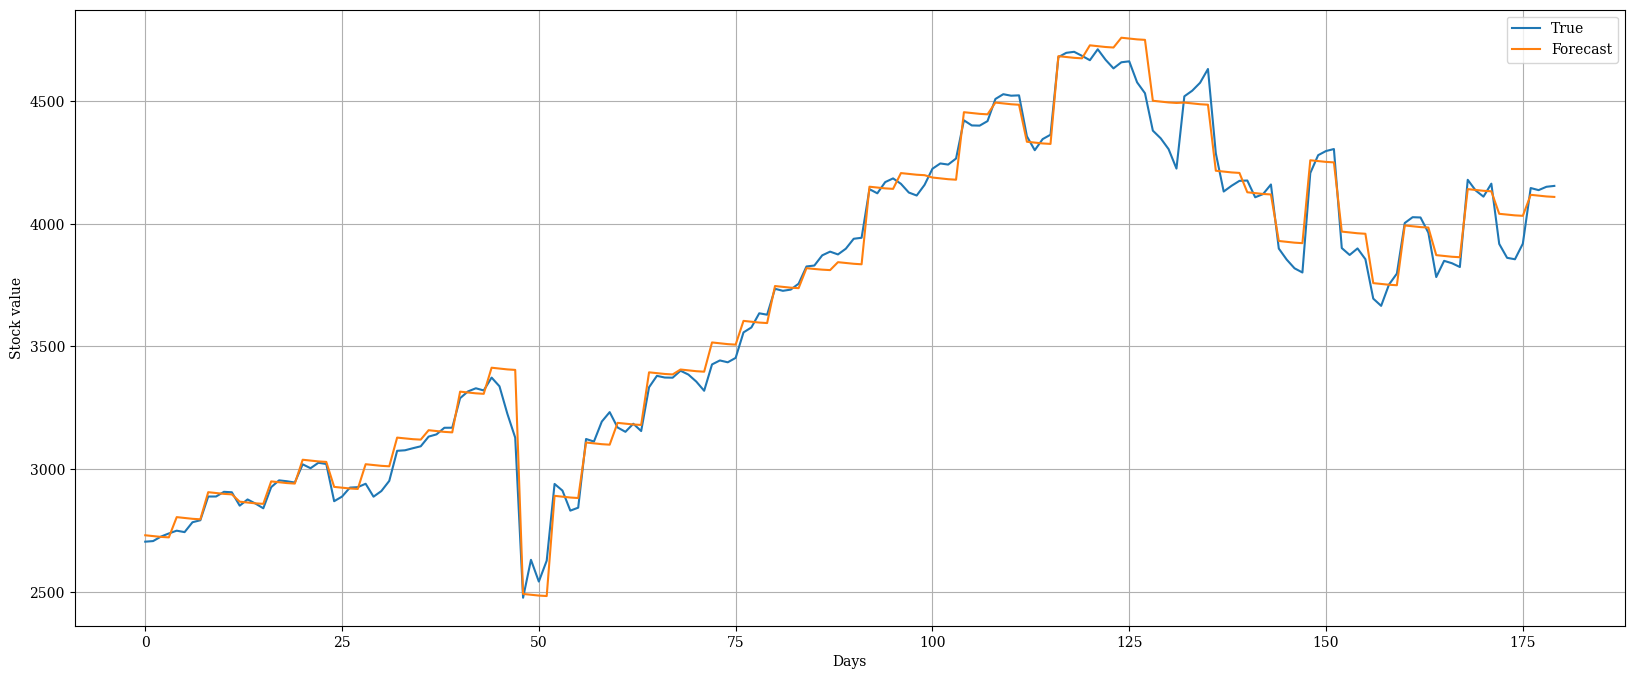

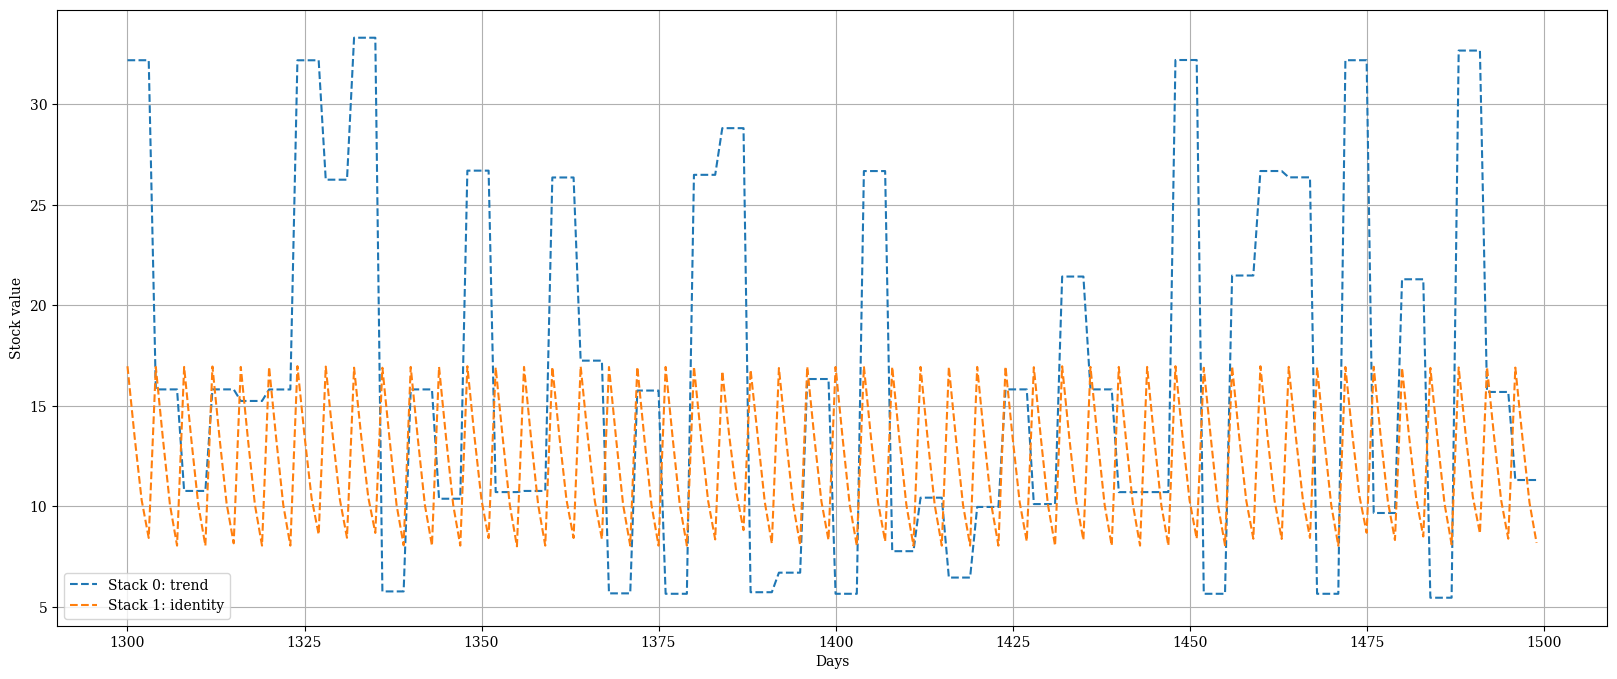

Case:  9 Stack types considered: ['seasonality', 'identity']
list_exo =  ['^VIX', '^TNX']
Processing dataframes ...
Creating ts tensor ...


============================== Start fitting ==============================
Step: 50, Time: 0.411, Insample MSE: 3045.40039, Outsample MSE: 4537.79883
Step: 100, Time: 0.807, Insample MSE: 2572.99390, Outsample MSE: 4789.18164
Step: 150, Time: 1.204, Insample MSE: 2267.92847, Outsample MSE: 5322.82959
Step: 200, Time: 1.603, Insample MSE: 2148.02271, Outsample MSE: 6496.28613
Step: 250, Time: 2.004, Insample MSE: 1952.64392, Outsample MSE: 7274.28125
Step: 300, Time: 2.405, Insample MSE: 1881.65369, Outsample MSE: 7246.26855
Step: 350, Time: 2.804, Insample MSE: 1881.48438, Outsample MSE: 7804.92822
Step: 400, Time: 3.203, Insample MSE: 2082.15845, Outsample MSE: 7132.59375
Step: 450, Time: 3.601, Insample MSE: 1724.57874, Outsample MSE: 7441.24121
Step: 500, Time: 3.999, Insample MSE: 1775.74768, Outsample MSE: 7299.02246
Step: 550, Time: 4.397, 

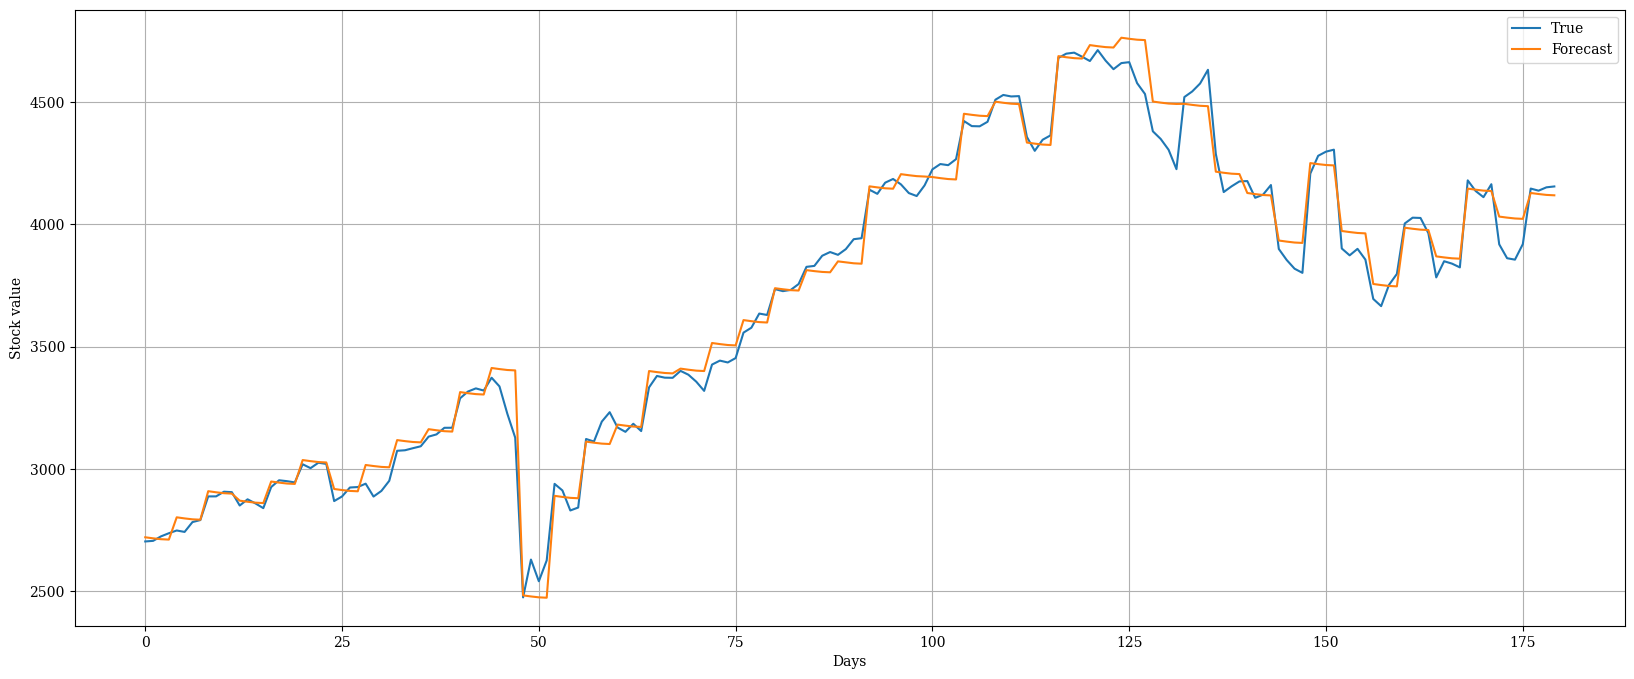

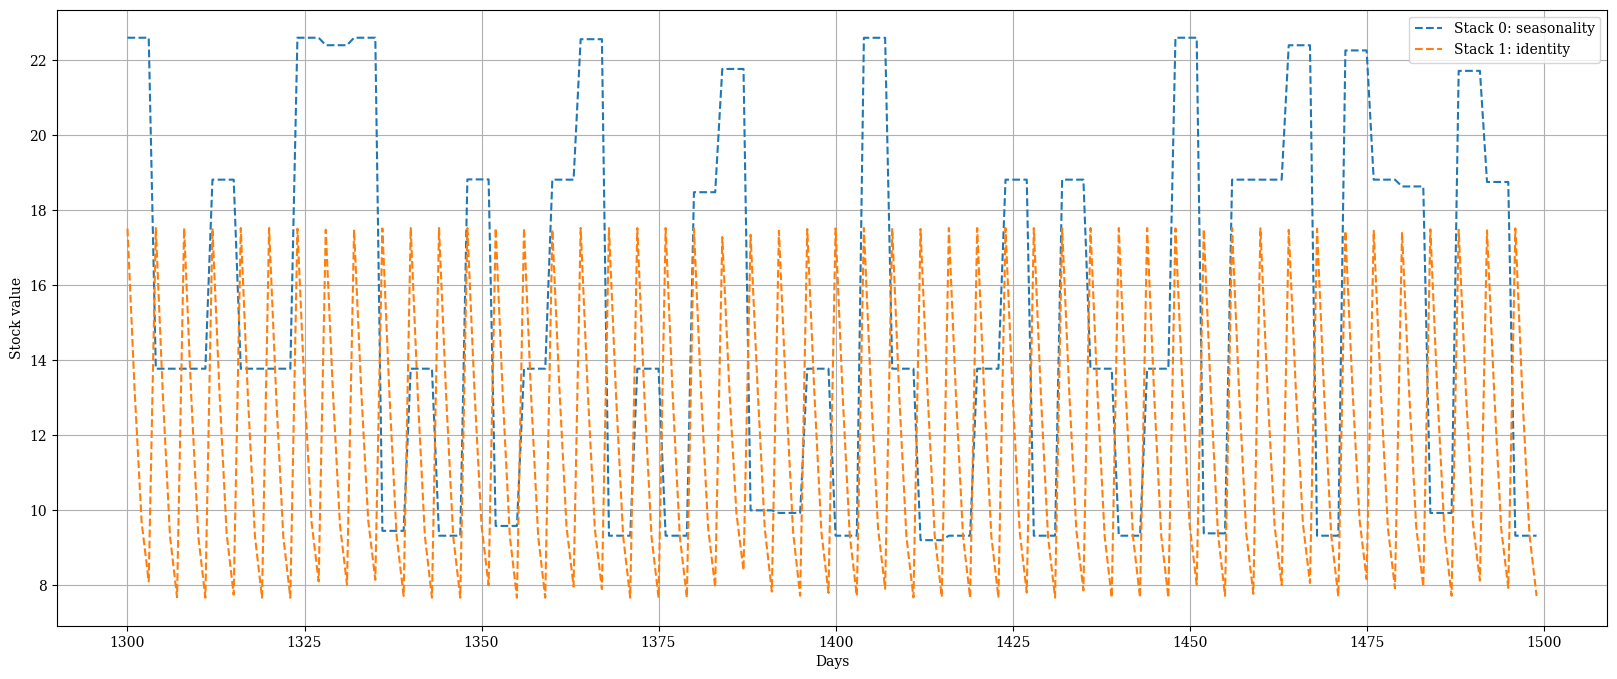

Case:  10 Stack types considered: ['exogenous_tcn', 'trend', 'seasonality']
list_exo =  ['^VIX', '^TNX']
Processing dataframes ...
Creating ts tensor ...


============================== Start fitting ==============================
Step: 50, Time: 1.111, Insample MSE: 1895.21057, Outsample MSE: 6850.09766
Step: 100, Time: 2.189, Insample MSE: 1359.68286, Outsample MSE: 7956.47949
Step: 150, Time: 3.250, Insample MSE: 979.59784, Outsample MSE: 6977.22168
Step: 200, Time: 4.312, Insample MSE: 782.85864, Outsample MSE: 9675.00977
Step: 250, Time: 5.378, Insample MSE: 539.10260, Outsample MSE: 9269.93555
Step: 300, Time: 6.444, Insample MSE: 628.83356, Outsample MSE: 12712.55859
Step: 350, Time: 7.528, Insample MSE: 501.96265, Outsample MSE: 14416.41504
Step: 400, Time: 8.686, Insample MSE: 426.55411, Outsample MSE: 14111.75391
Step: 450, Time: 10.095, Insample MSE: 356.31564, Outsample MSE: 15427.29297
Step: 500, Time: 11.153, Insample MSE: 381.09860, Outsample MSE: 18526.19922
Step: 550,

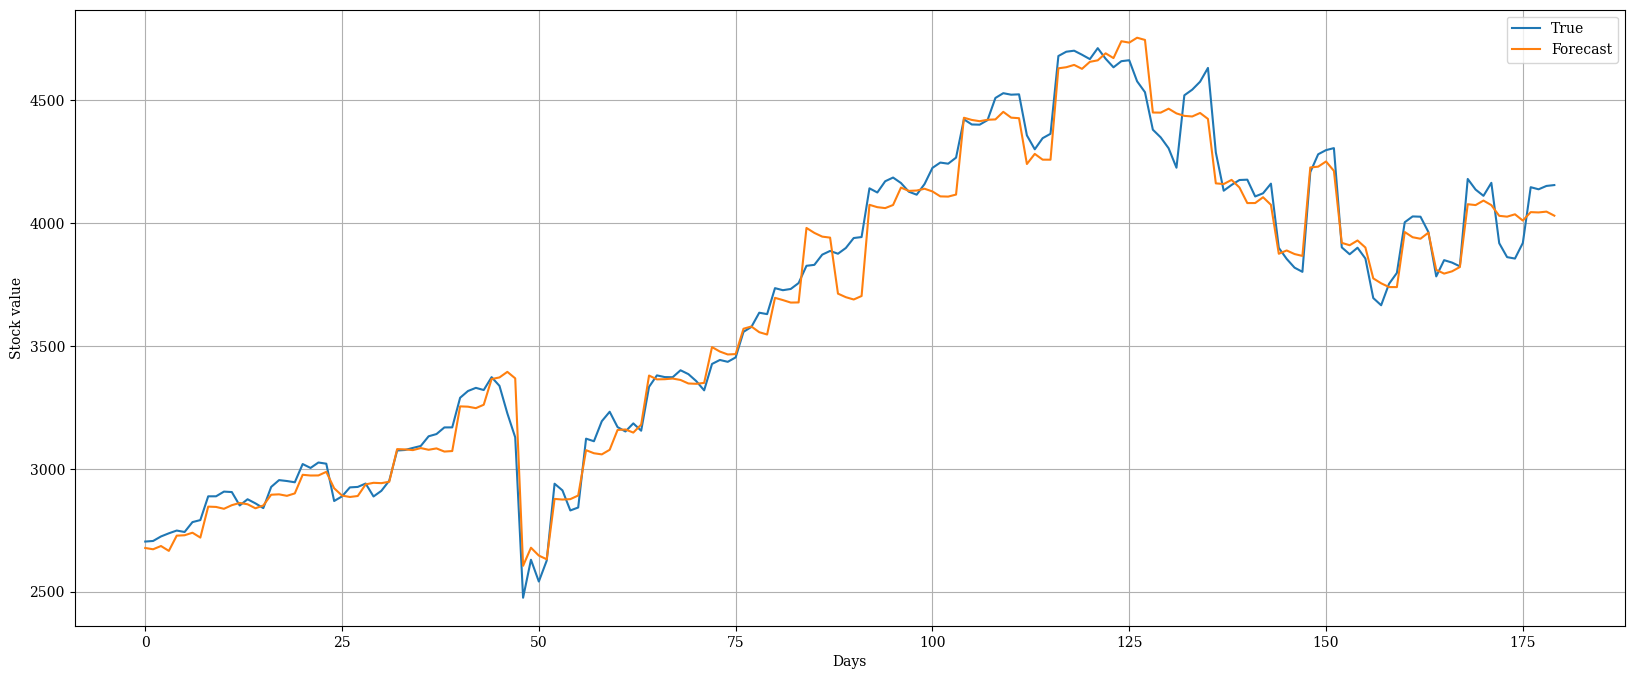

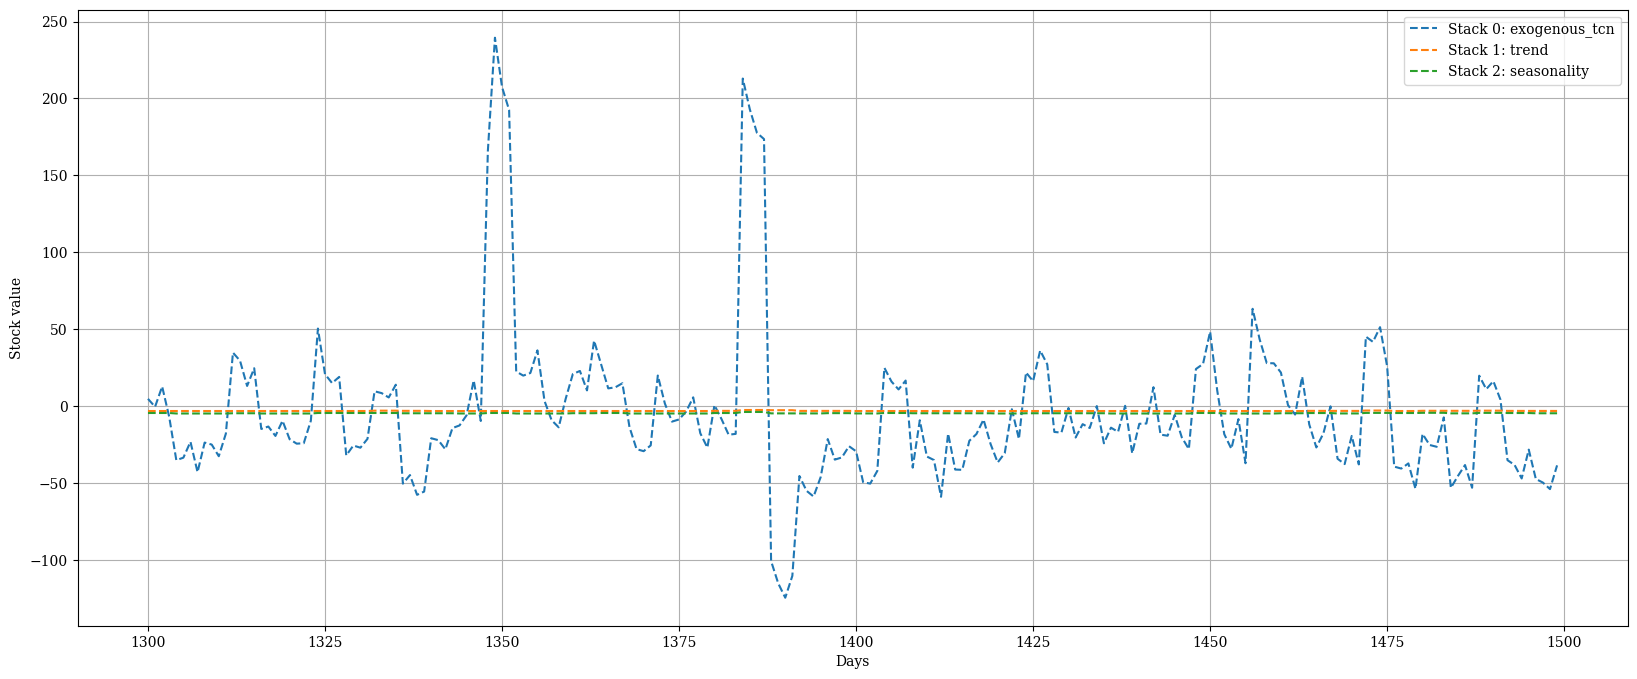

Case:  11 Stack types considered: ['exogenous_tcn', 'trend', 'identity']
list_exo =  ['^VIX', '^TNX']
Processing dataframes ...
Creating ts tensor ...


============================== Start fitting ==============================
Step: 50, Time: 1.179, Insample MSE: 2150.42700, Outsample MSE: 5969.61230
Step: 100, Time: 2.312, Insample MSE: 1406.17090, Outsample MSE: 6773.28271
Step: 150, Time: 3.389, Insample MSE: 1522.36658, Outsample MSE: 7412.59863
Step: 200, Time: 4.465, Insample MSE: 506.16785, Outsample MSE: 6614.90918
Step: 250, Time: 5.641, Insample MSE: 537.84491, Outsample MSE: 11358.32715
Step: 300, Time: 6.776, Insample MSE: 556.87793, Outsample MSE: 7934.71436
Step: 350, Time: 7.919, Insample MSE: 782.57001, Outsample MSE: 8491.03613
Step: 400, Time: 9.223, Insample MSE: 674.05762, Outsample MSE: 13185.59863
Step: 450, Time: 10.725, Insample MSE: 346.14835, Outsample MSE: 15496.46777
Step: 500, Time: 11.887, Insample MSE: 421.87900, Outsample MSE: 16909.38086
Step: 550, Ti

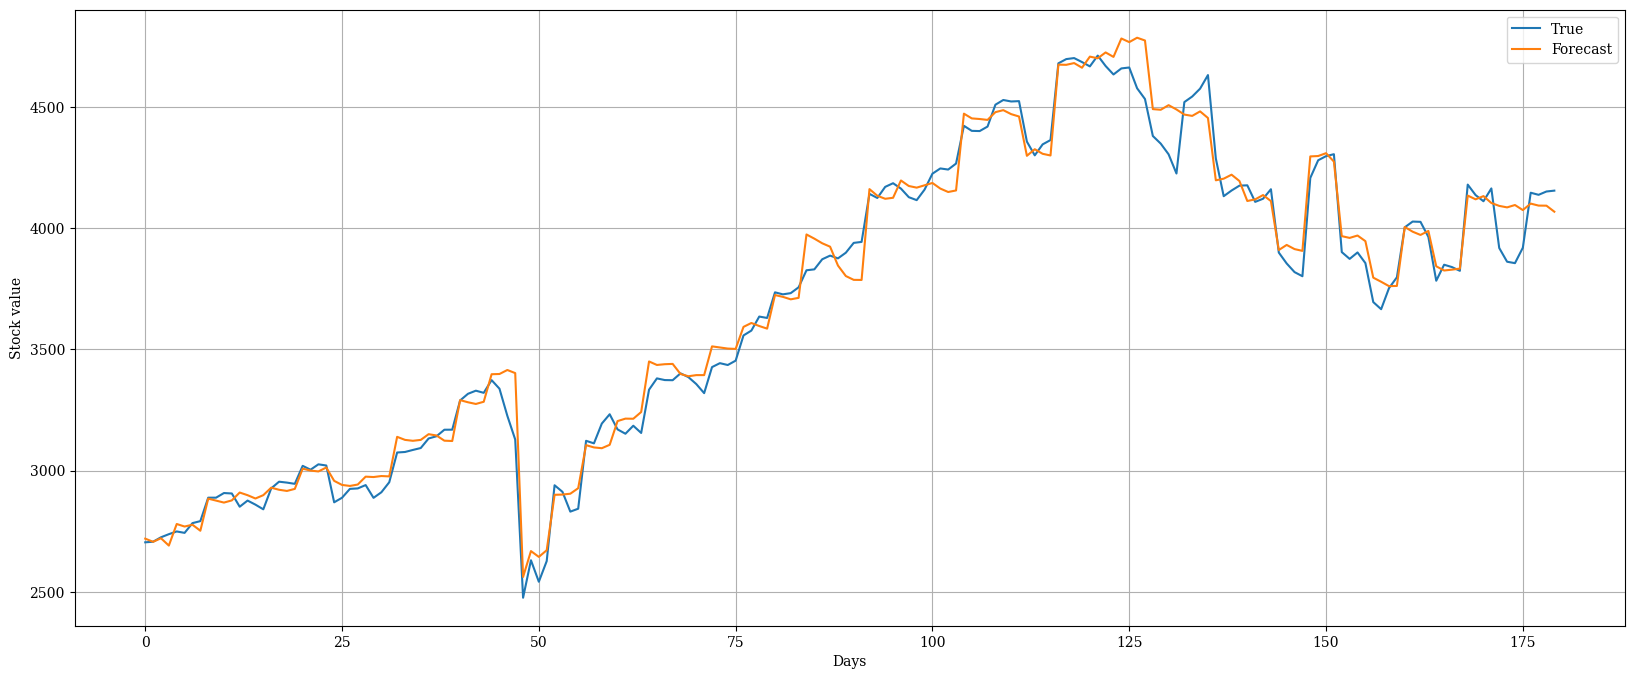

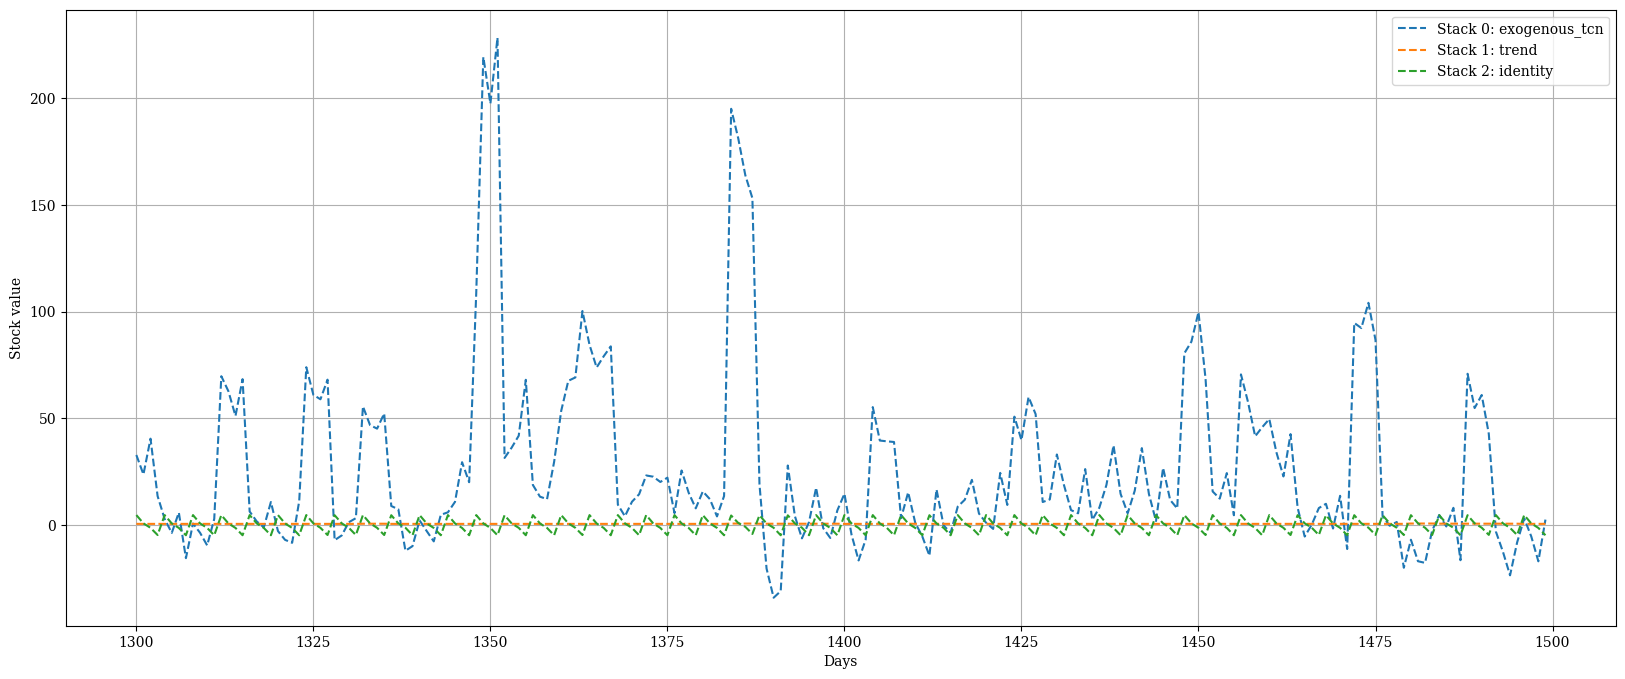

Case:  12 Stack types considered: ['exogenous_tcn', 'seasonality', 'identity']
list_exo =  ['^VIX', '^TNX']
Processing dataframes ...
Creating ts tensor ...


============================== Start fitting ==============================
Step: 50, Time: 1.176, Insample MSE: 2090.74097, Outsample MSE: 5687.10400
Step: 100, Time: 2.402, Insample MSE: 1406.39001, Outsample MSE: 6006.01855
Step: 150, Time: 3.578, Insample MSE: 846.57349, Outsample MSE: 8293.30273
Step: 200, Time: 4.760, Insample MSE: 562.64923, Outsample MSE: 15059.73242
Step: 250, Time: 5.914, Insample MSE: 457.42319, Outsample MSE: 15968.05469
Step: 300, Time: 7.063, Insample MSE: 804.07880, Outsample MSE: 28227.52734
Step: 350, Time: 8.222, Insample MSE: 437.13565, Outsample MSE: 29843.09961
Step: 400, Time: 9.386, Insample MSE: 433.88309, Outsample MSE: 31331.39453
Step: 450, Time: 10.542, Insample MSE: 401.00345, Outsample MSE: 40919.50000
Step: 500, Time: 11.704, Insample MSE: 325.77911, Outsample MSE: 51974.11719
Step:

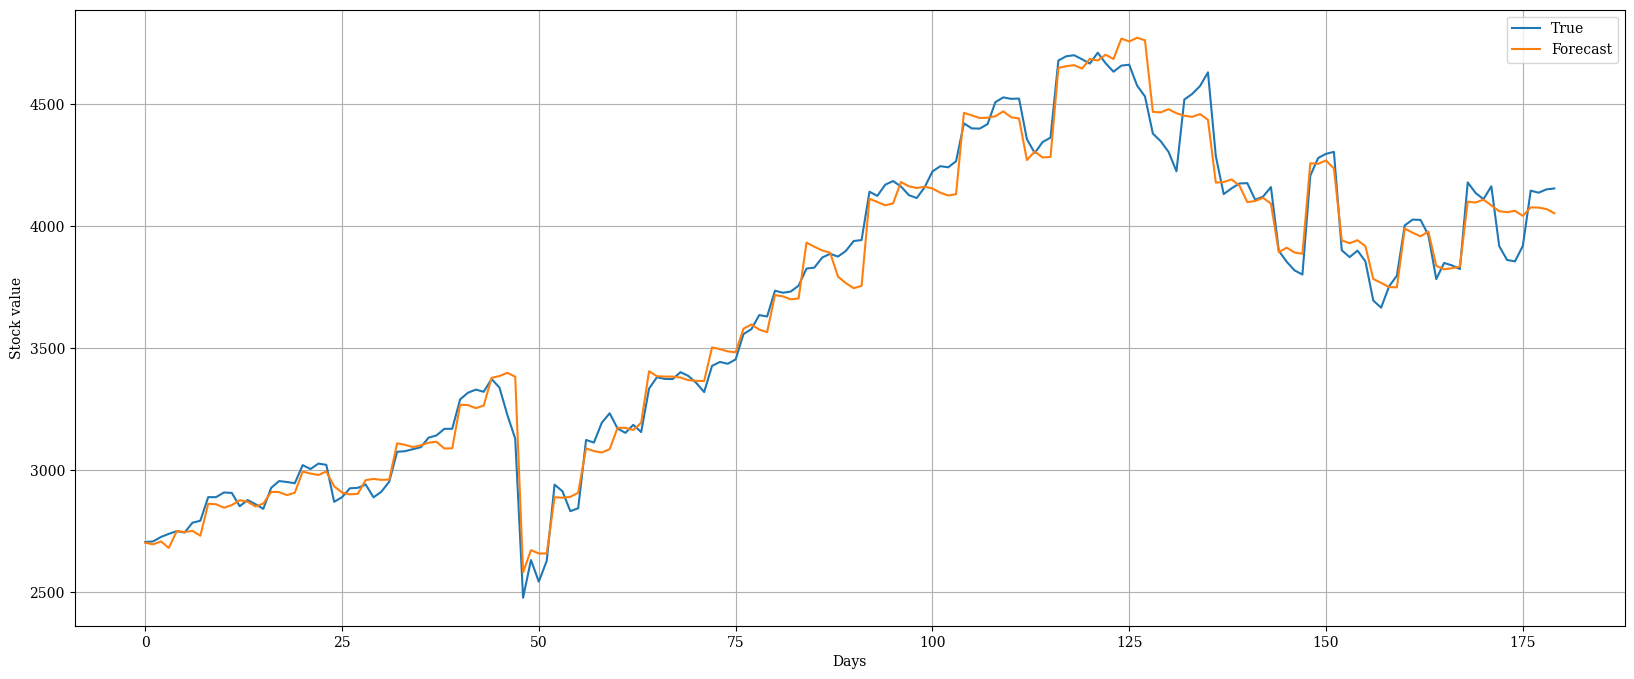

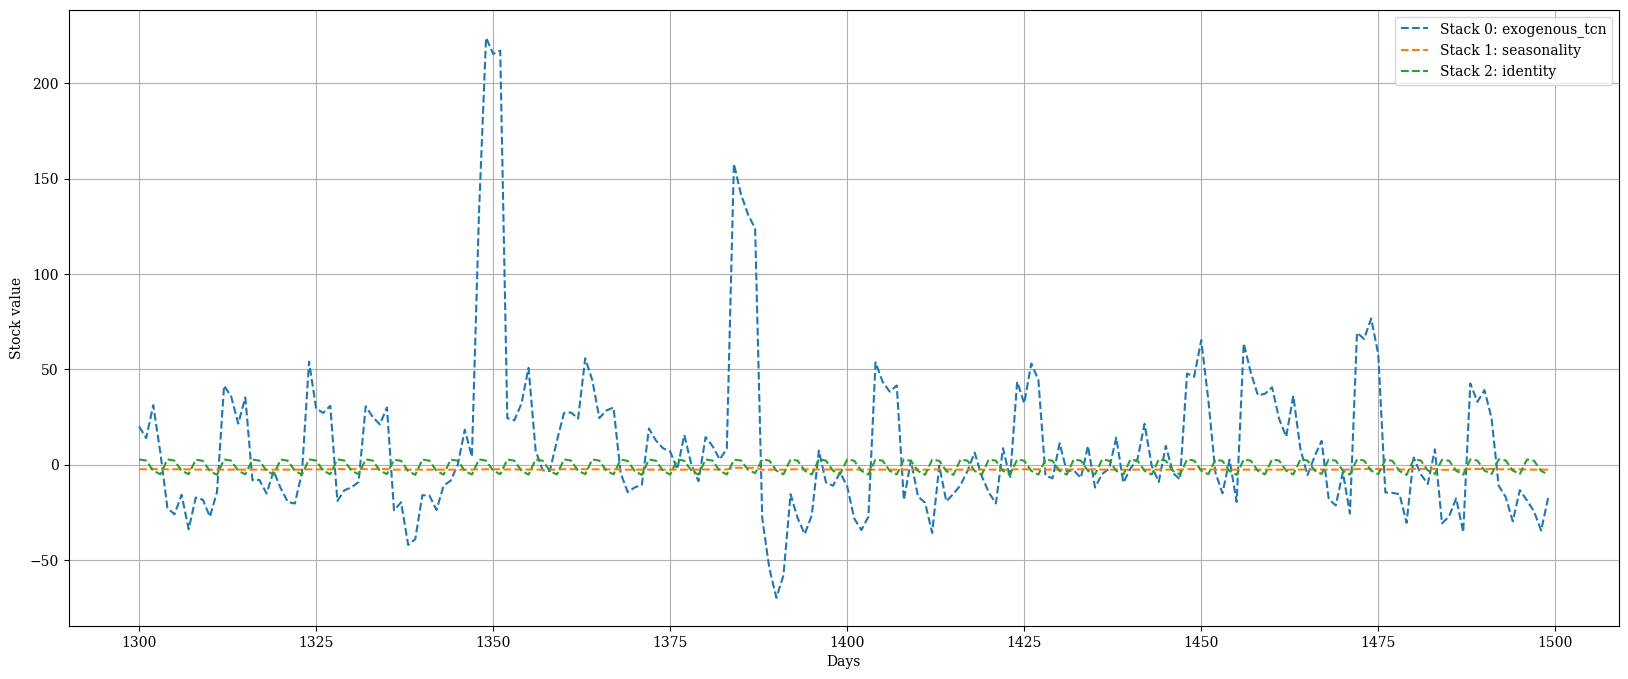

Case:  13 Stack types considered: ['trend', 'seasonality', 'identity']
list_exo =  ['^VIX', '^TNX']
Processing dataframes ...
Creating ts tensor ...


============================== Start fitting ==============================
Step: 50, Time: 0.594, Insample MSE: 3111.69336, Outsample MSE: 4616.97168
Step: 100, Time: 1.193, Insample MSE: 2710.81616, Outsample MSE: 4730.30127
Step: 150, Time: 1.750, Insample MSE: 2158.25171, Outsample MSE: 5453.36768
Step: 200, Time: 2.306, Insample MSE: 1830.85413, Outsample MSE: 5966.69775
Step: 250, Time: 2.915, Insample MSE: 1961.65784, Outsample MSE: 6744.38574
Step: 300, Time: 3.483, Insample MSE: 2334.49023, Outsample MSE: 6058.68896
Step: 350, Time: 4.051, Insample MSE: 1994.11902, Outsample MSE: 7557.23926
Step: 400, Time: 4.601, Insample MSE: 1707.29626, Outsample MSE: 6678.87109
Step: 450, Time: 5.153, Insample MSE: 1732.64160, Outsample MSE: 6457.71387
Step: 500, Time: 5.703, Insample MSE: 1979.04041, Outsample MSE: 7154.01318
Step: 550, Tim

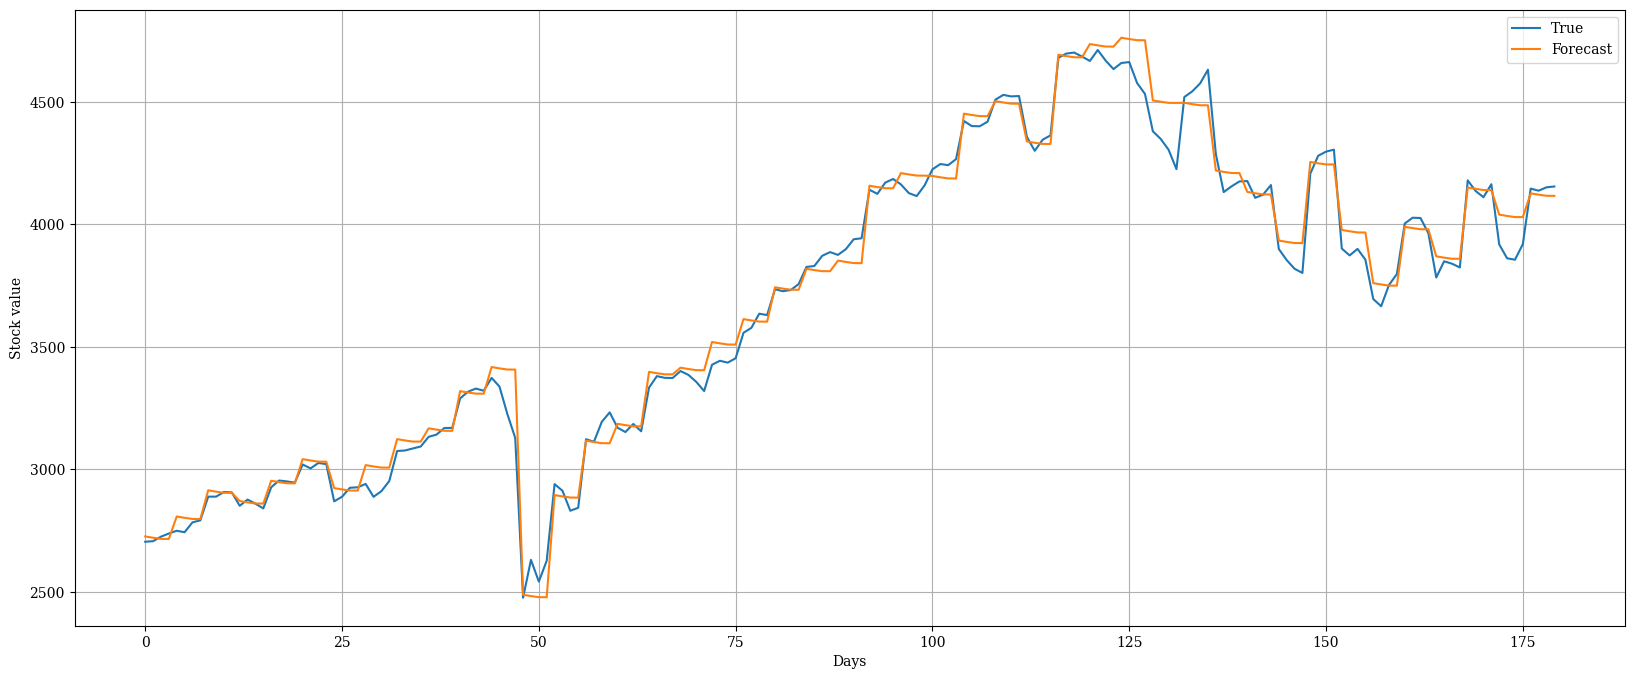

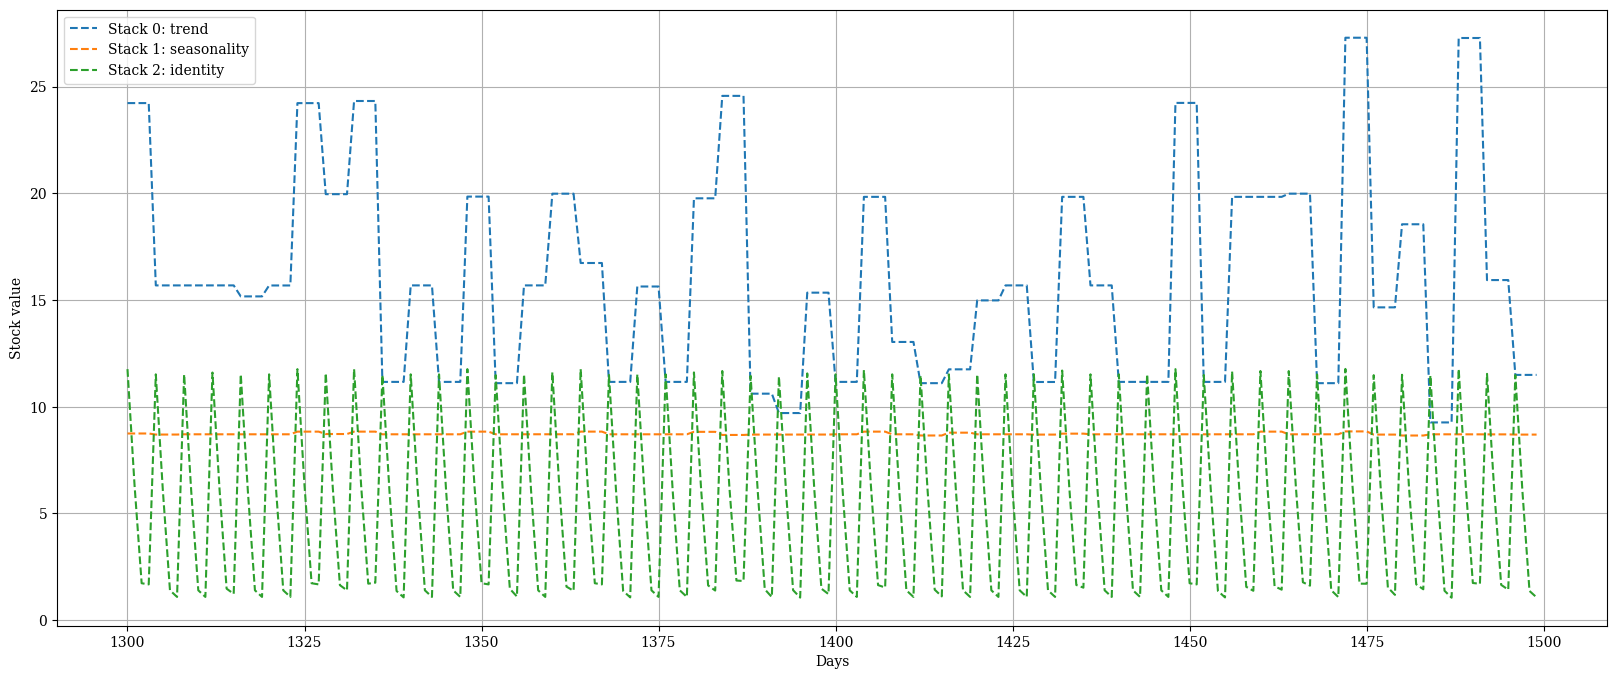

Case:  14 Stack types considered: ['exogenous_tcn', 'trend', 'seasonality', 'identity']
list_exo =  ['^VIX', '^TNX']
Processing dataframes ...
Creating ts tensor ...


============================== Start fitting ==============================
Step: 50, Time: 1.364, Insample MSE: 1923.18518, Outsample MSE: 6055.46484
Step: 100, Time: 2.698, Insample MSE: 1408.75720, Outsample MSE: 9396.03711
Step: 150, Time: 4.068, Insample MSE: 1001.84888, Outsample MSE: 9529.18457
Step: 200, Time: 5.389, Insample MSE: 673.88647, Outsample MSE: 10337.48145
Step: 250, Time: 6.694, Insample MSE: 741.31494, Outsample MSE: 11378.18750
Step: 300, Time: 8.008, Insample MSE: 686.94067, Outsample MSE: 10470.95410
Step: 350, Time: 9.316, Insample MSE: 754.51172, Outsample MSE: 10151.47754
Step: 400, Time: 10.637, Insample MSE: 782.30121, Outsample MSE: 12296.49609
Step: 450, Time: 11.961, Insample MSE: 499.51892, Outsample MSE: 12274.68359
Step: 500, Time: 13.277, Insample MSE: 458.41122, Outsample MSE: 14327.

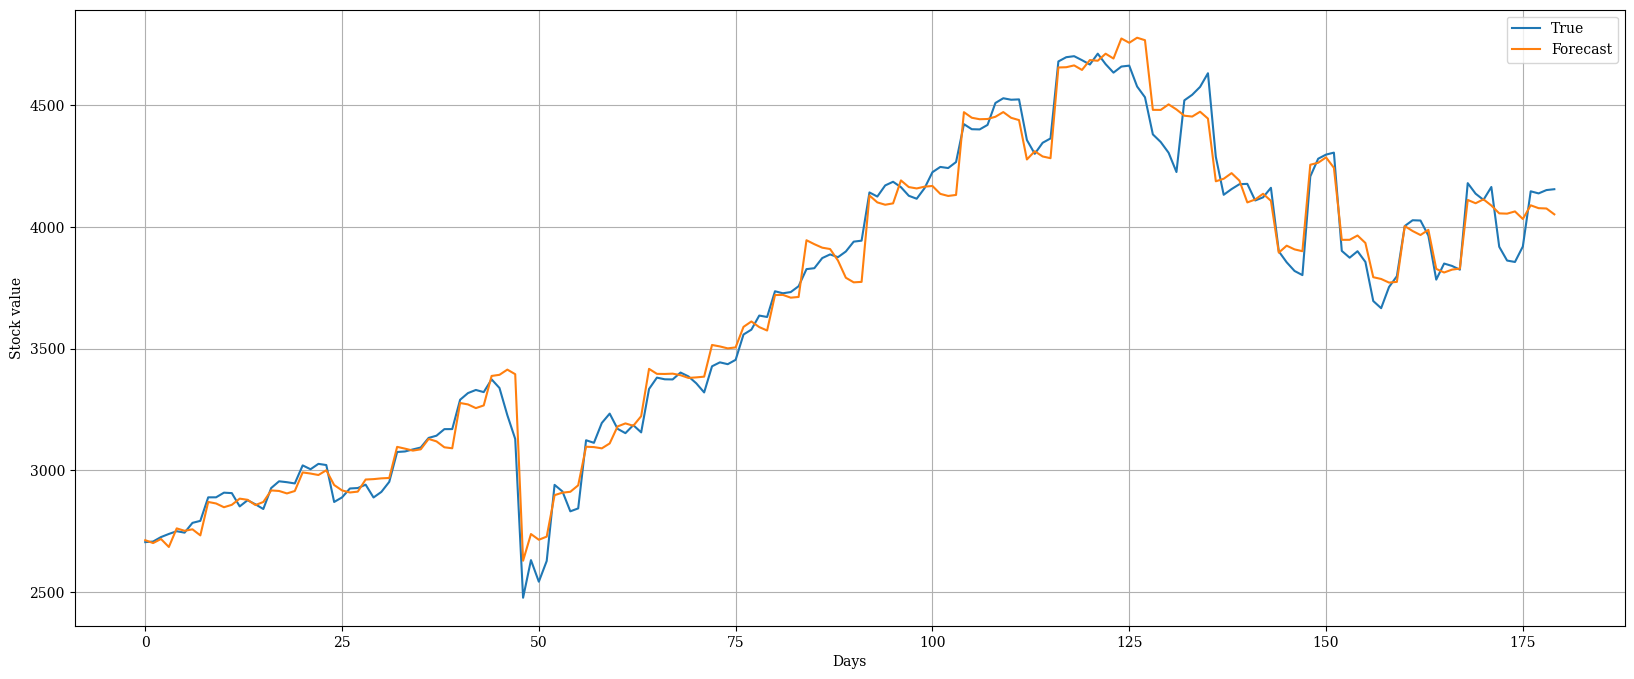

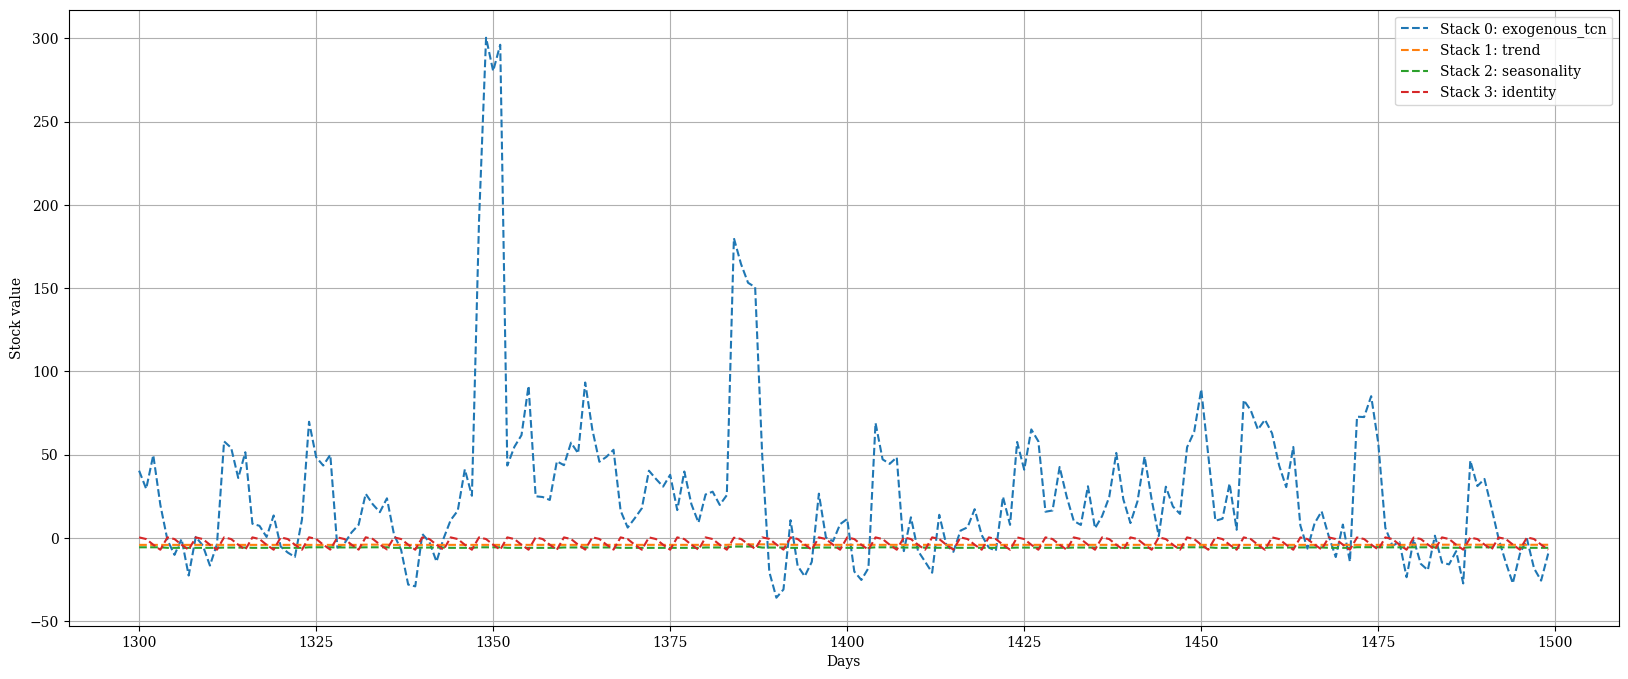

In [29]:
list_all_stacks = ['exogenous_tcn']+['trend']+['seasonality']+['identity']
k = 0
loss_list =['MAE', 'MSE']
input_size_multiplier=60
output_size=4

for list_stacks in generate_subsets(list_all_stacks):
    #for val_loss in loss_list:
        #for loss in loss_list:
            print(80*'=')
            print('Case: ', k,f'Stack types considered: {list_stacks}' )

            model, train_loader, val_loader = training(df, list_exo, loss=loss, val_loss=val_loss, input_size_multiplier=input_size_multiplier, output_size=output_size, list_stacks =list_stacks )

            y_true, y_hat, block_forecast, outsample_masks_ = predict_nbeats(model, val_loader, decomposition = True)
            k+=1
            print(80*'=')

Different possibilities for the exogeneous stack type 

Case:  0 Exogenous stack types considered: exogenous
list_exo =  ['^VIX', '^TNX']
Processing dataframes ...
Creating ts tensor ...


============================== Start fitting ==============================
Step: 50, Time: 0.765, Insample MSE: 2240.37183, Outsample MSE: 8604.67383
Step: 100, Time: 1.516, Insample MSE: 1725.12805, Outsample MSE: 9884.04395
Step: 150, Time: 2.246, Insample MSE: 1883.84961, Outsample MSE: 11791.66504
Step: 200, Time: 3.005, Insample MSE: 841.83368, Outsample MSE: 8906.88379
Step: 250, Time: 3.740, Insample MSE: 744.04120, Outsample MSE: 12822.82031
Step: 300, Time: 4.470, Insample MSE: 600.73022, Outsample MSE: 7942.51074
Step: 350, Time: 5.207, Insample MSE: 767.36963, Outsample MSE: 9149.79785
Step: 400, Time: 5.941, Insample MSE: 1192.26868, Outsample MSE: 8414.65820
Step: 450, Time: 6.698, Insample MSE: 874.67706, Outsample MSE: 8448.19727
Step: 500, Time: 7.488, Insample MSE: 795.26617, Outsample MSE: 9296.20312
Step: 550, Time: 8.227, Insample MSE

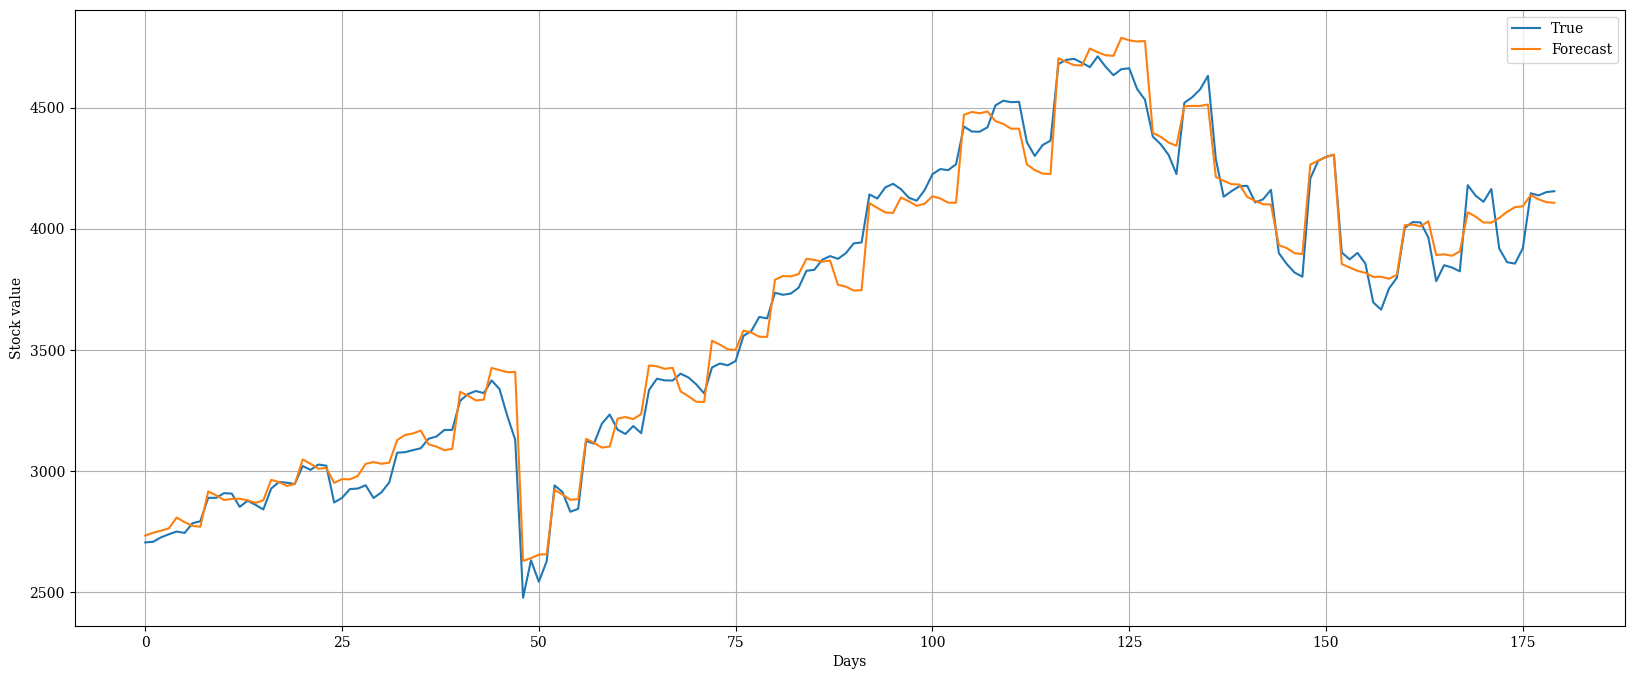

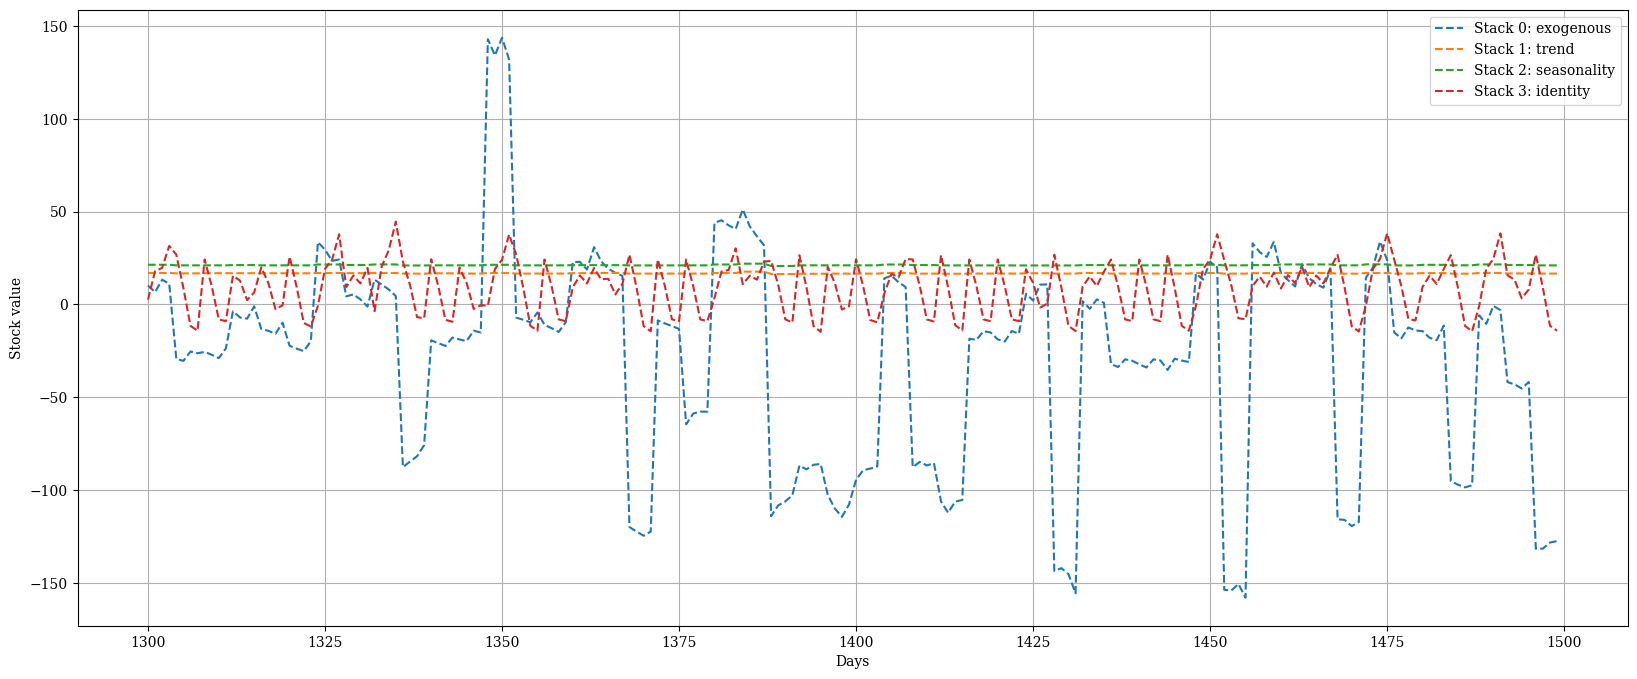

Case:  1 Exogenous stack types considered: exogenous_tcn
list_exo =  ['^VIX', '^TNX']
Processing dataframes ...
Creating ts tensor ...


============================== Start fitting ==============================
Step: 50, Time: 1.357, Insample MSE: 1923.18518, Outsample MSE: 6055.46484
Step: 100, Time: 2.689, Insample MSE: 1408.75720, Outsample MSE: 9396.03711
Step: 150, Time: 4.004, Insample MSE: 1001.84888, Outsample MSE: 9529.18457
Step: 200, Time: 5.320, Insample MSE: 673.88647, Outsample MSE: 10337.48145
Step: 250, Time: 6.630, Insample MSE: 741.31494, Outsample MSE: 11378.18750
Step: 300, Time: 7.932, Insample MSE: 686.94067, Outsample MSE: 10470.95410
Step: 350, Time: 9.241, Insample MSE: 754.51172, Outsample MSE: 10151.47754
Step: 400, Time: 10.602, Insample MSE: 782.30121, Outsample MSE: 12296.49609
Step: 450, Time: 11.898, Insample MSE: 499.51892, Outsample MSE: 12274.68359
Step: 500, Time: 13.192, Insample MSE: 458.41122, Outsample MSE: 14327.33789
Step: 550, Time: 14.506, 

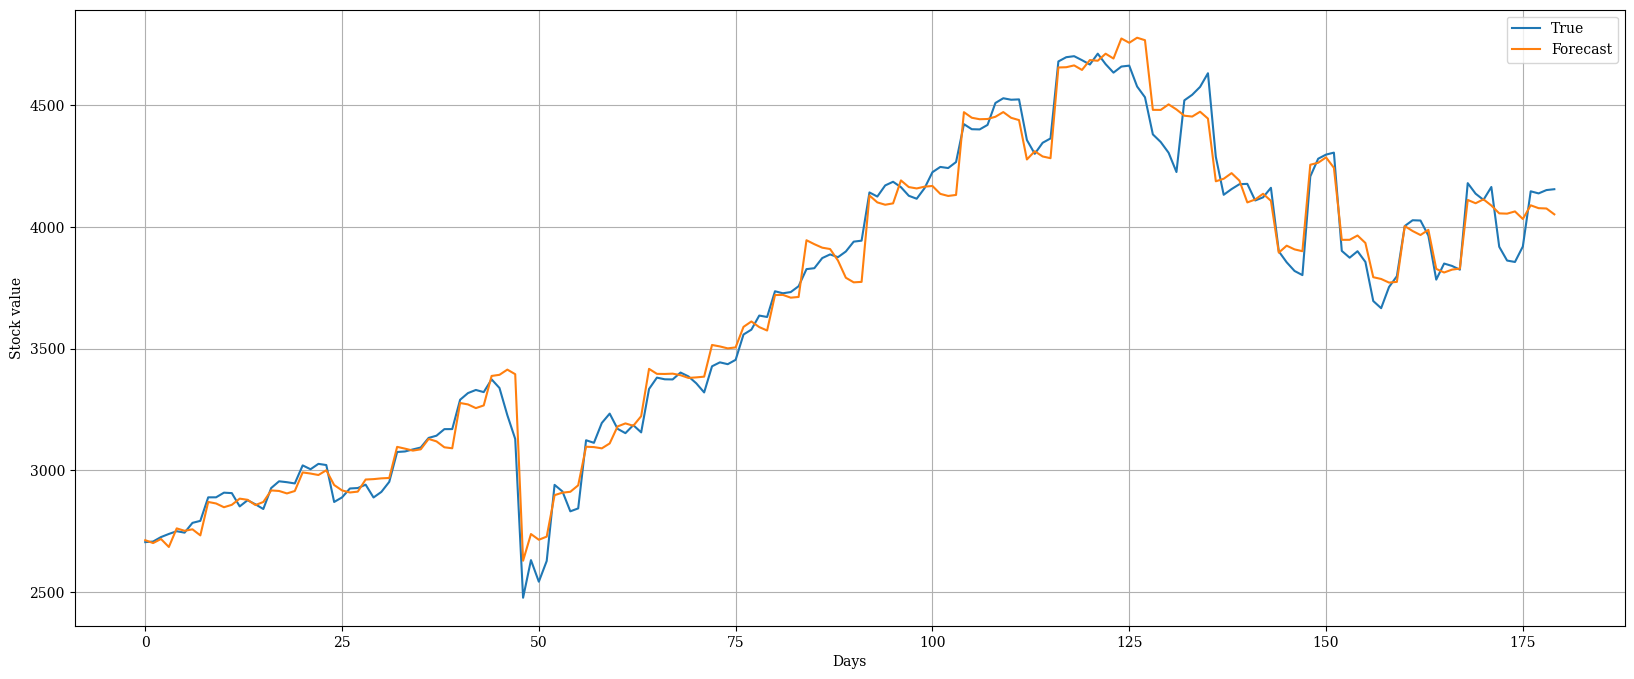

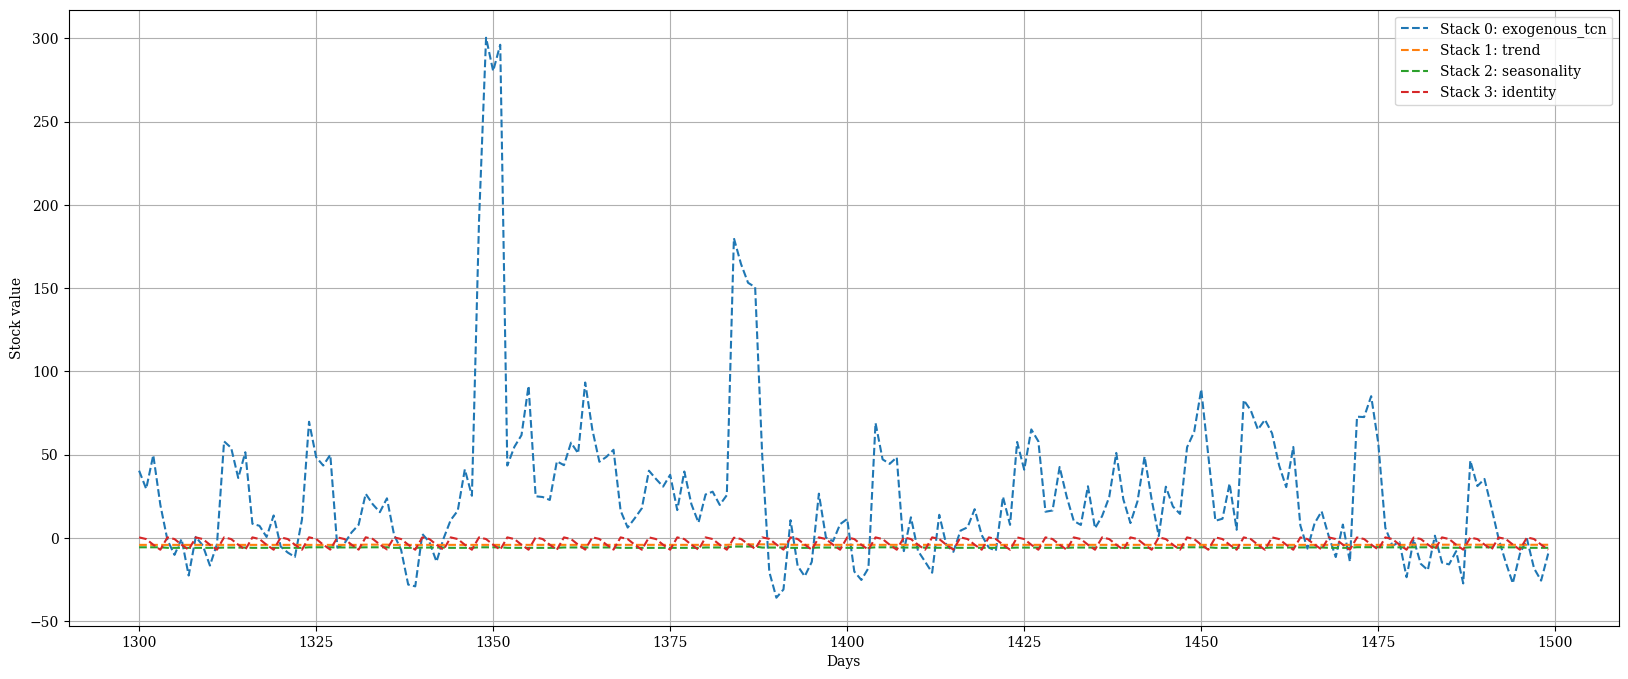

Case:  2 Exogenous stack types considered: exogenous_wavenet
list_exo =  ['^VIX', '^TNX']
Processing dataframes ...
Creating ts tensor ...


============================== Start fitting ==============================
Step: 50, Time: 1.080, Insample MSE: 1787.64746, Outsample MSE: 7331.25586
Step: 100, Time: 2.178, Insample MSE: 1258.75781, Outsample MSE: 20945.49609
Step: 150, Time: 3.283, Insample MSE: 790.45129, Outsample MSE: 57872.01172
Step: 200, Time: 4.330, Insample MSE: 472.31036, Outsample MSE: 53870.36328
Step: 250, Time: 5.388, Insample MSE: 350.77899, Outsample MSE: 58950.05078
Step: 300, Time: 6.438, Insample MSE: 325.49252, Outsample MSE: 60838.30859
Step: 350, Time: 7.493, Insample MSE: 282.02850, Outsample MSE: 59840.35156
Step: 400, Time: 8.544, Insample MSE: 242.59277, Outsample MSE: 62656.60156
Step: 450, Time: 9.621, Insample MSE: 212.38045, Outsample MSE: 56966.59375
Step: 500, Time: 10.707, Insample MSE: 182.75003, Outsample MSE: 59732.04297
Step: 550, Time: 11.78

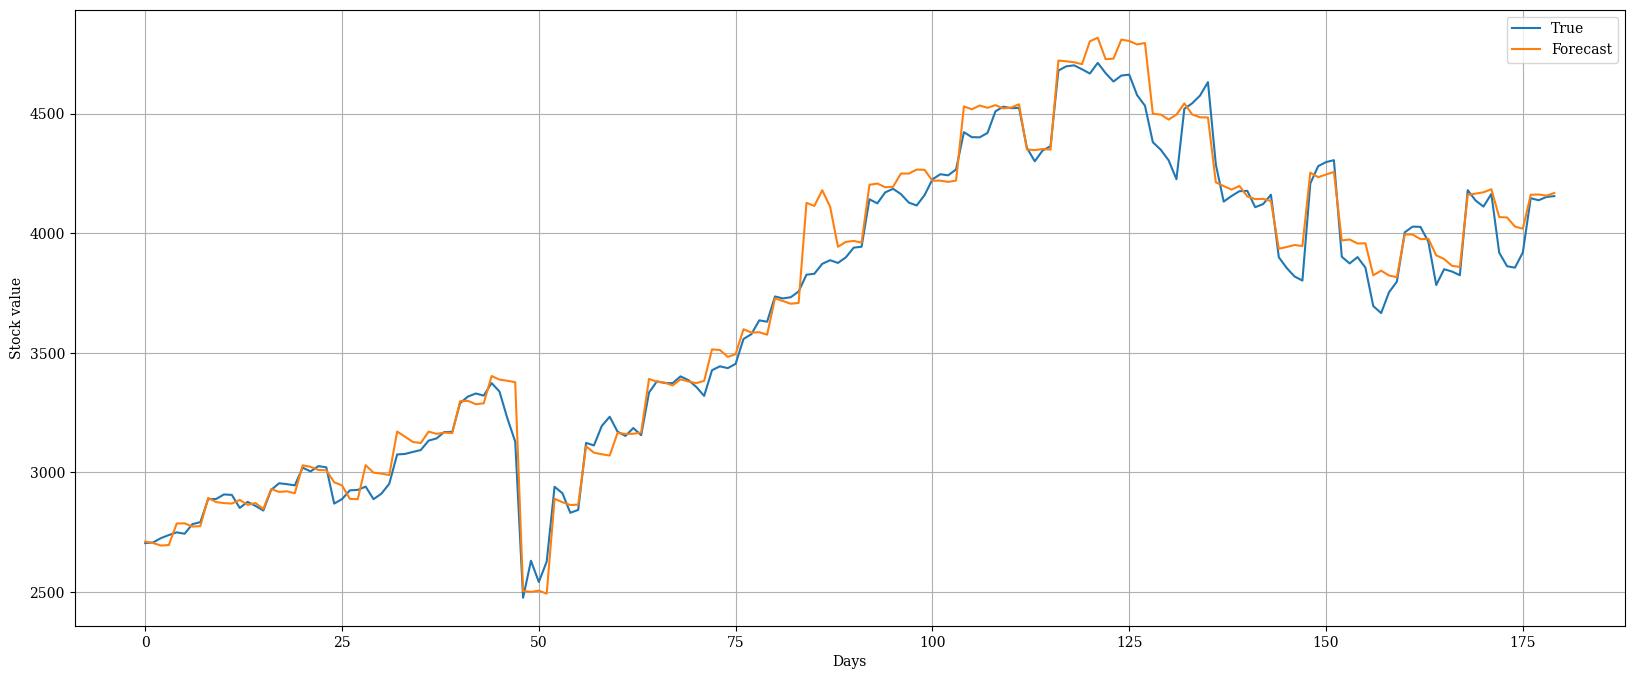

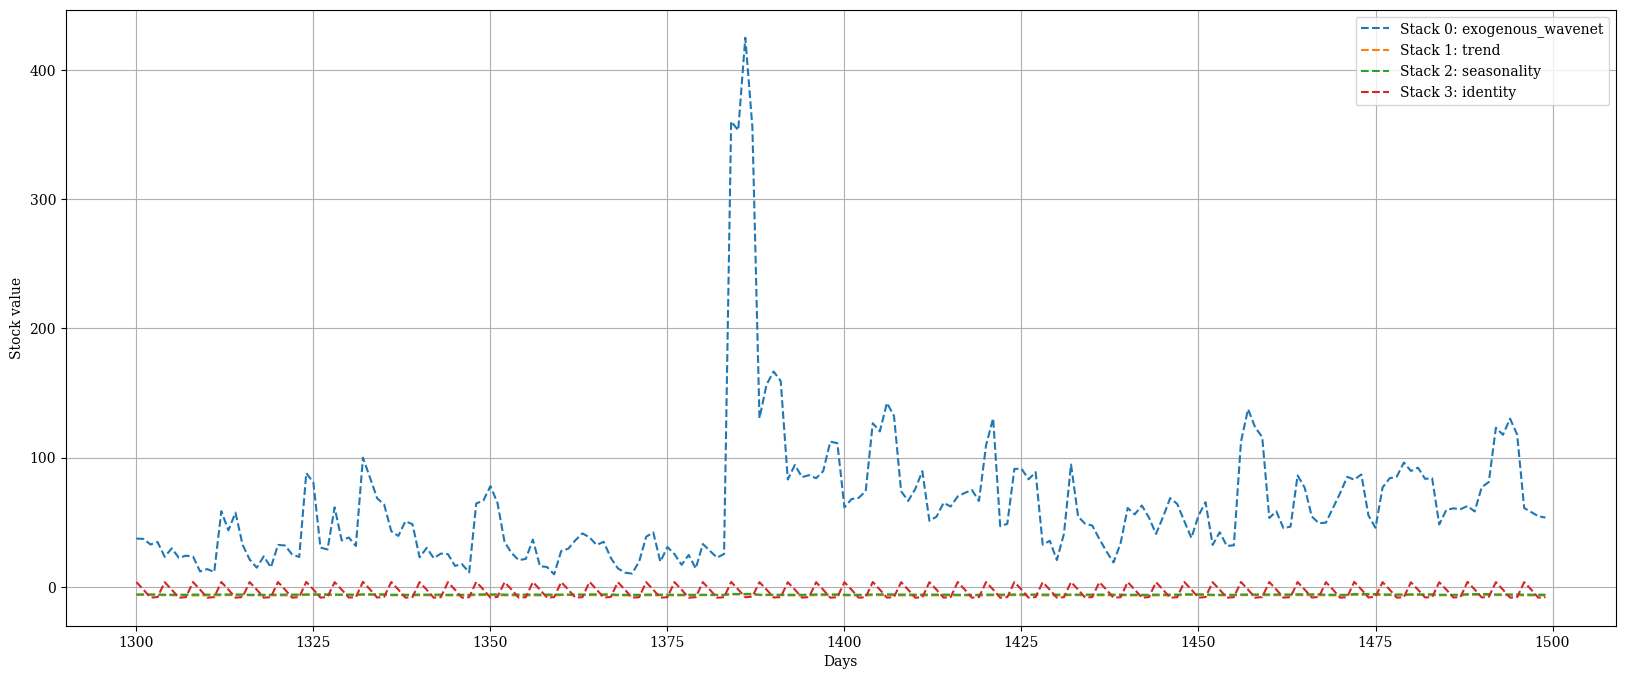

In [30]:
list_stacks_w_exo = ['trend']+['seasonality']+['identity']
exo_stack_type_list = ['exogenous', 'exogenous_tcn', 'exogenous_wavenet']
k = 0
val_loss='MSE'
loss='MSE'
input_size_multiplier=60
output_size=4

for exo_stack_type in exo_stack_type_list:
            print(80*'=')
            print('Case: ', k,f'Exogenous stack types considered: {exo_stack_type}' )
            list_stacks = [exo_stack_type]+list_stacks_w_exo
            
            model, train_loader, val_loader = training(df, list_exo, loss=loss, val_loss=val_loss, input_size_multiplier=input_size_multiplier, output_size=output_size, list_stacks =list_stacks )

            y_true, y_hat, block_forecast, outsample_masks_ = predict_nbeats(model, val_loader, decomposition = True)
            k+=1
            print(80*'=')

### Impact of the loss functions

Case:  0 Loss function considered: MAE
 Val Loss function considered: MAE
list_exo =  ['^VIX', '^TNX']
Processing dataframes ...
Creating ts tensor ...


============================== Start fitting ==============================
Step: 50, Time: 1.399, Insample MAE: 29.43842, Outsample MAE: 56.82769
Step: 100, Time: 2.770, Insample MAE: 35.36213, Outsample MAE: 52.55784
Step: 150, Time: 4.119, Insample MAE: 27.69452, Outsample MAE: 58.77143
Step: 200, Time: 5.479, Insample MAE: 24.70931, Outsample MAE: 56.80259
Step: 250, Time: 6.822, Insample MAE: 20.43656, Outsample MAE: 59.95618
Step: 300, Time: 8.169, Insample MAE: 20.42867, Outsample MAE: 60.91721
Step: 350, Time: 9.555, Insample MAE: 18.74404, Outsample MAE: 61.46127
Step: 400, Time: 10.888, Insample MAE: 18.67049, Outsample MAE: 60.31066
Step: 450, Time: 12.264, Insample MAE: 18.43492, Outsample MAE: 63.33194
Step: 500, Time: 13.642, Insample MAE: 21.02122, Outsample MAE: 77.35449
Step: 550, Time: 14.979, Insample MAE: 17.02764,

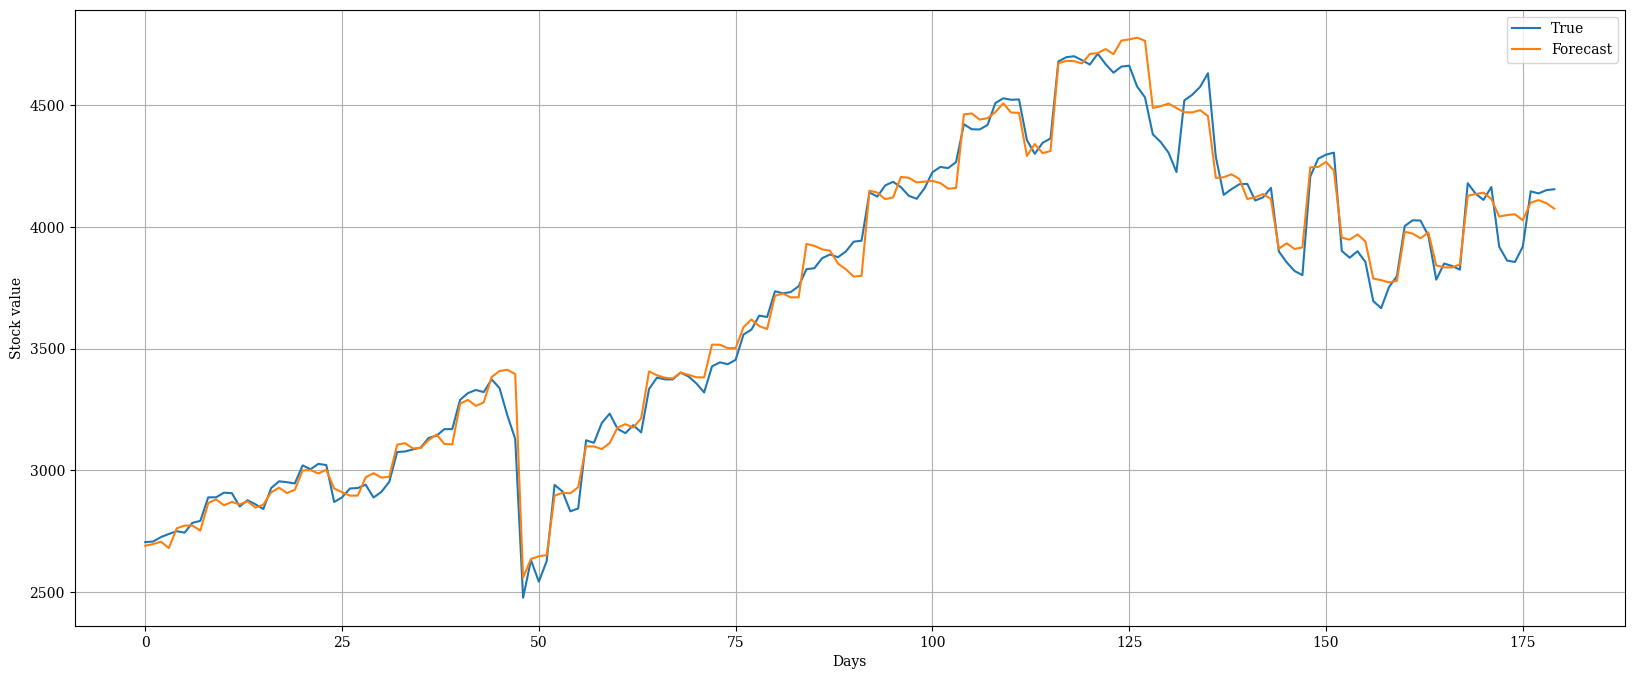

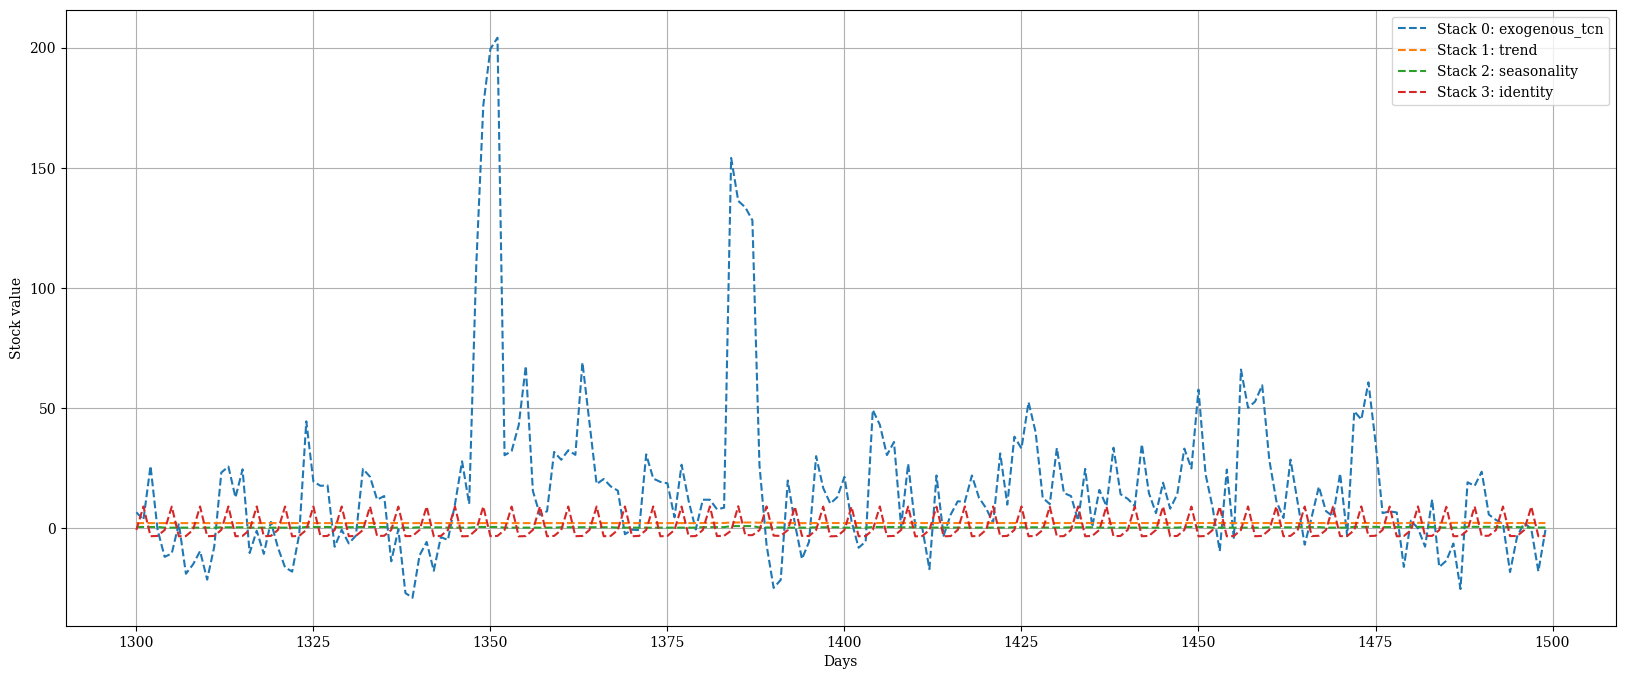

Case:  1 Loss function considered: MSE
 Val Loss function considered: MAE
list_exo =  ['^VIX', '^TNX']
Processing dataframes ...
Creating ts tensor ...


============================== Start fitting ==============================
Step: 50, Time: 1.363, Insample MSE: 1923.18518, Outsample MAE: 58.83485
Step: 100, Time: 2.733, Insample MSE: 1408.75720, Outsample MAE: 75.49211
Step: 150, Time: 4.060, Insample MSE: 1001.84888, Outsample MAE: 73.39886
Step: 200, Time: 5.398, Insample MSE: 673.88647, Outsample MAE: 76.13507
Step: 250, Time: 6.728, Insample MSE: 741.31494, Outsample MAE: 81.33804
Step: 300, Time: 8.128, Insample MSE: 686.94067, Outsample MAE: 76.09695
Step: 350, Time: 9.462, Insample MSE: 754.51172, Outsample MAE: 73.88113
Step: 400, Time: 10.784, Insample MSE: 782.30121, Outsample MAE: 79.50780
Step: 450, Time: 12.194, Insample MSE: 499.51892, Outsample MAE: 79.00017
Step: 500, Time: 13.523, Insample MSE: 458.41122, Outsample MAE: 81.49500
Step: 550, Time: 14.841, Insample M

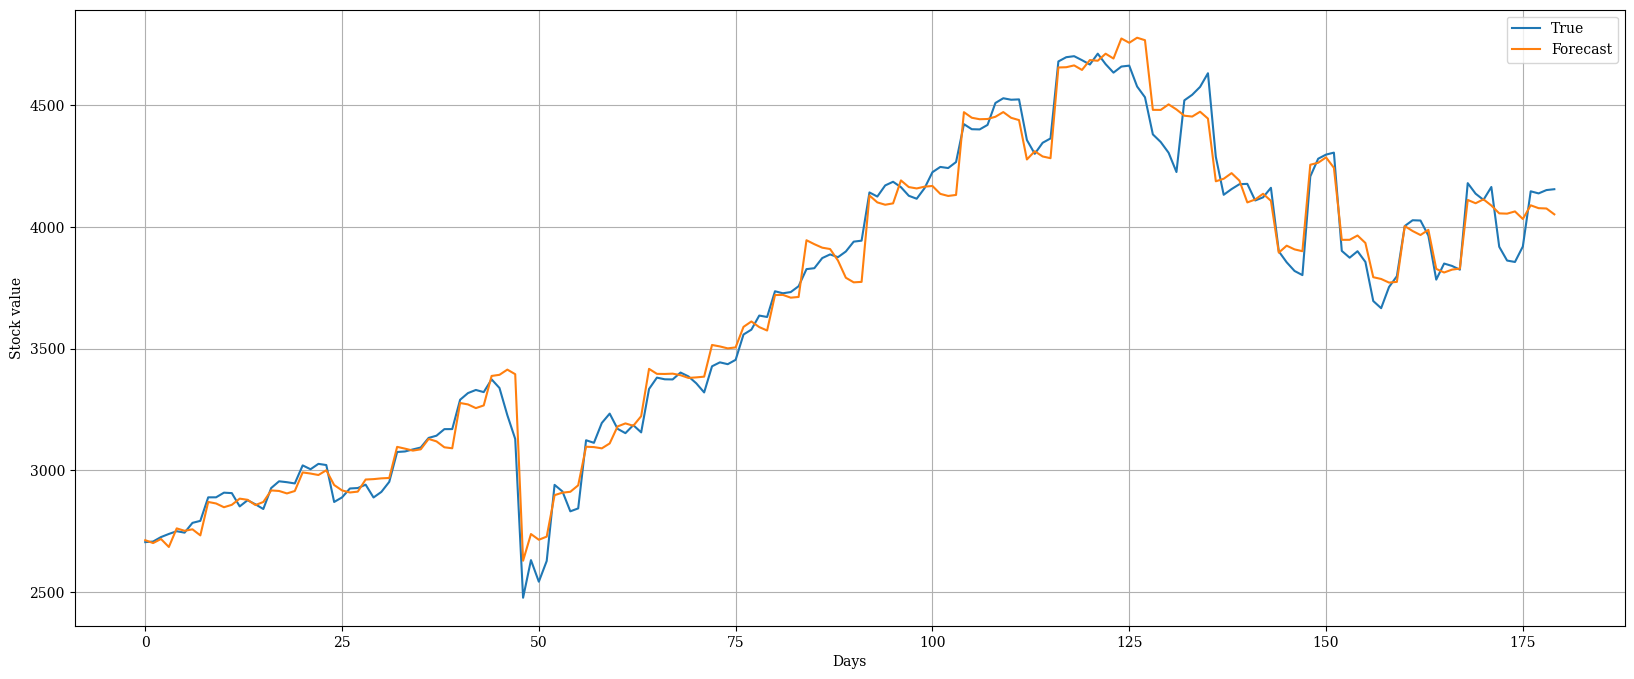

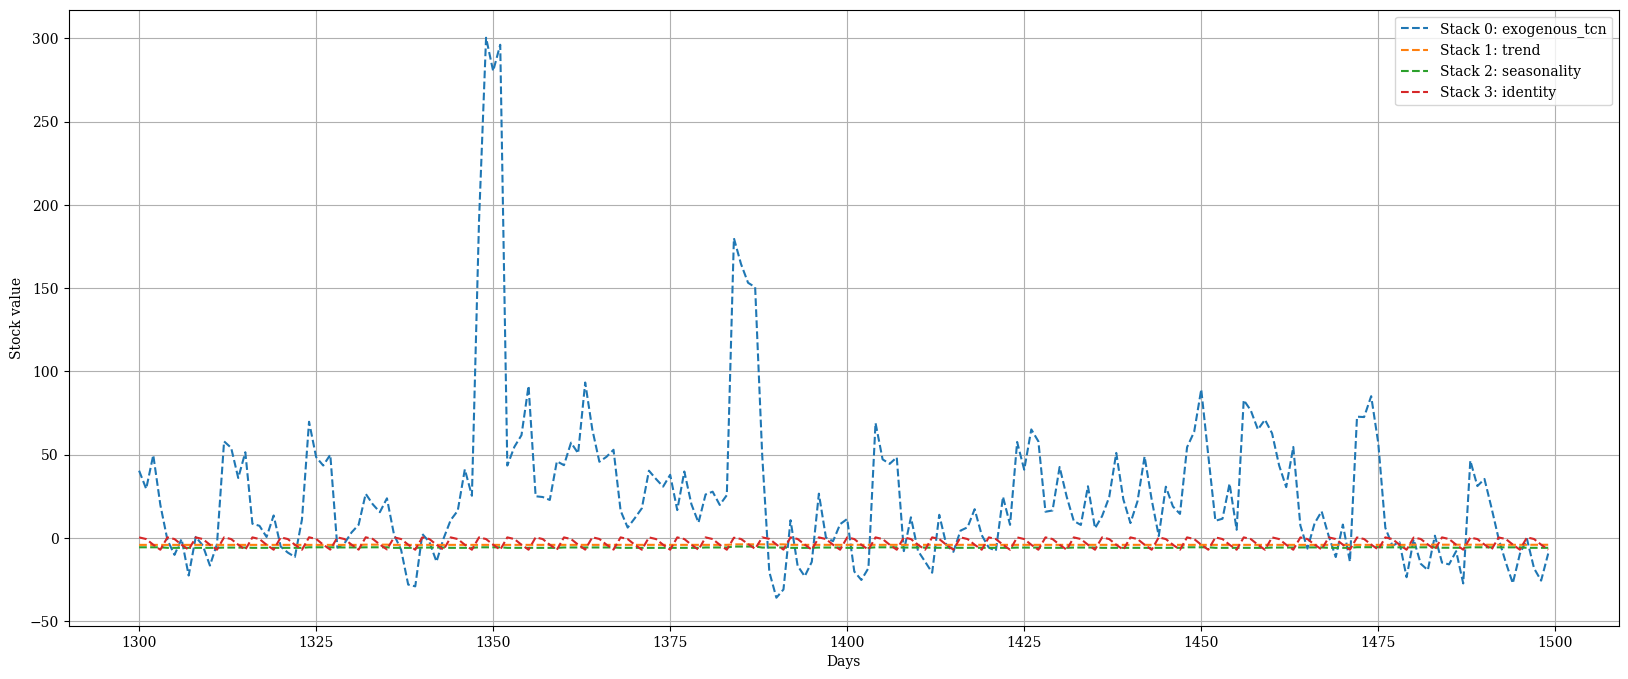

Case:  2 Loss function considered: MAE
 Val Loss function considered: MSE
list_exo =  ['^VIX', '^TNX']
Processing dataframes ...
Creating ts tensor ...


============================== Start fitting ==============================
Step: 50, Time: 1.399, Insample MAE: 29.43842, Outsample MSE: 6191.83936
Step: 100, Time: 2.748, Insample MAE: 35.36213, Outsample MSE: 5086.38818
Step: 150, Time: 4.087, Insample MAE: 27.69452, Outsample MSE: 6555.90820
Step: 200, Time: 5.419, Insample MAE: 24.70931, Outsample MSE: 5636.87109
Step: 250, Time: 6.745, Insample MAE: 20.43656, Outsample MSE: 6469.85059
Step: 300, Time: 8.066, Insample MAE: 20.42867, Outsample MSE: 6568.38086
Step: 350, Time: 9.382, Insample MAE: 18.74404, Outsample MSE: 6803.80859
Step: 400, Time: 10.754, Insample MAE: 18.67049, Outsample MSE: 6600.47852
Step: 450, Time: 12.074, Insample MAE: 18.43492, Outsample MSE: 7235.96143
Step: 500, Time: 13.395, Insample MAE: 21.02122, Outsample MSE: 10346.22656
Step: 550, Time: 14.738, In

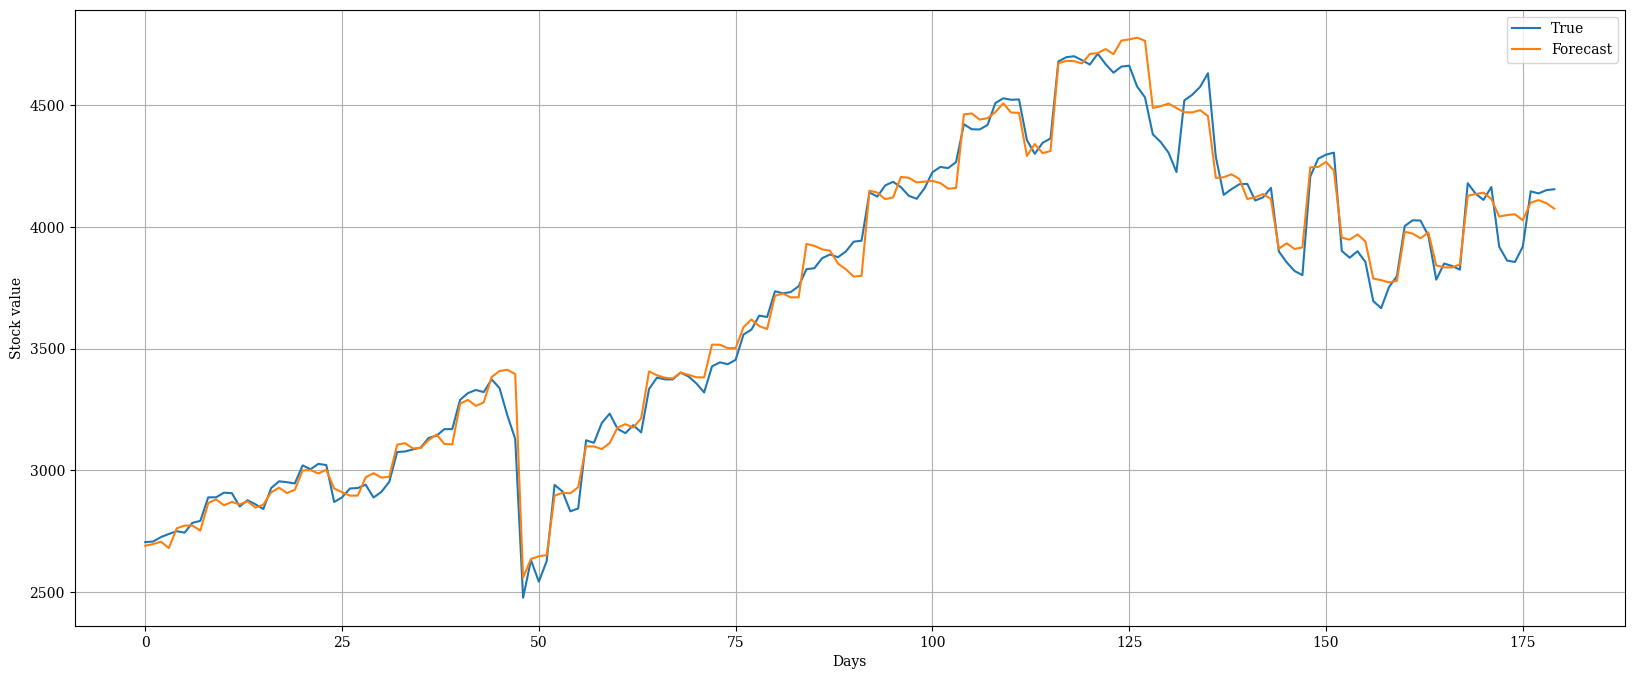

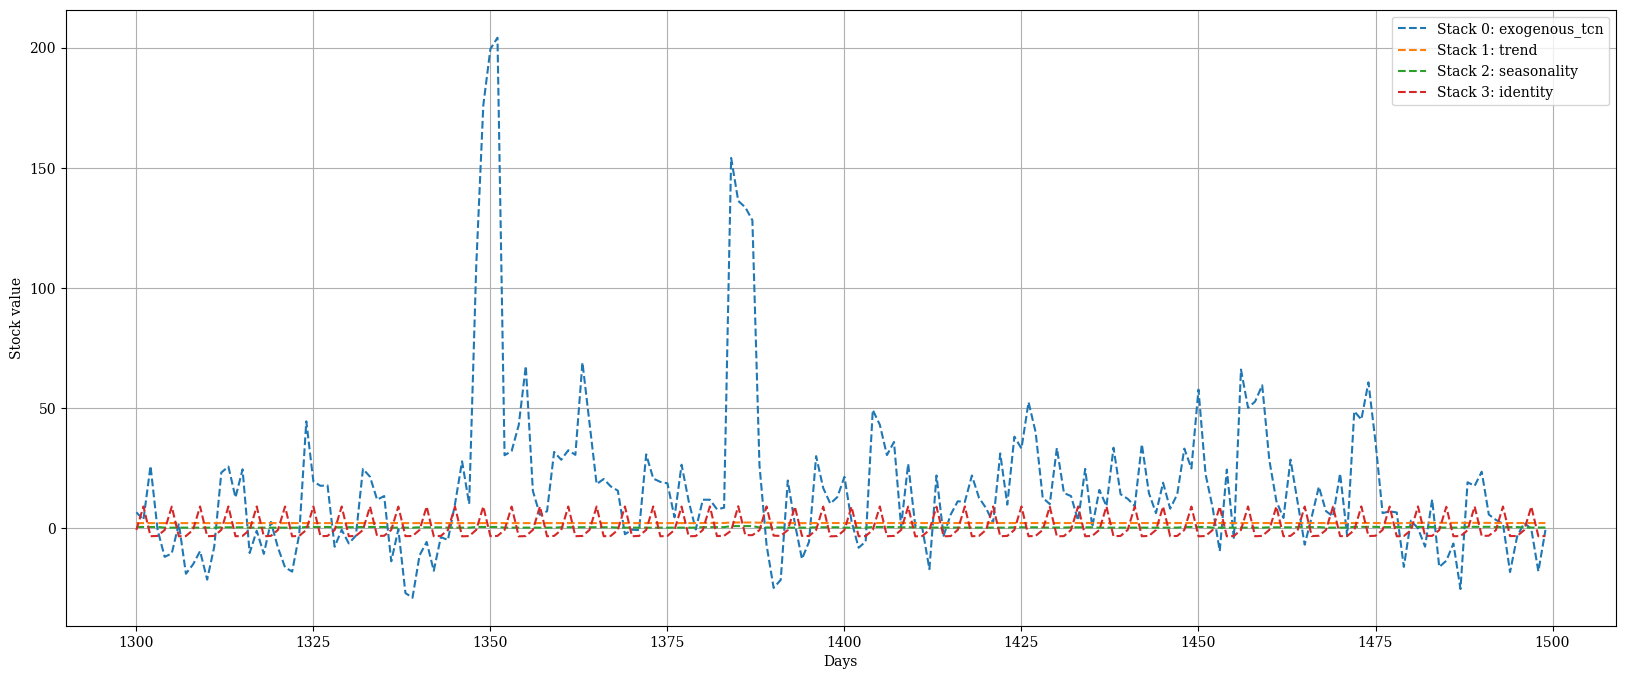

Case:  3 Loss function considered: MSE
 Val Loss function considered: MSE
list_exo =  ['^VIX', '^TNX']
Processing dataframes ...
Creating ts tensor ...


============================== Start fitting ==============================
Step: 50, Time: 1.364, Insample MSE: 1923.18518, Outsample MSE: 6055.46484
Step: 100, Time: 2.704, Insample MSE: 1408.75720, Outsample MSE: 9396.03711
Step: 150, Time: 4.029, Insample MSE: 1001.84888, Outsample MSE: 9529.18457
Step: 200, Time: 5.349, Insample MSE: 673.88647, Outsample MSE: 10337.48145
Step: 250, Time: 6.671, Insample MSE: 741.31494, Outsample MSE: 11378.18750
Step: 300, Time: 7.982, Insample MSE: 686.94067, Outsample MSE: 10470.95410
Step: 350, Time: 9.304, Insample MSE: 754.51172, Outsample MSE: 10151.47754
Step: 400, Time: 10.615, Insample MSE: 782.30121, Outsample MSE: 12296.49609
Step: 450, Time: 11.997, Insample MSE: 499.51892, Outsample MSE: 12274.68359
Step: 500, Time: 13.316, Insample MSE: 458.41122, Outsample MSE: 14327.33789
Step: 55

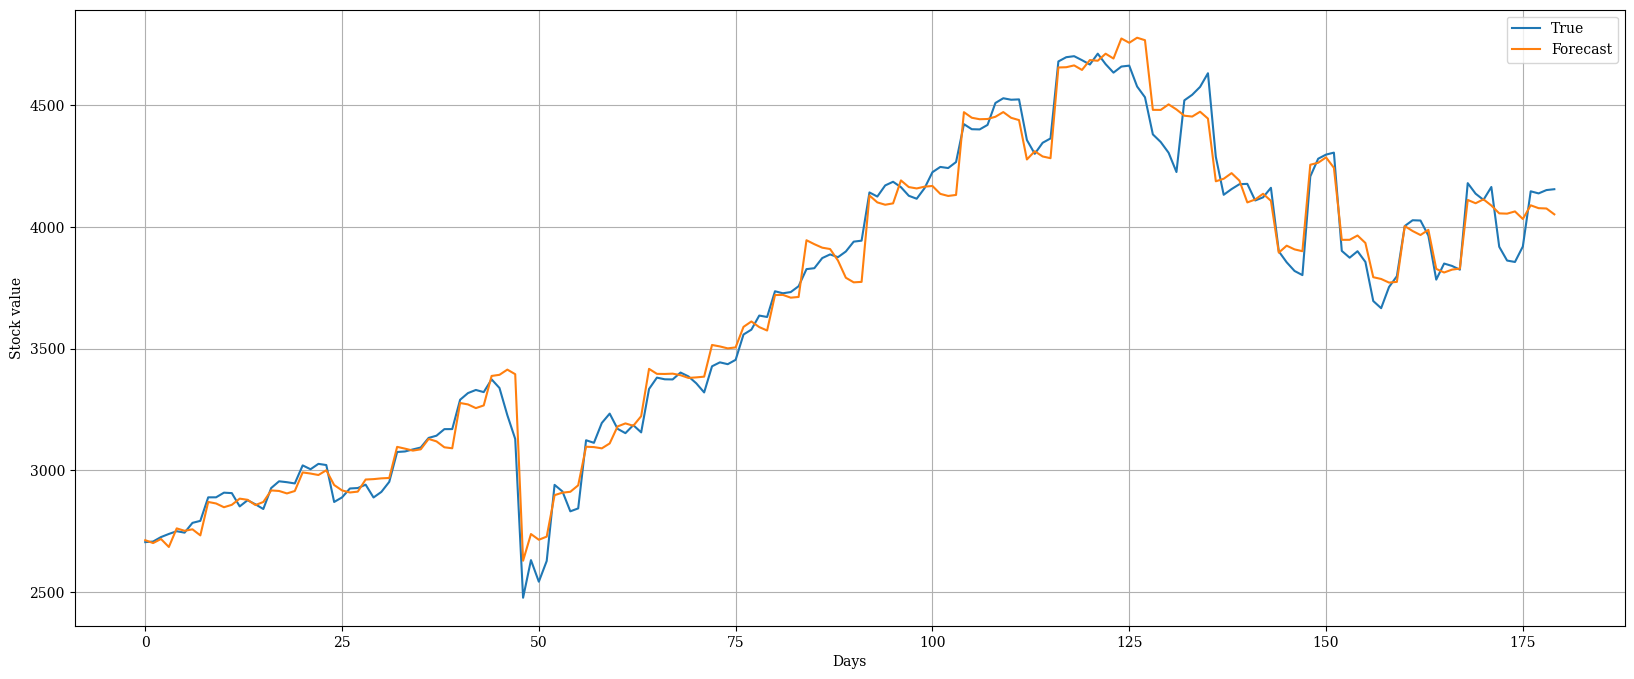

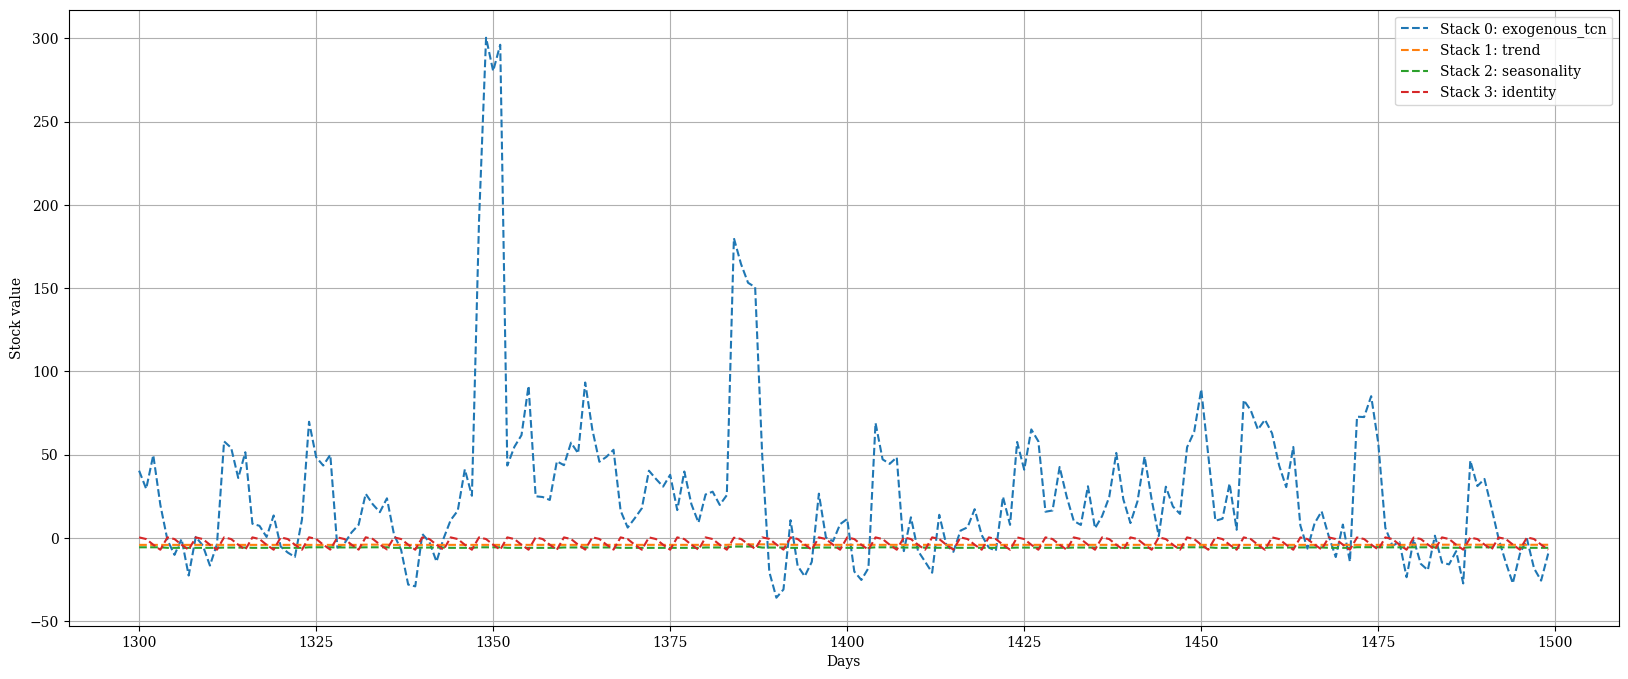

In [31]:
list_stacks = ['exogenous_tcn']+['trend']+['seasonality']+['identity']
k = 0
loss_list =['MAE', 'MSE']
input_size_multiplier=60
output_size=4

#for list_stacks in generate_subsets(list_all_stacks):
for val_loss in loss_list:
    for loss in loss_list:
            print(80*'=')
            print('Case: ', k,f'Loss function considered: {loss}')
            print(f' Val Loss function considered: {val_loss}')

            model, train_loader, val_loader = training(df, list_exo, loss=loss, val_loss=val_loss, input_size_multiplier=input_size_multiplier, output_size=output_size,list_stacks = list_stacks)

            y_true, y_hat, block_forecast, outsample_masks_ = predict_nbeats(model, val_loader, decomposition = True)
            k+=1
            print(80*'=')

### Impact of the activation et initialization functions

In [32]:
#Possibilities: 

#activation: str
#Activation function.
#An item from ['relu', 'softplus', 'tanh', 'selu', 'lrelu', 'prelu', 'sigmoid'].

#initialization: str
#Initialization function.
#An item from ['orthogonal', 'he_uniform', 'glorot_uniform', 'glorot_normal', 'lecun_normal'].


## CROSS VALIDATION

In [26]:
def training_cross_validation(df, list_exo, loss='MSE', val_loss='MSE', input_size_multiplier=7, output_size=24,list_stacks = ['exogenous_tcn']+['trend']+['seasonality']+['identity']):

    # Example lists
    print('list_exo = ', list_exo)
    keys_list_exo = list_exo
    values_list_exo = [f'Exogenous{i}' for i in range(1, len(list_exo)+1)]
    #print(values_list_exo)
    # Create the dictionary
    result_dict = create_dictionary(keys_list_exo, values_list_exo)
    #print(result_dict)
    df.rename(columns=result_dict, inplace=True)

    df['week_day'] = df['ds'].dt.dayofweek
    len_train = int(0.8*len(df))
    """
            Y_df: DataFrame
                DataFrame with target variable. Must contain columns ['unique_id', 'ds', 'y']
            X_df: DataFrame
                DataFrame with temporal exogenous variables. Must contain columns ['unique_id', 'ds']

    """
    Y_df = df[['ds', 'unique_id', 'y']]
    #print('Y_df:', Y_df)
    X_df = df[['ds', 'unique_id']+['week_day']+values_list_exo]
    #print('X_df:', X_df)
    ####################################################################################################
    # Dataset object. Pre-process the DataFrame into pytorch tensors and windows.
    # Setting parameters:
    # implied input_size
    input_size=input_size_multiplier*output_size
    #print('input size:', input_size)
    #list_stacks = ['exogenous_tcn']+['trend']+['seasonality']#['identity']+

    ####################################################################################################

    # Dictionary with lags to include for y and each exogenous variable.
    # Eg: -1 corresonds to future (available for exogenous), -2 correponds to last available day, and so on.
    include_var_dict = {'y': [-8,-4,-3,-2],
                        'Exogenous1': [-8,-4,-3,-2],#[-8,-2,-1],
                        'Exogenous2': [-8,-4,-3,-2],#[-8,-2,-1],
                        'week_day': [-1]}

    model = Nbeats(input_size_multiplier=input_size_multiplier,
                    output_size=output_size,
                    shared_weights=False,
                    initialization='he_uniform',
                    activation='sigmoid', #selu',
                    stack_types=list_stacks,#
                    n_blocks=len(list_stacks)*[1],#[1, 1],
                    n_layers=len(list_stacks)*[2],#[2, 2],
                    n_hidden=len(list_stacks)*[[512,512]],#[[512,512], [512,512]],
                    n_harmonics=0, # not used with exogenous_tcn
                    n_polynomials=0, # not used with exogenous_tcn
                    x_s_n_hidden = 0,
                    exogenous_n_channels=9,
                    include_var_dict=include_var_dict,
                    t_cols=ts_dataset.t_cols,
                    batch_normalization = True,
                    dropout_prob_theta=0.1,
                    dropout_prob_exogenous=0,
                    learning_rate=0.001,
                    lr_decay=0.5,
                    n_lr_decay_steps=3,
                    early_stopping=50,
                    weight_decay=0,
                    l1_theta=0,
                    n_iterations=5_000,
                    loss=loss,
                    loss_hypar=0.5,
                    val_loss=val_loss,
                    seasonality=24, # not used: only used with MASE loss
                    random_seed=1)

    #Values(X_df, Y_df, n_validations=1, n_iterations=None, verbose=True, eval_steps=1, input_size_multiplier=7, output_size=24)
    val_loader, mean_best_vals = model.fit_cross_validation(X_df=X_df, Y_df=Y_df, n_validations=4, n_iterations=10, eval_steps=50, input_size_multiplier=input_size_multiplier, output_size=output_size)
    return model, val_loader, mean_best_vals

In [53]:
list_stacks = ['trend']+['seasonality']+['identity']+['exogenous_tcn']
val_loss='MSE'
loss='MSE'
input_size_multiplier=52
output_size=4
model, val_loader, mean_best_vals = training_cross_validation(df[:-25*output_size-input_size], list_exo, loss='MSE', val_loss='MSE', input_size_multiplier=input_size_multiplier, output_size=output_size, list_stacks =list_stacks )

list_exo =  ['^VIX', '^TNX']
input size: 208
Processing dataframes ...
Creating ts tensor ...


============================== Start fitting ==============================
Step: 50, Time: 2.858, Insample MSE: 2440.13696, Outsample MSE: 3170.32520
Step: 100, Time: 5.594, Insample MSE: 1491.60376, Outsample MSE: 5834.47070
Step: 150, Time: 9.029, Insample MSE: 1159.51611, Outsample MSE: 8801.18555
Step: 200, Time: 12.235, Insample MSE: 715.74664, Outsample MSE: 11581.43066
Step: 250, Time: 14.639, Insample MSE: 504.75061, Outsample MSE: 11241.92383
Step: 300, Time: 17.007, Insample MSE: 501.02661, Outsample MSE: 12290.37891
Step: 350, Time: 19.281, Insample MSE: 359.16522, Outsample MSE: 13298.82422
Step: 400, Time: 21.697, Insample MSE: 338.00497, Outsample MSE: 10691.52832
Step: 450, Time: 24.070, Insample MSE: 318.69595, Outsample MSE: 11329.03125
Step: 500, Time: 26.408, Insample MSE: 173.94724, Outsample MSE: 10683.52344
Step: 550, Time: 28.686, Insample MSE: 259.46698, Outsample MS

In [54]:
# Training without cross-validation on the same val/train loader
cross_val = False
model2, train_loader, val_loader = training(df[:-25*output_size-input_size], list_exo, loss='MSE', val_loss='MSE', input_size_multiplier=input_size_multiplier, output_size=output_size, list_stacks =list_stacks, cross_val = cross_val )

list_exo =  ['^VIX', '^TNX']
Processing dataframes ...
Creating ts tensor ...


============================== Start fitting ==============================
Step: 50, Time: 1.825, Insample MSE: 537.40125, Outsample MSE: 24966.96094
Step: 100, Time: 3.613, Insample MSE: 295.80954, Outsample MSE: 52088.81250
Step: 150, Time: 5.401, Insample MSE: 222.63458, Outsample MSE: 67619.07812
Step: 200, Time: 7.175, Insample MSE: 230.53195, Outsample MSE: 72366.20312
Step: 250, Time: 8.964, Insample MSE: 201.46768, Outsample MSE: 69341.87500
Step: 300, Time: 10.818, Insample MSE: 178.90126, Outsample MSE: 72852.59375
Step: 350, Time: 12.737, Insample MSE: 275.79755, Outsample MSE: 69406.13281
Step: 400, Time: 14.541, Insample MSE: 177.86374, Outsample MSE: 75901.81250
Step: 450, Time: 16.332, Insample MSE: 186.16580, Outsample MSE: 80004.23438
Step: 500, Time: 18.110, Insample MSE: 190.05548, Outsample MSE: 72434.35938
Step: 550, Time: 19.970, Insample MSE: 165.45265, Outsample MSE: 81991.75000
Ste

### Plotting the results

In [55]:
Y_df = df[-25*output_size-input_size:][['ds', 'unique_id', 'y']]
    #print('Y_df:', Y_df)
X_df = df[-25*output_size-input_size:][['ds', 'unique_id']+['week_day']+values_list_exo]
print('X_df:', X_df)
    # train_mask: 1 to keep, 0 to mask
#train_mask = np.ones(len(Y_df))
    #print(train_mask)
#train_mask[-len_train:] = 0
train_mask = np.zeros(len(Y_df))
train_mask[0] = 1
    # Dataset object. Pre-process the DataFrame into pytorch tensors and windows.
ts_dataset = TimeSeriesDataset(Y_df=Y_df, X_df=X_df, ts_train_mask=train_mask)

    # Setting parameters: 
    # implied input_size
input_size=input_size_multiplier*output_size


# Validation loader (note: in this example we are also validating on the period to forecast)
val_loader = TimeSeriesLoader(model='nbeats',
                                  ts_dataset=ts_dataset,
                                  window_sampling_limit=365*4*24,
                                  offset=0,
                                  input_size=input_size,
                                  output_size=output_size,
                                  idx_to_sample_freq=24,
                                  batch_size=512,
                                  is_train_loader=False,
                                  shuffle=False)

X_df:              ds unique_id  week_day  Exogenous1  Exogenous2
1192 2022-08-01        NP         0   22.840000       2.606
1193 2022-08-02        NP         1   23.930000       2.741
1194 2022-08-03        NP         2   21.950001       2.748
1195 2022-08-04        NP         3   21.440001       2.676
1196 2022-08-05        NP         4   21.150000       2.840
...         ...       ...       ...         ...         ...
1495 2023-10-13        NP         4   19.320000       4.629
1496 2023-10-16        NP         0   17.209999       4.712
1497 2023-10-17        NP         1   17.879999       4.847
1498 2023-10-18        NP         2   19.219999       4.904
1499 2023-10-19        NP         3   21.400000       4.988

[308 rows x 5 columns]
Processing dataframes ...
Creating ts tensor ...


(48,)
(48,)
(48,)
(48,)


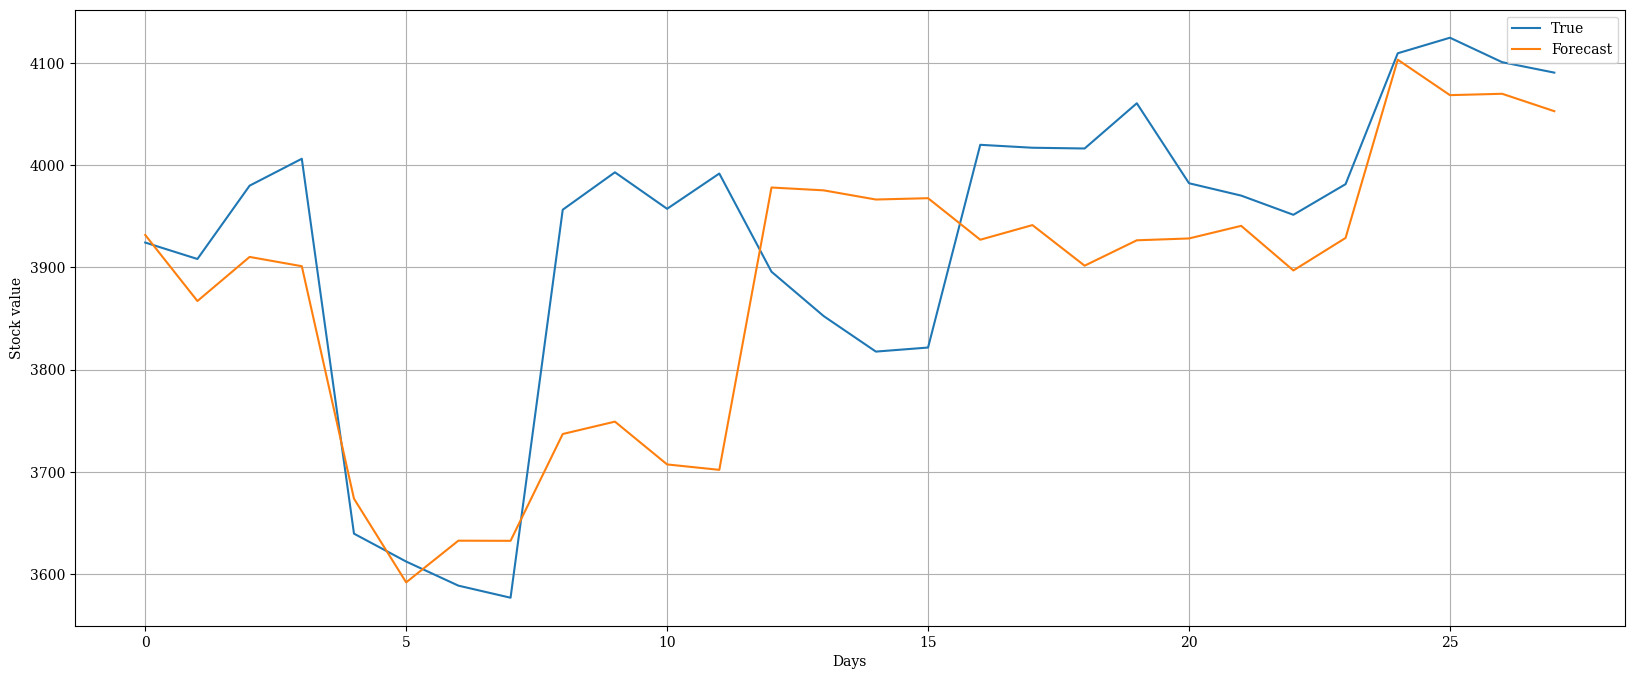

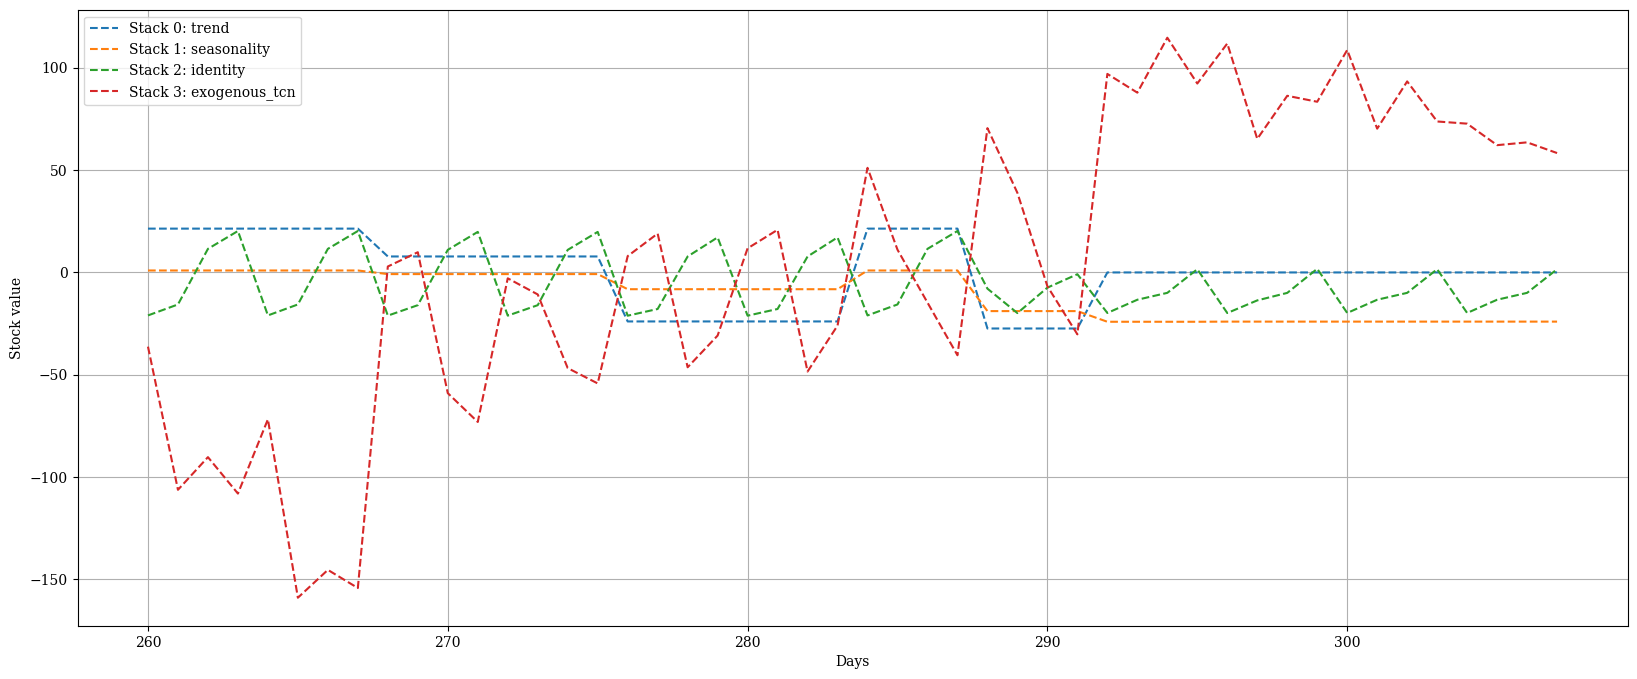

In [56]:
y_true, y_hat, block_forecast, outsample_masks_ = predict_nbeats(model, val_loader, decomposition = True)

(48,)
(48,)
(48,)
(48,)


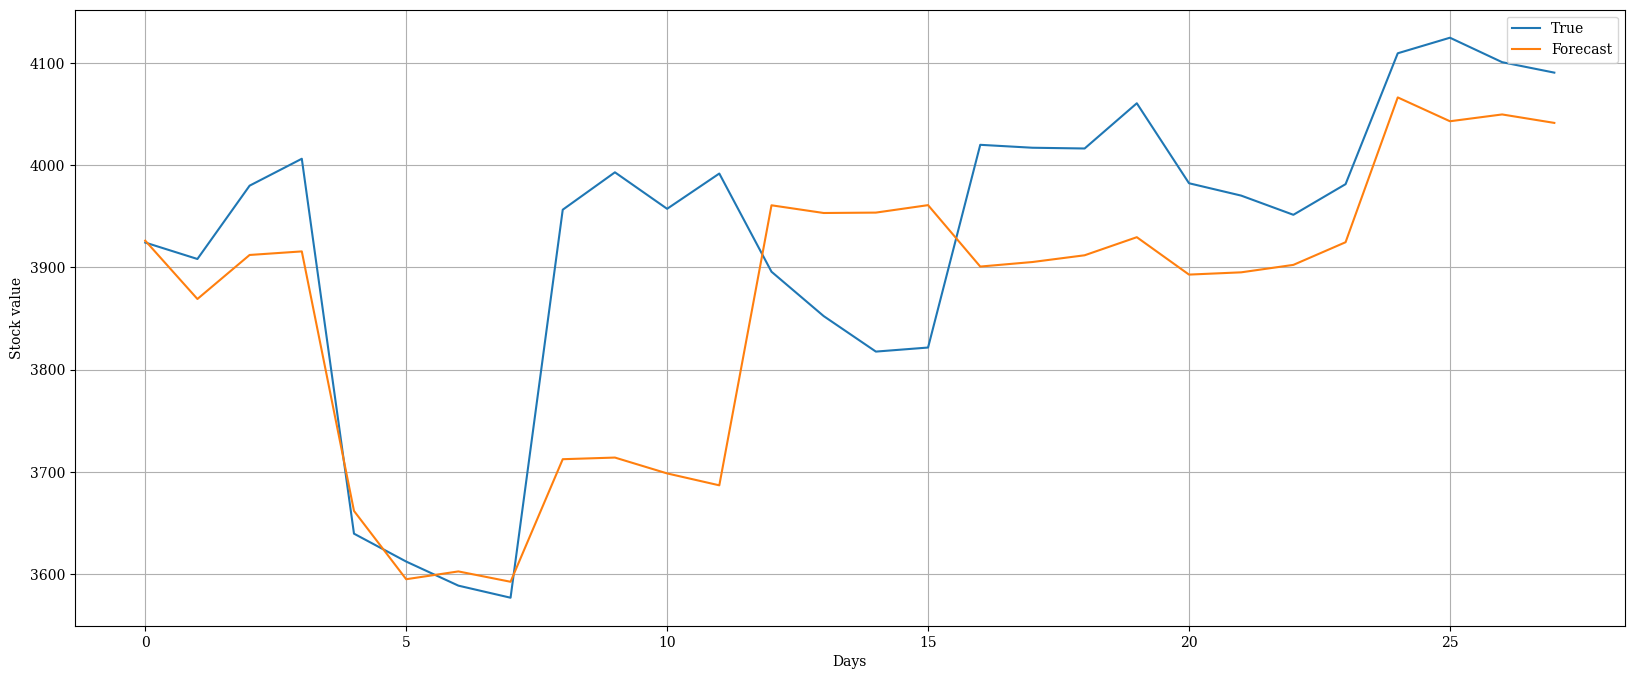

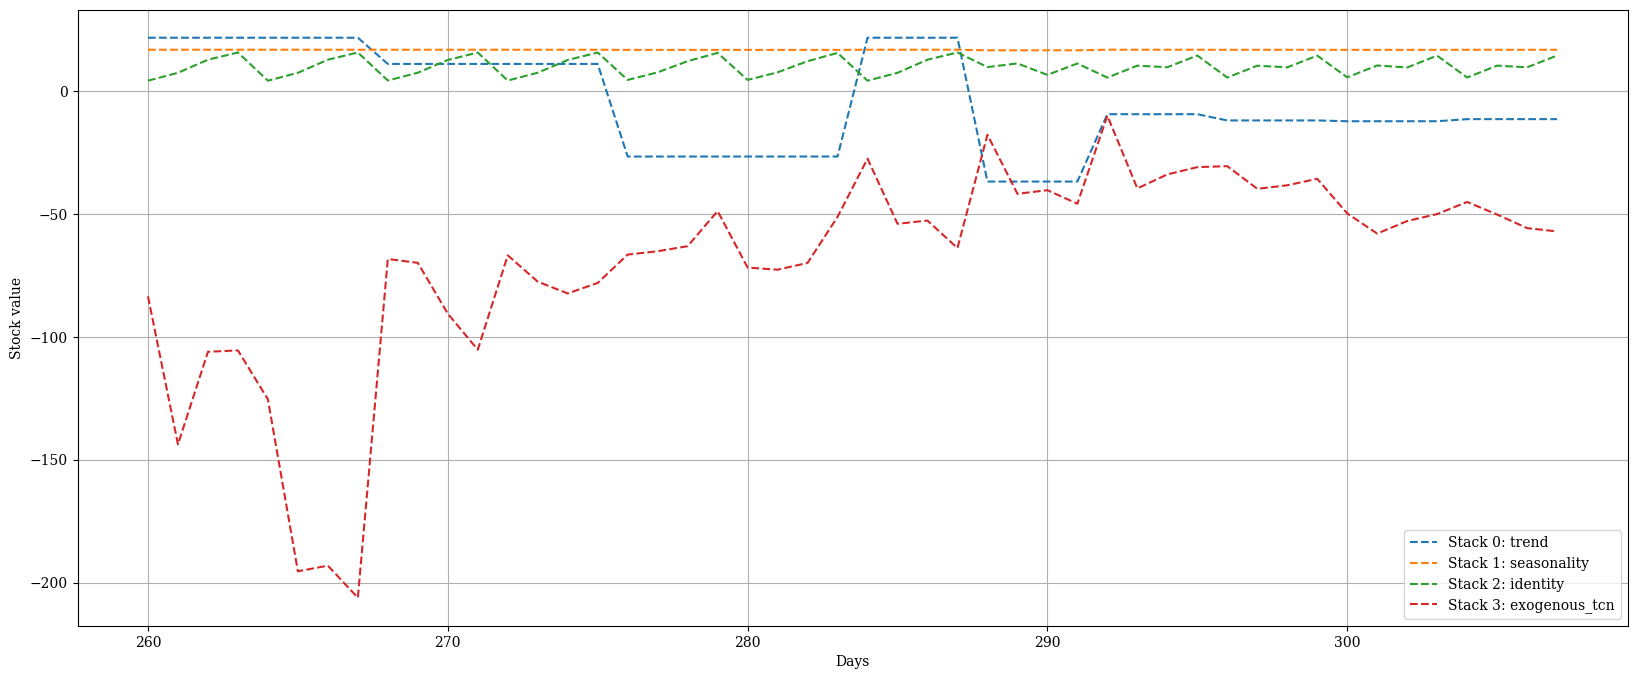

In [57]:
y_true, y_hat, block_forecast, outsample_masks_ = predict_nbeats(model2, val_loader, decomposition = True)